# CS74 Final Project 
## Jusung Park

In [ ]:
import autograd.numpy as np
from autograd import grad 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, Perceptron, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [218]:
# Load the training and test datasets
training_data = pd.read_csv('training.csv')
test_data = pd.read_csv('test.csv')

In [367]:
#convert training and test sets to numpy arrays
x_array_training = df_training.to_numpy()
x_array_test = df_test.to_numpy()

#actual star rating for training
y = x_array_training[:,0]

#concatenate reviewer text and summary in columns 7 and 8
x_raw_training = [str(i) + " " + str(j) for i, j in zip(x_array_training[:,6], x_array_training[:,7])]
x_raw_test = [str(i) + " " + str(j) for i, j in zip(x_array_test[:,5], x_array_test[:,6])]


In [220]:
#vectorizer reviews + summary for training
def Vectorize(ngram, df_min, df_max, features_max):
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=ngram, min_df = df_min, max_df = df_max, max_features = features_max)
    x_training = vectorizer.fit_transform(x_raw_training)
    x_testing = vectorizer.transform(x_raw_test)
    return x_training, x_testing

## Binary Classifiers

In [221]:
# initialize cutoffs values:
cutoff1 = np.where(y > 1, 1, 0)
cutoff2 = np.where(y > 2, 1, 0)
cutoff3 = np.where(y > 3, 1, 0)
cutoff4 = np.where(y > 4, 1, 0)

In [246]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

# Function to measure performance of binary classification
# Uses f1 macro score, ROC_AUC score, Recall, and Precision
def binary_results(y_pred, y_actual):
    
    correct_class_0 = np.sum((y_pred == 0) & (y_actual == 0))# Counting correct predictions for class 0
    correct_class_1 = np.sum((y_pred == 1) & (y_actual == 1))# Counting correct predictions for class 1
    false_class_0 = np.sum((y_pred == 0) & (y_actual == 1))# Counting false predictions for class 0
    false_class_1 = np.sum((y_pred == 1) & (y_actual == 0))# Counting false predictions for class 1

    # Calculating accuracy
    accuracy = np.mean(y_pred == y_actual)
    # Calculating F1 score (macro average)
    f1_macro = f1_score(y_actual, y_pred, average='macro')
    # Calculating precision (macro average), recall (macro average), and AUC-ROC
    precision = precision_score(y_actual, y_pred, average='macro')
    recall = recall_score(y_actual, y_pred, average='macro')
    auc_roc = roc_auc_score(y_actual, y_pred)
    # Counting true negatives
    true_negatives = np.sum((y_pred == 0) & (y_actual == 0))
    # Defining categories for the bar graph
    categories = ['Class 0 Correct', 'Class 1 Correct', 'Class 0 False', 'Class 1 False']
    # Count values for each category
    counts = [correct_class_0, correct_class_1, false_class_0, false_class_1]

    # Creating and displaying the bar graph
    fig, ax = plt.subplots()
    ax.bar(categories, counts)
    ax.set_xlabel('Category')
    ax.set_ylabel('Count')
    ax.set_title('Count of True and False Positives and Negatives')
    plt.show()

    # Calculating and displaying the confusion matrix
    cm = confusion_matrix(y_actual, y_pred)

    # Returning the metrics and information as a dictionary
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'True Negatives': '{:.4f}'.format(true_negatives),
        'F1 Score (Macro)': f1_macro,
        'AUC-ROC': auc_roc,
        'Confusion Matrix': cm
    }


### Linear Regression

In [263]:
from sklearn.model_selection import KFold

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
regressor = LogisticRegression(max_iter = 10000)

# Function to run the Linear Regression
def linear_regression(cutoff_params, cutoff_value, cutoffID, kaggle_C, kaggle_penalty, kaggle_solver):
    logr_grid_search = GridSearchCV(regressor, param_grid=cutoff_params, cv=kf)
    logr_grid_search.fit(x_training, cutoff_value)

    print("Best Hyperparameters:", logr_grid_search.best_params_)
    print("Best Score:", logr_grid_search.best_score_)

    logr_params = logr_grid_search.best_params_

    x_train, x_test, y_train, y_test = train_test_split(x_training, cutoff_value, test_size = 0.2)

    logr = LogisticRegression(C = logr_params['C'], penalty = logr_params['penalty'], solver = logr_params['solver'])
    logr.fit(x_train, y_train)
    predictions = logr.predict(x_test)
    res=binary_results(predictions, y_test)
    for i in res:
        print(i,':', res[i])
    
    # Plotting ROC Curve
    fpr_logr, tpr_logr, thresholds_logr = roc_curve(y_test, predictions)
    plt.plot(fpr_logr, tpr_logr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    
    # return csv file for kaggle
    logr_kaggle = LogisticRegression(C = kaggle_C, penalty = kaggle_penalty, solver = kaggle_solver)
    logr_kaggle.fit(x_training, cutoff_value)
    csvID = 'cutoff'+cutoffID+' predictions.csv'
    c_kaggle = logr_kaggle.predict(x_test)
    bsplit = 'binary_split_'+cutoffID
    c_predictions_df = pd.DataFrame(c_kaggle, columns=[bsplit])
    c_predictions_df.index.name = 'id'
    c_predictions_df.to_csv(csvID)


In [224]:
def findBest(C_params, cutoff, ID, c_kag, c_pen, c_solv):
    bestscore=0
    score=0
    for i in [0.001, 0.01, 0.1, 0.15]:
        j=0.2
        while j<1:
            x_training, x_testing = Vectorize((1,3), i, j, 10000)
            res=linear_regression(C_params, cutoff, ID, c_kag, c_pen, c_solv)
            score = res['AUC-ROC']
            print(i, j)
            if score>bestscore:
                bestscore=score
                bestmin=i
                bestmax=j
            j+=0.05
    return bestmin, bestmax

Cutoff = 1

Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


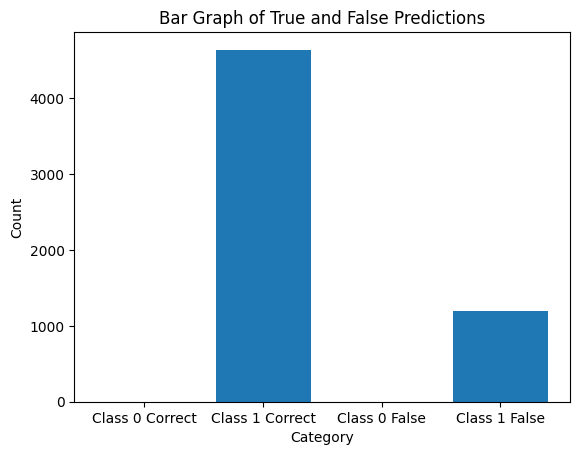

Accuracy : 0.7947927372387804
Precision : 0.3973963686193902
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44283260164153465
AUC-ROC : 0.5
Confusion Matrix : [[   0 1198]
 [   0 4640]]
0.001 0.2
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


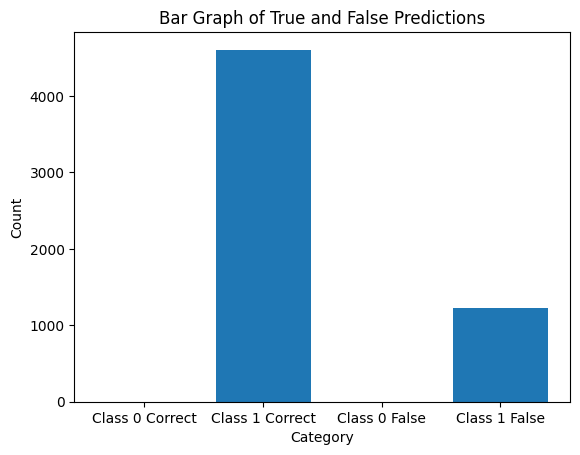

Accuracy : 0.7889688249400479
Precision : 0.39448441247002397
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4410187667560322
AUC-ROC : 0.5
Confusion Matrix : [[   0 1232]
 [   0 4606]]
0.001 0.25
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


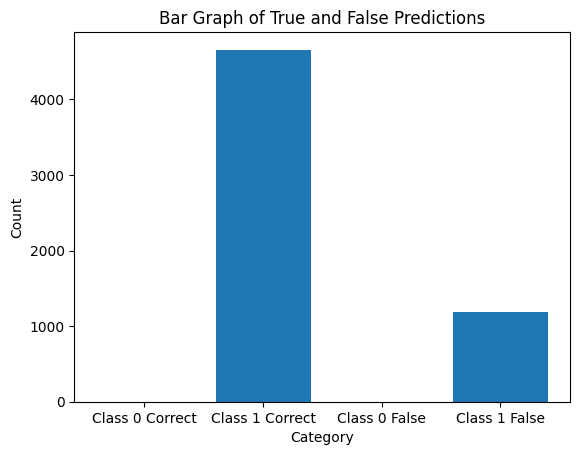

Accuracy : 0.7977046933881466
Precision : 0.3988523466940733
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4437351119580753
AUC-ROC : 0.5
Confusion Matrix : [[   0 1181]
 [   0 4657]]
0.001 0.3
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


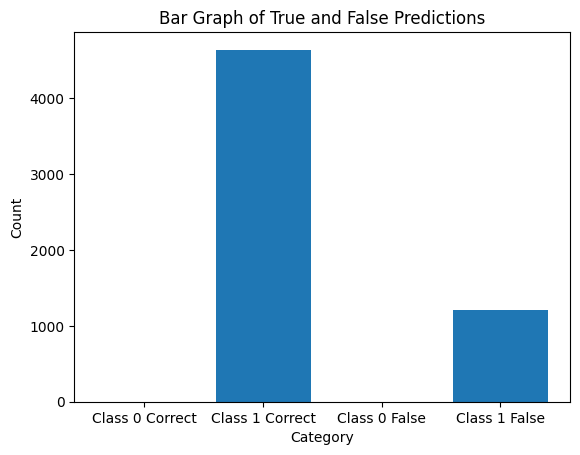

Accuracy : 0.7941075710859884
Precision : 0.3970537855429942
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4426198205079244
AUC-ROC : 0.5
Confusion Matrix : [[   0 1202]
 [   0 4636]]
0.001 0.35
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


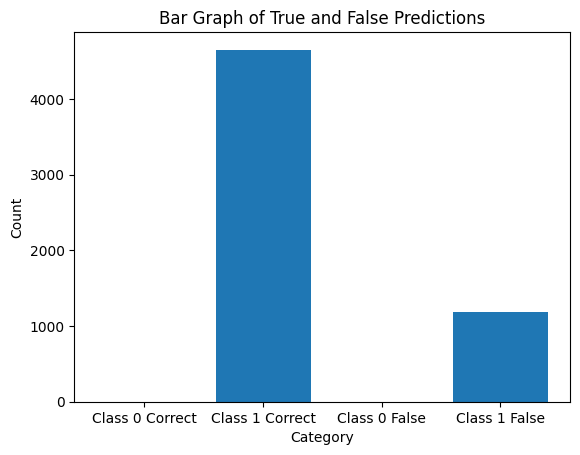

Accuracy : 0.7970195272353545
Precision : 0.39850976361767726
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4435230197311981
AUC-ROC : 0.5
Confusion Matrix : [[   0 1185]
 [   0 4653]]
0.001 0.39999999999999997
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


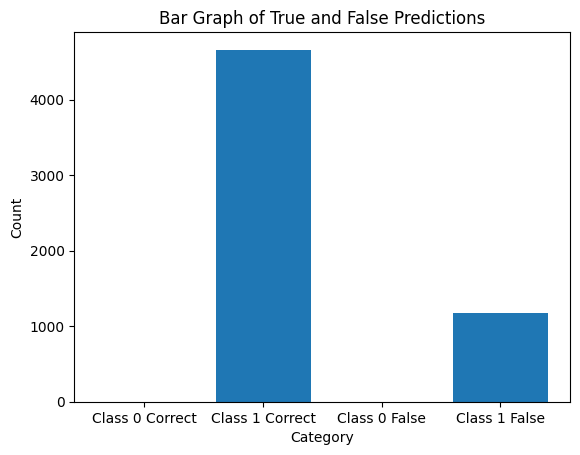

Accuracy : 0.7980472764645427
Precision : 0.3990236382322713
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4438410974564161
AUC-ROC : 0.5
Confusion Matrix : [[   0 1179]
 [   0 4659]]
0.001 0.44999999999999996
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


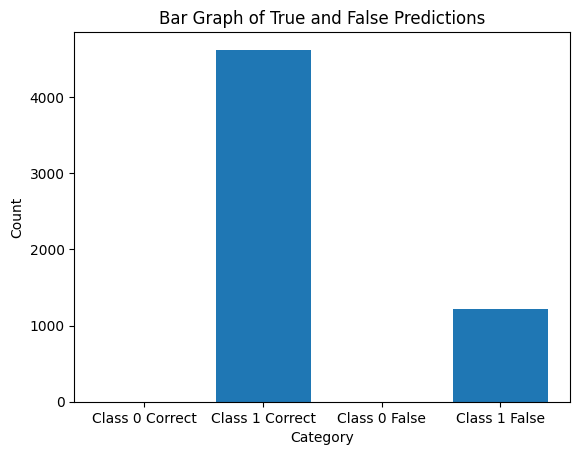

Accuracy : 0.7917094895512161
Precision : 0.39585474477560806
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44187380497131934
AUC-ROC : 0.5
Confusion Matrix : [[   0 1216]
 [   0 4622]]
0.001 0.49999999999999994
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


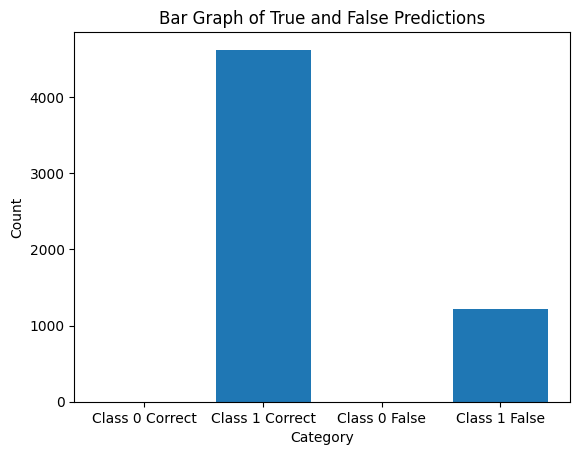

Accuracy : 0.7920520726276122
Precision : 0.3960260363138061
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44198050086025614
AUC-ROC : 0.5
Confusion Matrix : [[   0 1214]
 [   0 4624]]
0.001 0.5499999999999999
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


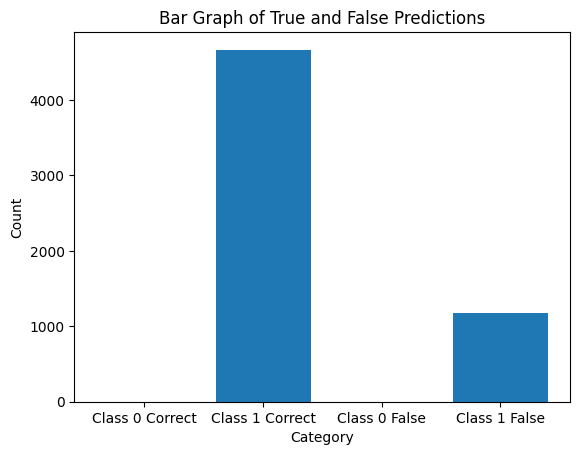

Accuracy : 0.7992463172319287
Precision : 0.39962315861596437
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44421172886519417
AUC-ROC : 0.5
Confusion Matrix : [[   0 1172]
 [   0 4666]]
0.001 0.6
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


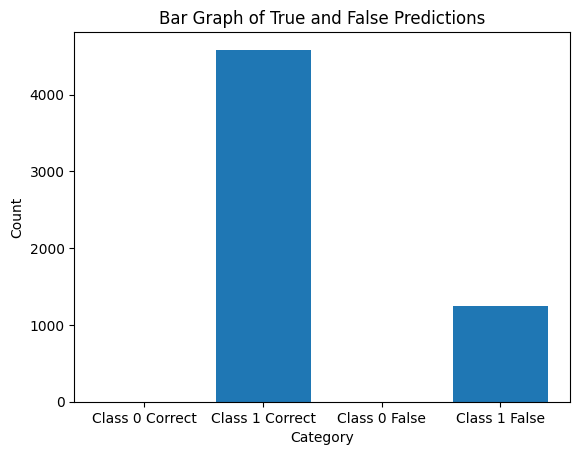

Accuracy : 0.7853717026378897
Precision : 0.39268585131894485
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4398925453324379
AUC-ROC : 0.5
Confusion Matrix : [[   0 1253]
 [   0 4585]]
0.001 0.65
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


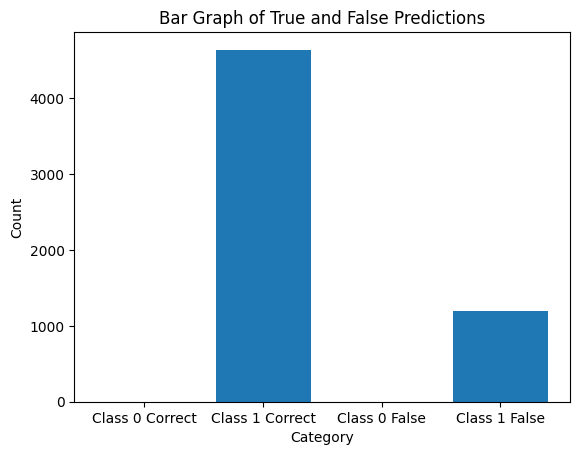

Accuracy : 0.7944501541623844
Precision : 0.3972250770811922
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4427262313860252
AUC-ROC : 0.5
Confusion Matrix : [[   0 1200]
 [   0 4638]]
0.001 0.7000000000000001
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


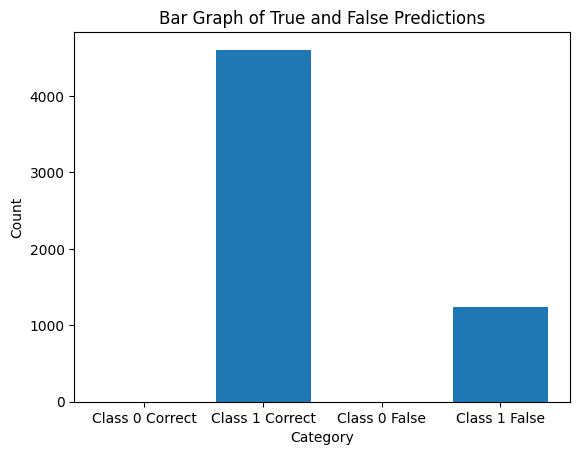

Accuracy : 0.7886262418636519
Precision : 0.39431312093182597
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44091170273893887
AUC-ROC : 0.5
Confusion Matrix : [[   0 1234]
 [   0 4604]]
0.001 0.7500000000000001
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


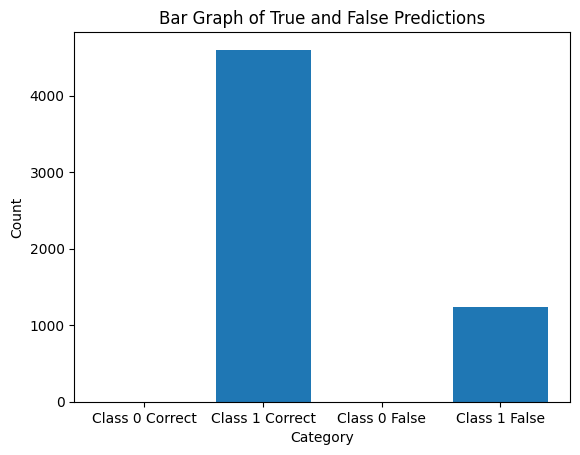

Accuracy : 0.7875984926344639
Precision : 0.39379924631723195
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4405902644691453
AUC-ROC : 0.5
Confusion Matrix : [[   0 1240]
 [   0 4598]]
0.001 0.8000000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


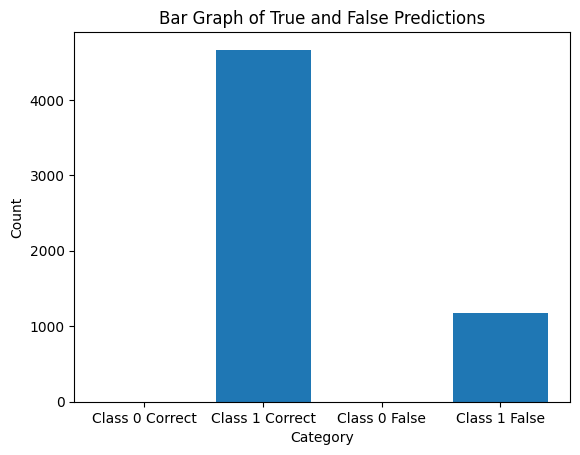

Accuracy : 0.7989037341555327
Precision : 0.39945186707776636
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44410588459341077
AUC-ROC : 0.5
Confusion Matrix : [[   0 1174]
 [   0 4664]]
0.001 0.8500000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


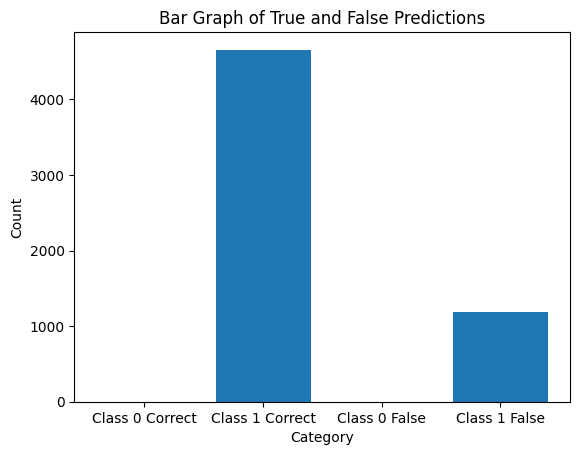

Accuracy : 0.7977046933881466
Precision : 0.3988523466940733
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4437351119580753
AUC-ROC : 0.5
Confusion Matrix : [[   0 1181]
 [   0 4657]]
0.001 0.9000000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


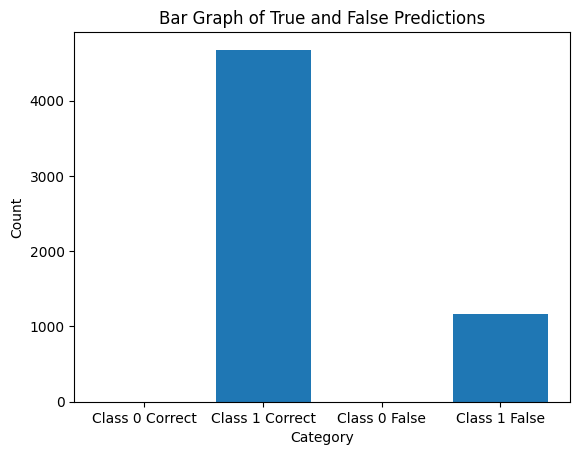

Accuracy : 0.8009592326139089
Precision : 0.40047961630695444
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44474034620506
AUC-ROC : 0.5
Confusion Matrix : [[   0 1162]
 [   0 4676]]
0.001 0.9500000000000003
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


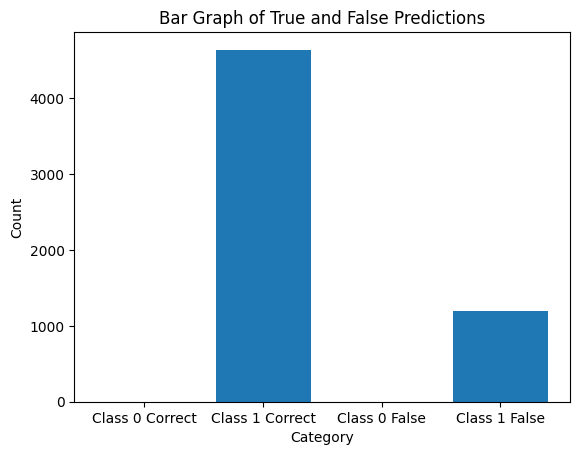

Accuracy : 0.7942788626241863
Precision : 0.39713943131209317
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.442673031026253
AUC-ROC : 0.5
Confusion Matrix : [[   0 1201]
 [   0 4637]]
0.01 0.2
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


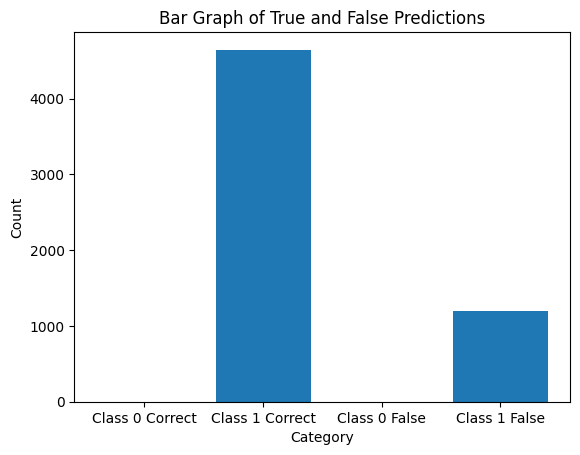

Accuracy : 0.7958204864679684
Precision : 0.3979102432339842
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44315146890499807
AUC-ROC : 0.5
Confusion Matrix : [[   0 1192]
 [   0 4646]]
0.01 0.25
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


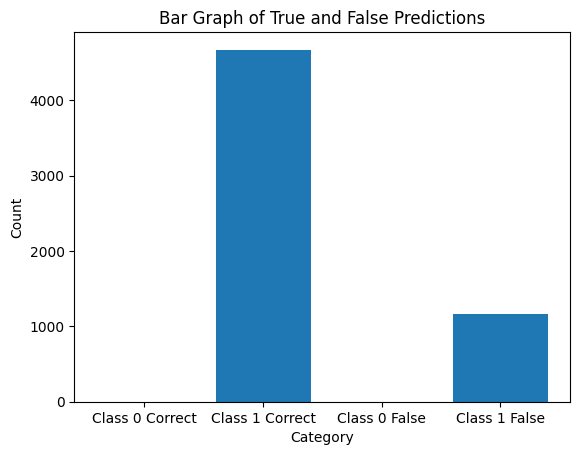

Accuracy : 0.8002740664611169
Precision : 0.40013703323055844
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4445290199809705
AUC-ROC : 0.5
Confusion Matrix : [[   0 1166]
 [   0 4672]]
0.01 0.3
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


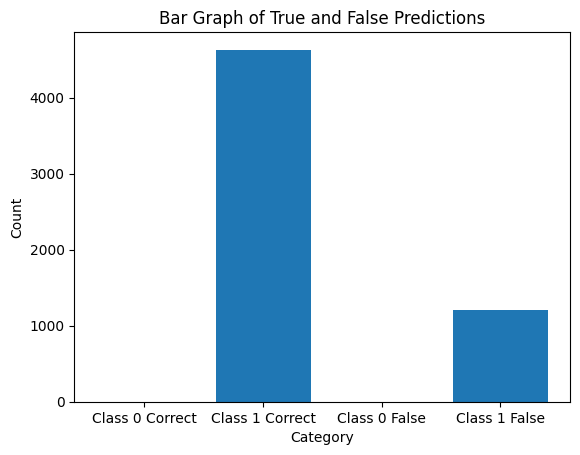

Accuracy : 0.7932511133949983
Precision : 0.39662555669749916
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4423536154360493
AUC-ROC : 0.5
Confusion Matrix : [[   0 1207]
 [   0 4631]]
0.01 0.35
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


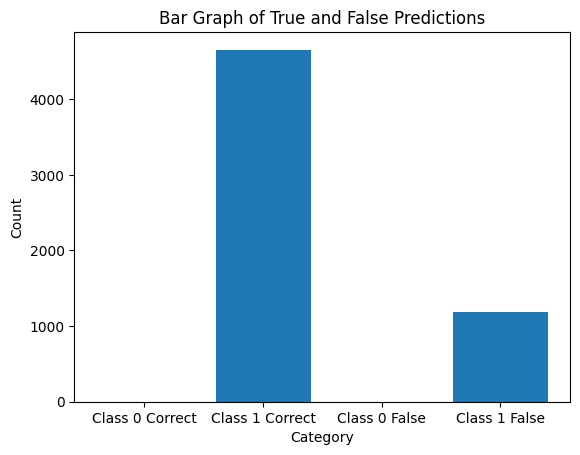

Accuracy : 0.7971908187735526
Precision : 0.3985954093867763
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44357605794891347
AUC-ROC : 0.5
Confusion Matrix : [[   0 1184]
 [   0 4654]]
0.01 0.39999999999999997
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


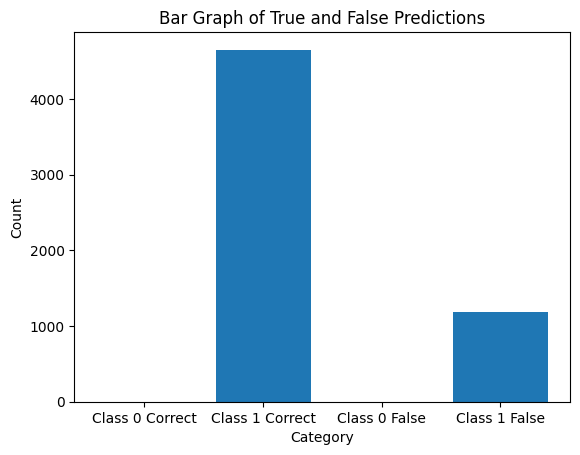

Accuracy : 0.7970195272353545
Precision : 0.39850976361767726
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4435230197311981
AUC-ROC : 0.5
Confusion Matrix : [[   0 1185]
 [   0 4653]]
0.01 0.44999999999999996
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


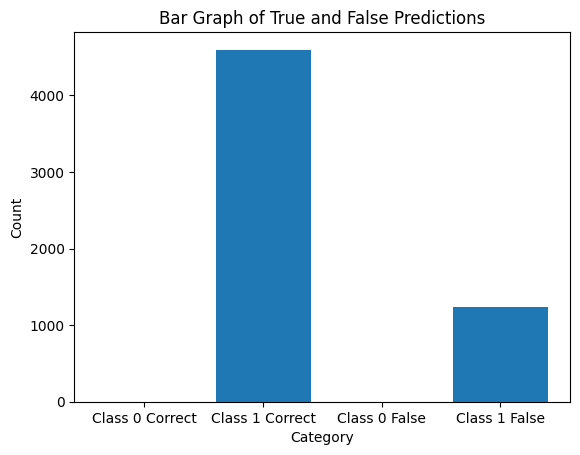

Accuracy : 0.7872559095580678
Precision : 0.3936279547790339
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44048303622771706
AUC-ROC : 0.5
Confusion Matrix : [[   0 1242]
 [   0 4596]]
0.01 0.49999999999999994
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


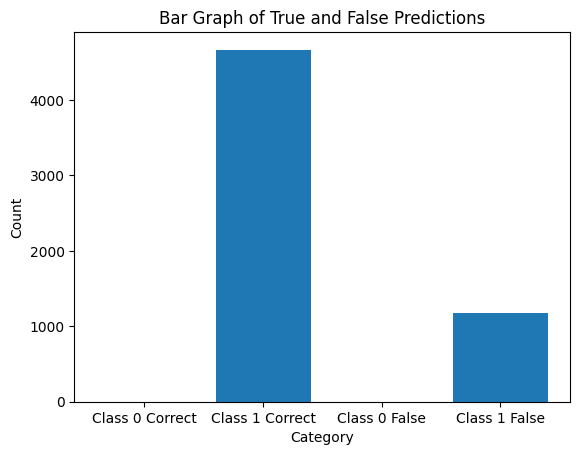

Accuracy : 0.7992463172319287
Precision : 0.39962315861596437
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44421172886519417
AUC-ROC : 0.5
Confusion Matrix : [[   0 1172]
 [   0 4666]]
0.01 0.5499999999999999
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


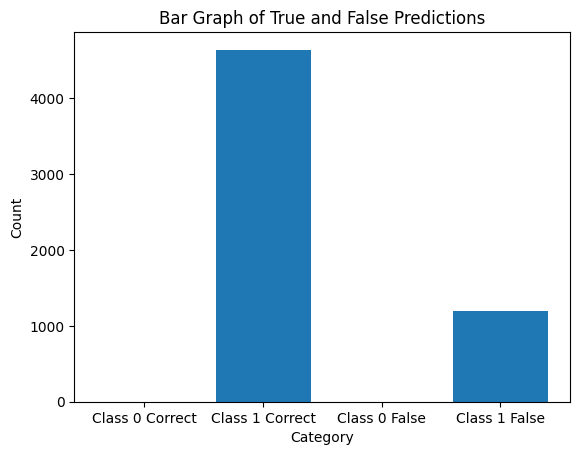

Accuracy : 0.7949640287769785
Precision : 0.39748201438848924
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4428857715430862
AUC-ROC : 0.5
Confusion Matrix : [[   0 1197]
 [   0 4641]]
0.01 0.6
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


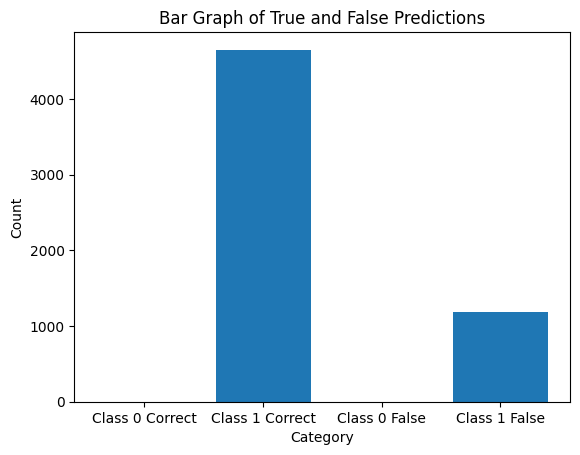

Accuracy : 0.7965056526207606
Precision : 0.3982528263103803
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44336384439359267
AUC-ROC : 0.5
Confusion Matrix : [[   0 1188]
 [   0 4650]]
0.01 0.65
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


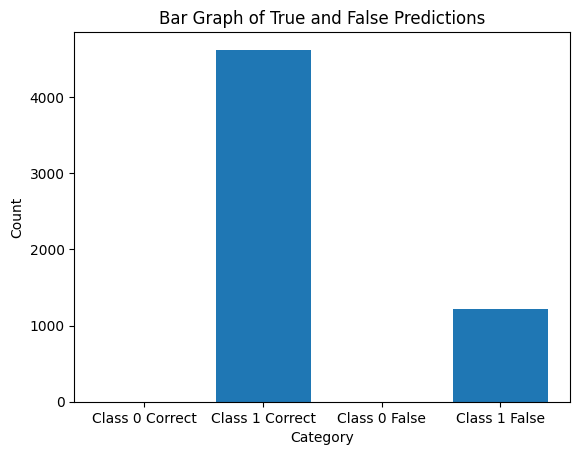

Accuracy : 0.7915381980130182
Precision : 0.3957690990065091
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4418204417248303
AUC-ROC : 0.5
Confusion Matrix : [[   0 1217]
 [   0 4621]]
0.01 0.7000000000000001
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


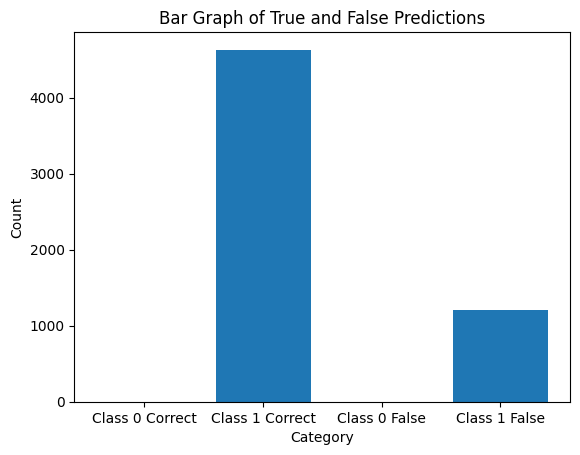

Accuracy : 0.7934224049331963
Precision : 0.39671120246659813
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4424068767908309
AUC-ROC : 0.5
Confusion Matrix : [[   0 1206]
 [   0 4632]]
0.01 0.7500000000000001
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


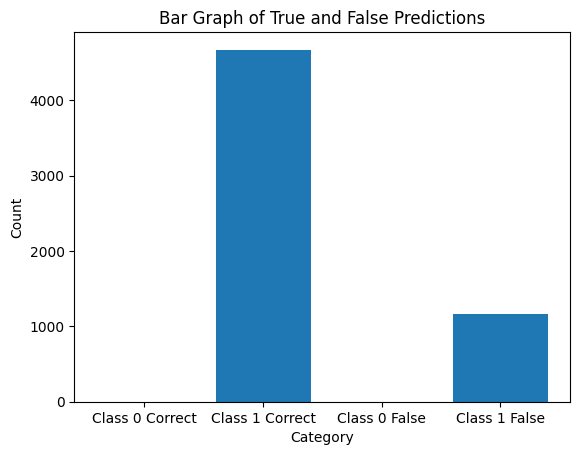

Accuracy : 0.8001027749229188
Precision : 0.4000513874614594
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4444761632886098
AUC-ROC : 0.5
Confusion Matrix : [[   0 1167]
 [   0 4671]]
0.01 0.8000000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


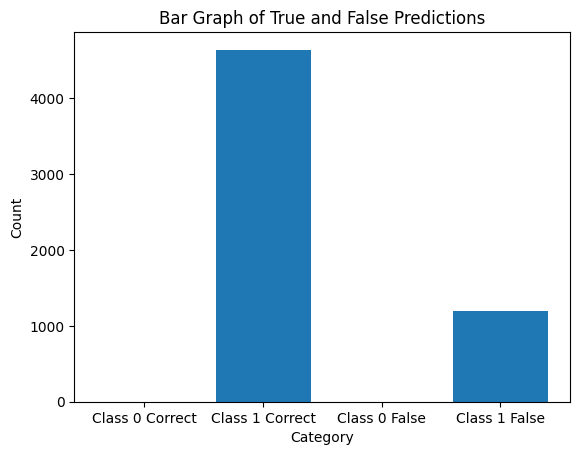

Accuracy : 0.7944501541623844
Precision : 0.3972250770811922
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4427262313860252
AUC-ROC : 0.5
Confusion Matrix : [[   0 1200]
 [   0 4638]]
0.01 0.8500000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


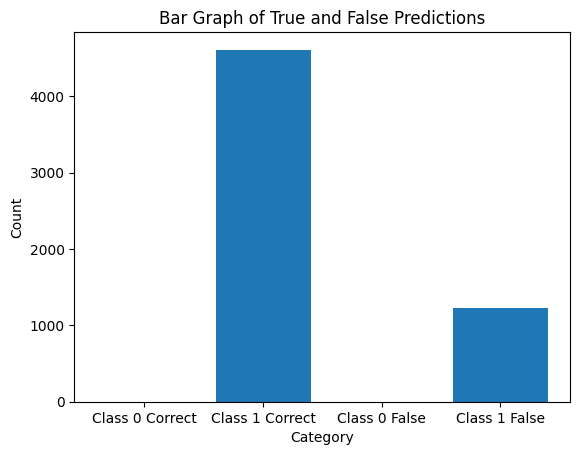

Accuracy : 0.789311408016444
Precision : 0.394655704008222
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4411257897759908
AUC-ROC : 0.5
Confusion Matrix : [[   0 1230]
 [   0 4608]]
0.01 0.9000000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


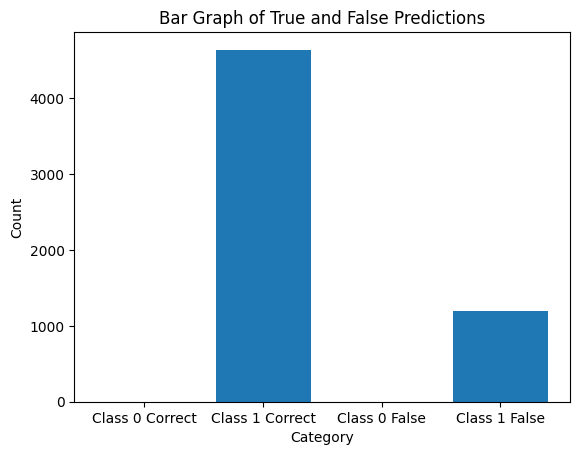

Accuracy : 0.7942788626241863
Precision : 0.39713943131209317
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.442673031026253
AUC-ROC : 0.5
Confusion Matrix : [[   0 1201]
 [   0 4637]]
0.01 0.9500000000000003
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


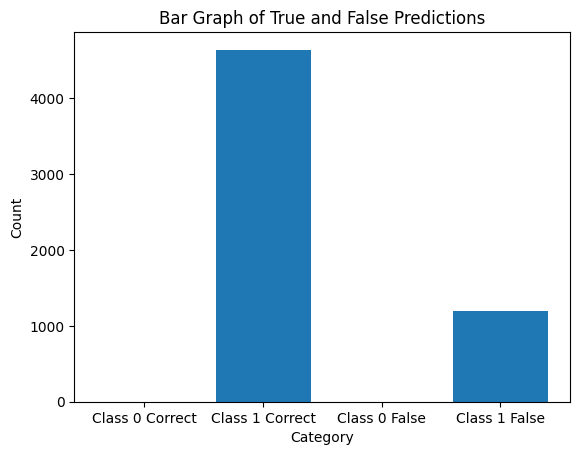

Accuracy : 0.7947927372387804
Precision : 0.3973963686193902
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44283260164153465
AUC-ROC : 0.5
Confusion Matrix : [[   0 1198]
 [   0 4640]]
0.1 0.2
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


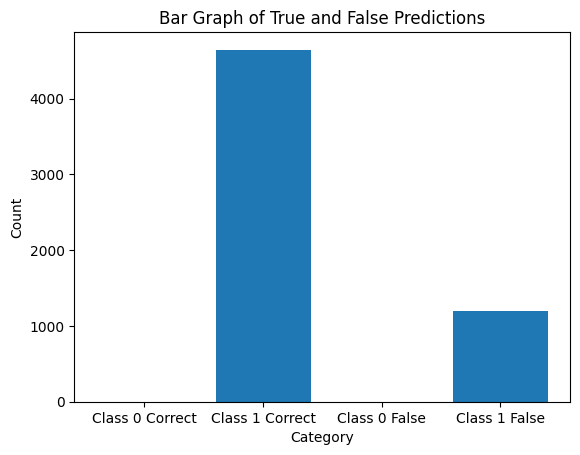

Accuracy : 0.7958204864679684
Precision : 0.3979102432339842
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44315146890499807
AUC-ROC : 0.5
Confusion Matrix : [[   0 1192]
 [   0 4646]]
0.1 0.25
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


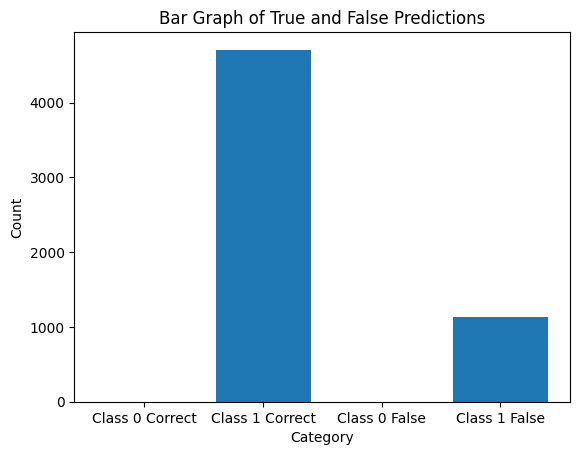

Accuracy : 0.8060979787598492
Precision : 0.4030489893799246
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4463201820940819
AUC-ROC : 0.5
Confusion Matrix : [[   0 1132]
 [   0 4706]]
0.1 0.3
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


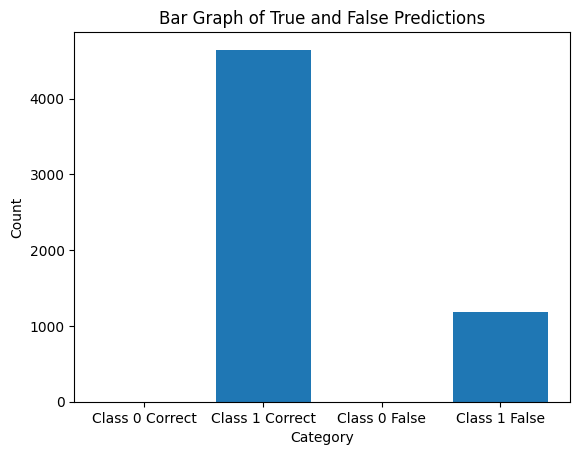

Accuracy : 0.7959917780061665
Precision : 0.39799588900308325
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44320457796852647
AUC-ROC : 0.5
Confusion Matrix : [[   0 1191]
 [   0 4647]]
0.1 0.35
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


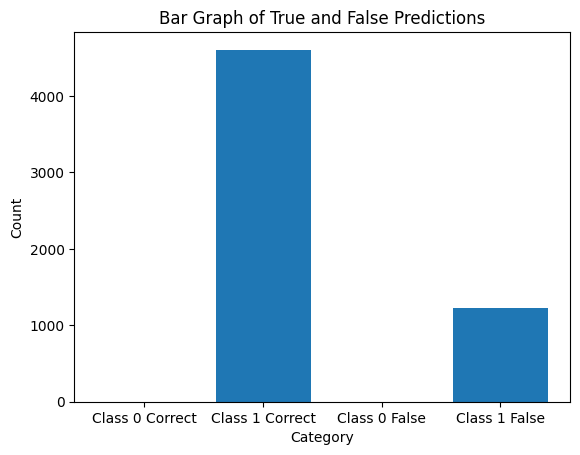

Accuracy : 0.7889688249400479
Precision : 0.39448441247002397
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4410187667560322
AUC-ROC : 0.5
Confusion Matrix : [[   0 1232]
 [   0 4606]]
0.1 0.39999999999999997
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


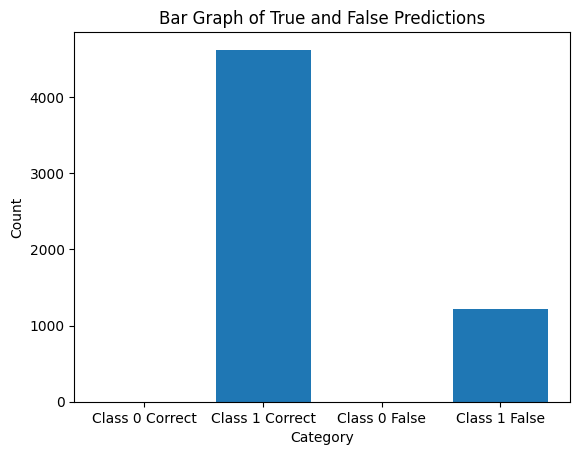

Accuracy : 0.7920520726276122
Precision : 0.3960260363138061
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44198050086025614
AUC-ROC : 0.5
Confusion Matrix : [[   0 1214]
 [   0 4624]]
0.1 0.44999999999999996
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


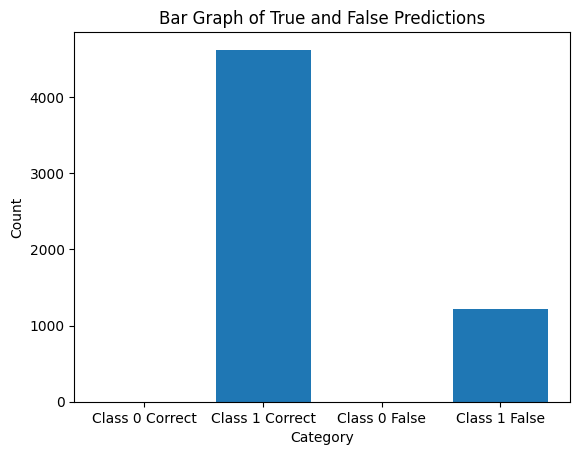

Accuracy : 0.7917094895512161
Precision : 0.39585474477560806
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44187380497131934
AUC-ROC : 0.5
Confusion Matrix : [[   0 1216]
 [   0 4622]]
0.1 0.49999999999999994
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


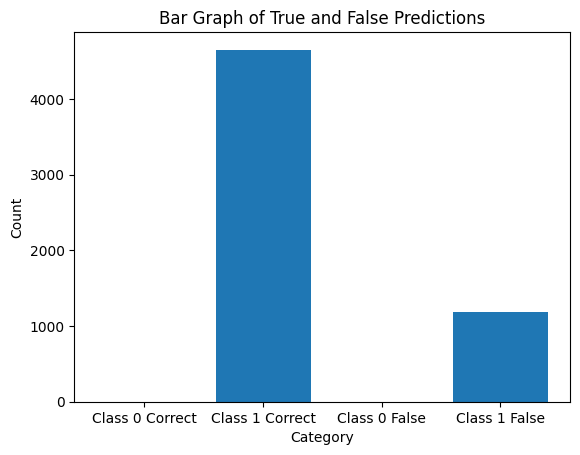

Accuracy : 0.7970195272353545
Precision : 0.39850976361767726
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4435230197311981
AUC-ROC : 0.5
Confusion Matrix : [[   0 1185]
 [   0 4653]]
0.1 0.5499999999999999
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


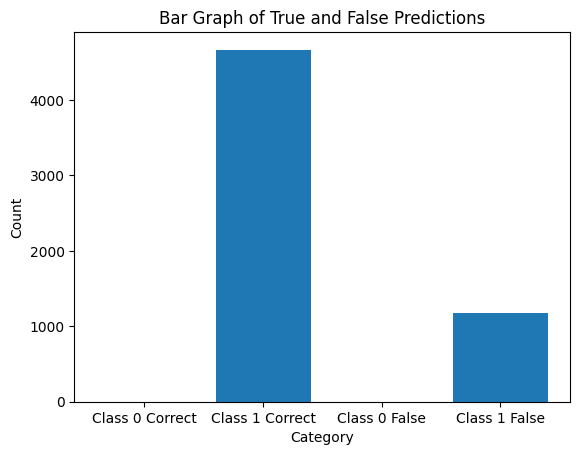

Accuracy : 0.7994176087701268
Precision : 0.3997088043850634
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44426463588767257
AUC-ROC : 0.5
Confusion Matrix : [[   0 1171]
 [   0 4667]]
0.1 0.6
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


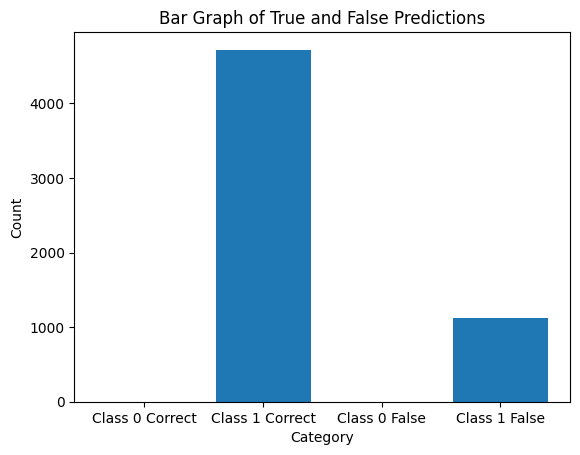

Accuracy : 0.8083247687564235
Precision : 0.4041623843782117
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4470019892014777
AUC-ROC : 0.5
Confusion Matrix : [[   0 1119]
 [   0 4719]]
0.1 0.65
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


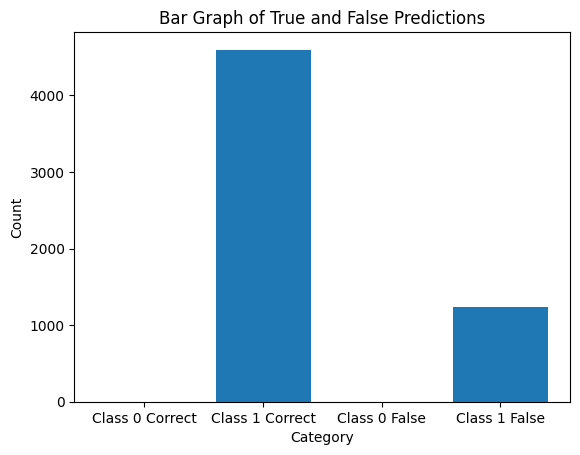

Accuracy : 0.7870846180198698
Precision : 0.3935423090099349
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4404294066903096
AUC-ROC : 0.5
Confusion Matrix : [[   0 1243]
 [   0 4595]]
0.1 0.7000000000000001
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


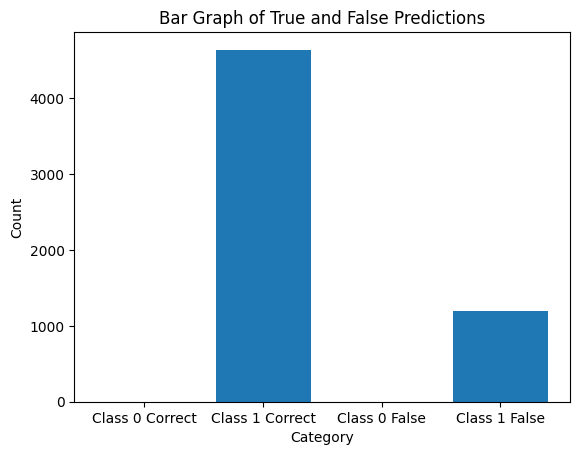

Accuracy : 0.7951353203151764
Precision : 0.3975676601575882
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44293893129770995
AUC-ROC : 0.5
Confusion Matrix : [[   0 1196]
 [   0 4642]]
0.1 0.7500000000000001
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


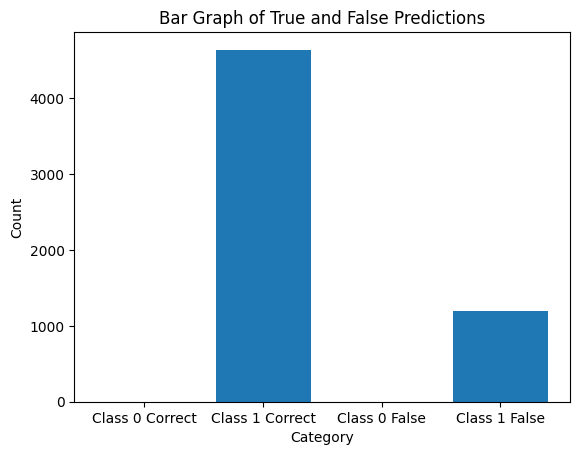

Accuracy : 0.7951353203151764
Precision : 0.3975676601575882
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44293893129770995
AUC-ROC : 0.5
Confusion Matrix : [[   0 1196]
 [   0 4642]]
0.1 0.8000000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


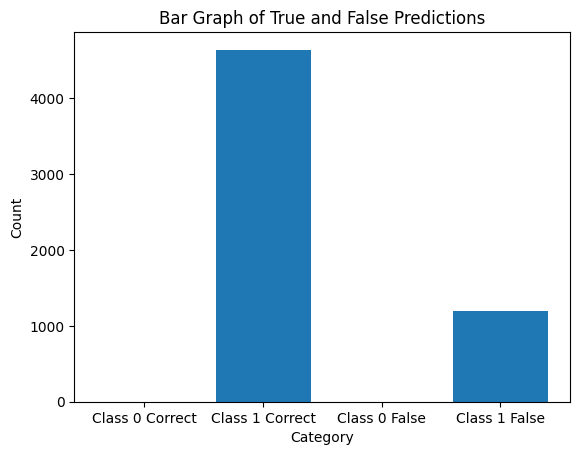

Accuracy : 0.7951353203151764
Precision : 0.3975676601575882
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44293893129770995
AUC-ROC : 0.5
Confusion Matrix : [[   0 1196]
 [   0 4642]]
0.1 0.8500000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


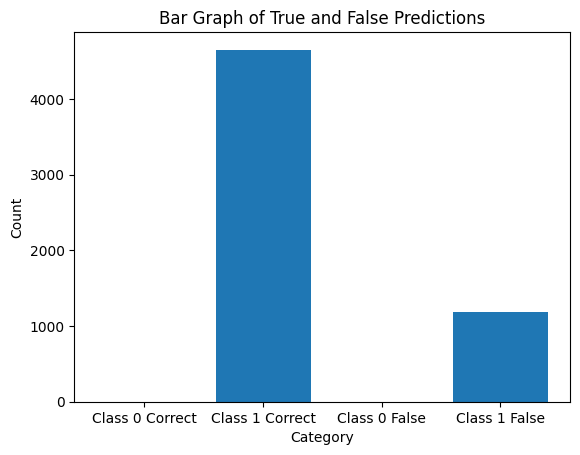

Accuracy : 0.7968482356971566
Precision : 0.3984241178485783
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4434699714013346
AUC-ROC : 0.5
Confusion Matrix : [[   0 1186]
 [   0 4652]]
0.1 0.9000000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


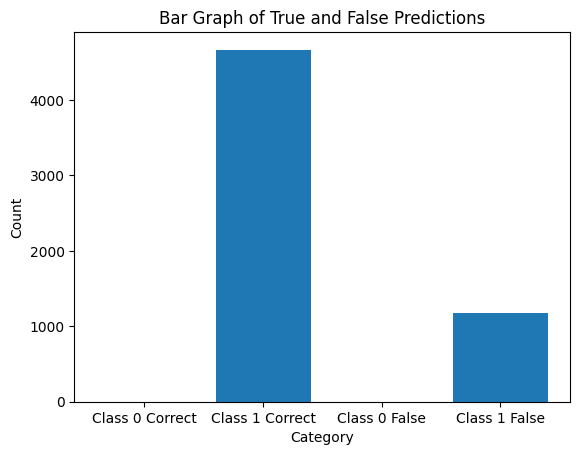

Accuracy : 0.7994176087701268
Precision : 0.3997088043850634
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44426463588767257
AUC-ROC : 0.5
Confusion Matrix : [[   0 1171]
 [   0 4667]]
0.1 0.9500000000000003
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


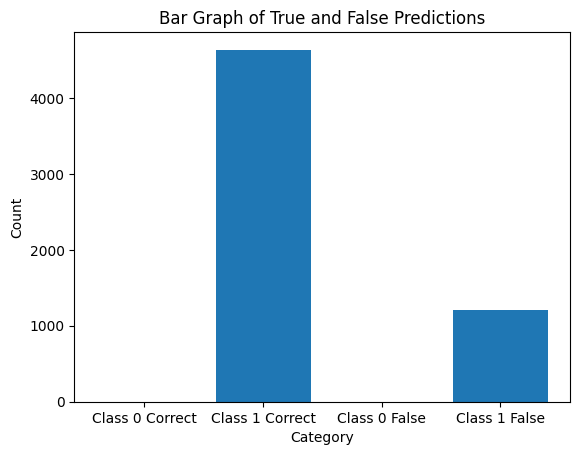

Accuracy : 0.7939362795477903
Precision : 0.39696813977389517
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4425665998281295
AUC-ROC : 0.5
Confusion Matrix : [[   0 1203]
 [   0 4635]]
0.15 0.2
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


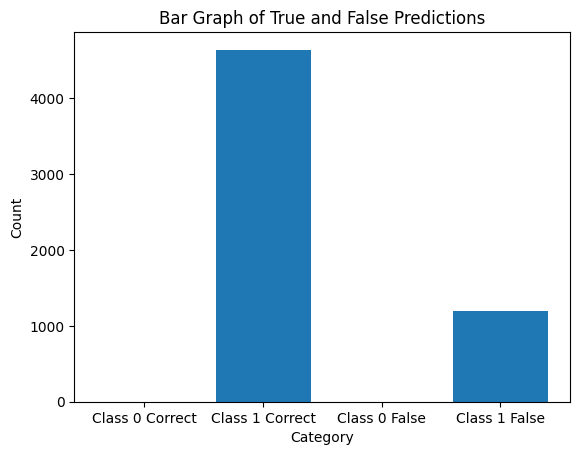

Accuracy : 0.7953066118533745
Precision : 0.39765330592668724
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44299208090831027
AUC-ROC : 0.5
Confusion Matrix : [[   0 1195]
 [   0 4643]]
0.15 0.25
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


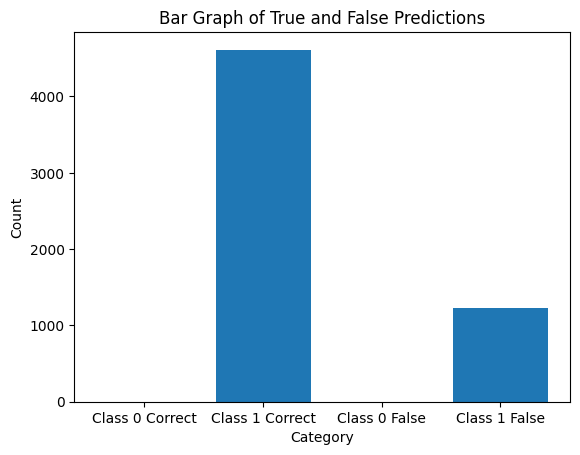

Accuracy : 0.790167865707434
Precision : 0.395083932853717
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4413931681178834
AUC-ROC : 0.5
Confusion Matrix : [[   0 1225]
 [   0 4613]]
0.15 0.3
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


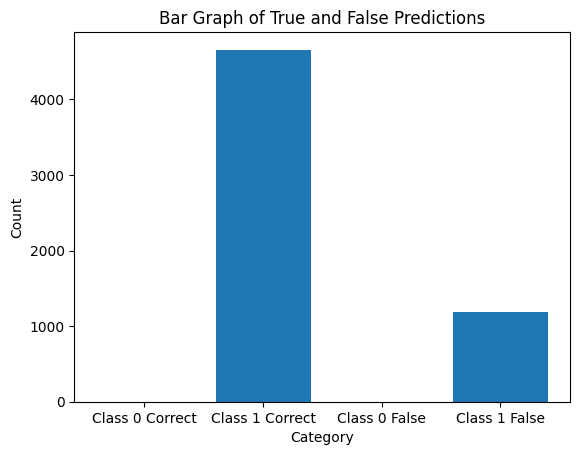

Accuracy : 0.7977046933881466
Precision : 0.3988523466940733
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4437351119580753
AUC-ROC : 0.5
Confusion Matrix : [[   0 1181]
 [   0 4657]]
0.15 0.35
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


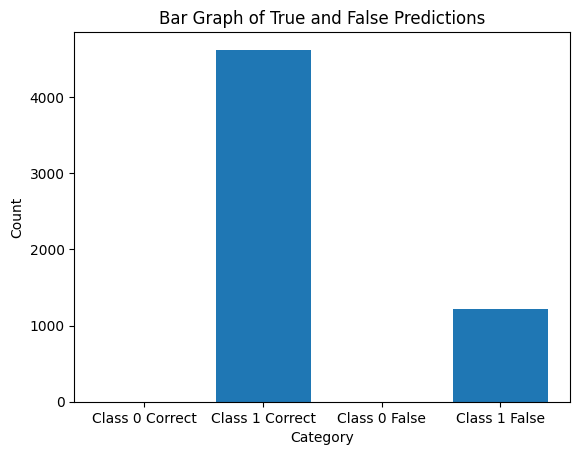

Accuracy : 0.7918807810894142
Precision : 0.3959403905447071
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4419271580154861
AUC-ROC : 0.5
Confusion Matrix : [[   0 1215]
 [   0 4623]]
0.15 0.39999999999999997
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


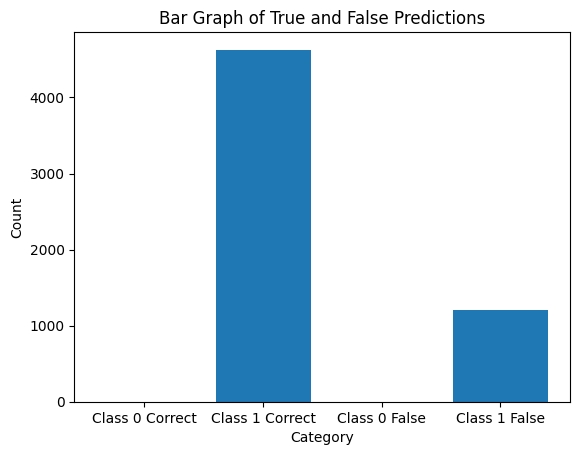

Accuracy : 0.7927372387804043
Precision : 0.3963686193902021
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44219377030384105
AUC-ROC : 0.5
Confusion Matrix : [[   0 1210]
 [   0 4628]]
0.15 0.44999999999999996
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


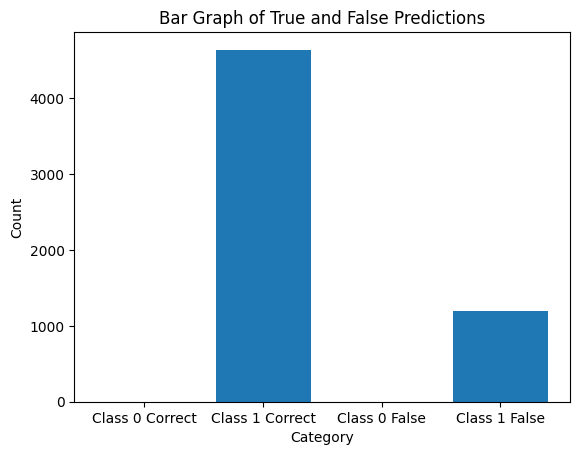

Accuracy : 0.7947927372387804
Precision : 0.3973963686193902
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44283260164153465
AUC-ROC : 0.5
Confusion Matrix : [[   0 1198]
 [   0 4640]]
0.15 0.49999999999999994
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


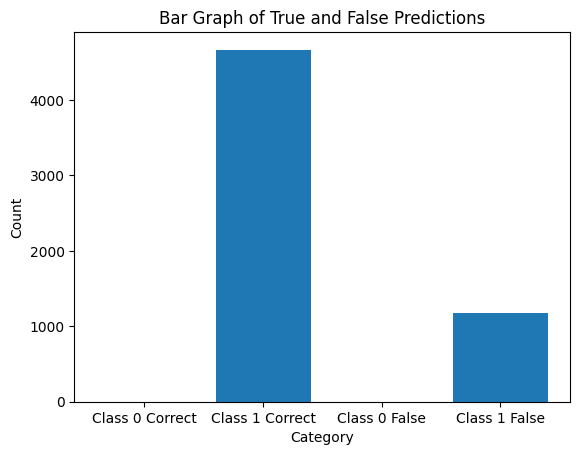

Accuracy : 0.7994176087701268
Precision : 0.3997088043850634
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44426463588767257
AUC-ROC : 0.5
Confusion Matrix : [[   0 1171]
 [   0 4667]]
0.15 0.5499999999999999
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


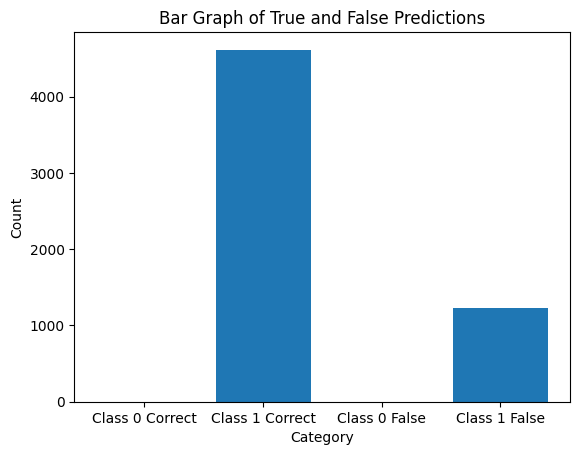

Accuracy : 0.79051044878383
Precision : 0.395255224391915
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44150004783315794
AUC-ROC : 0.5
Confusion Matrix : [[   0 1223]
 [   0 4615]]
0.15 0.6
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


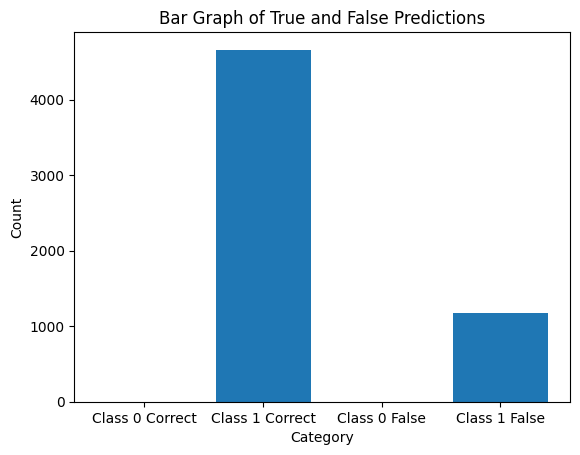

Accuracy : 0.7980472764645427
Precision : 0.3990236382322713
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4438410974564161
AUC-ROC : 0.5
Confusion Matrix : [[   0 1179]
 [   0 4659]]
0.15 0.65
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


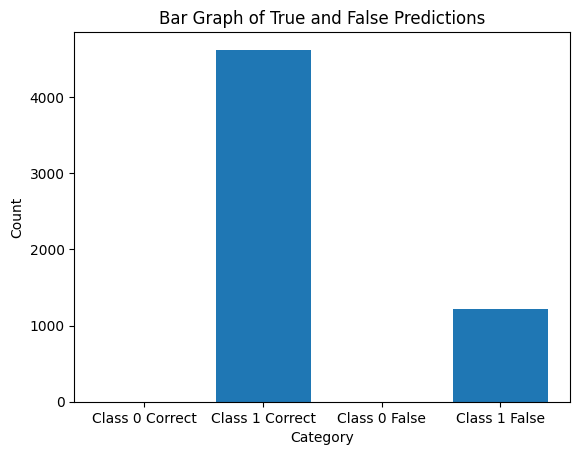

Accuracy : 0.7915381980130182
Precision : 0.3957690990065091
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4418204417248303
AUC-ROC : 0.5
Confusion Matrix : [[   0 1217]
 [   0 4621]]
0.15 0.7000000000000001
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


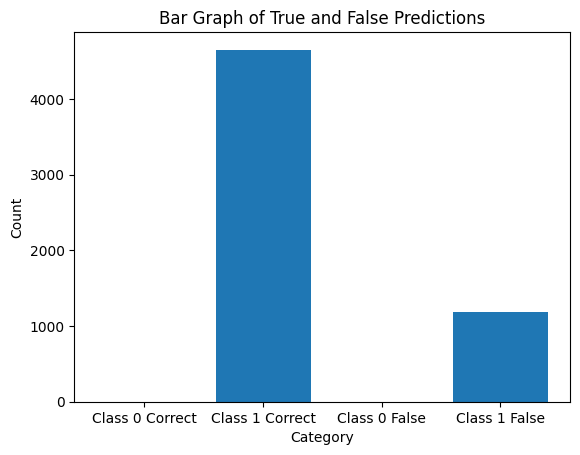

Accuracy : 0.7961630695443646
Precision : 0.3980815347721823
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44325767690253676
AUC-ROC : 0.5
Confusion Matrix : [[   0 1190]
 [   0 4648]]
0.15 0.7500000000000001
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


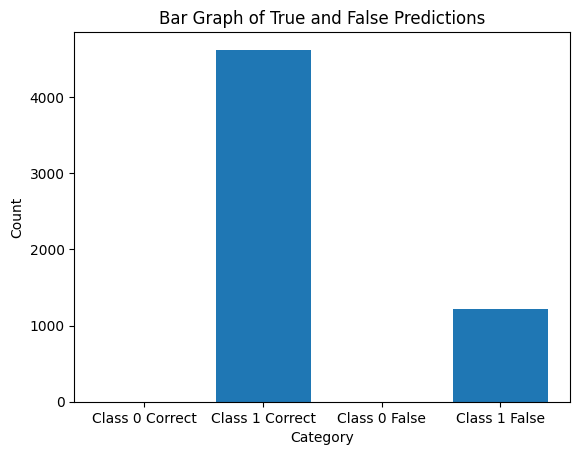

Accuracy : 0.7917094895512161
Precision : 0.39585474477560806
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44187380497131934
AUC-ROC : 0.5
Confusion Matrix : [[   0 1216]
 [   0 4622]]
0.15 0.8000000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


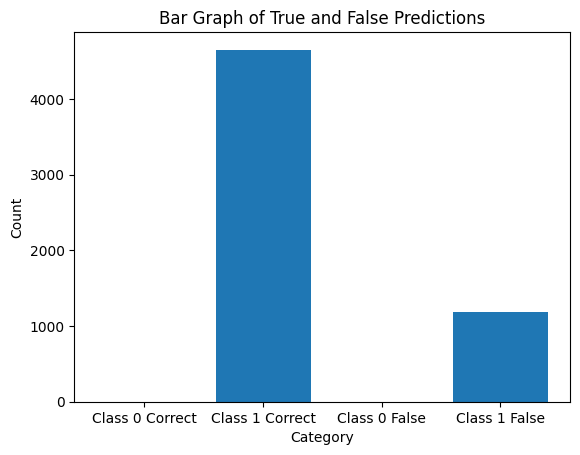

Accuracy : 0.7970195272353545
Precision : 0.39850976361767726
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4435230197311981
AUC-ROC : 0.5
Confusion Matrix : [[   0 1185]
 [   0 4653]]
0.15 0.8500000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


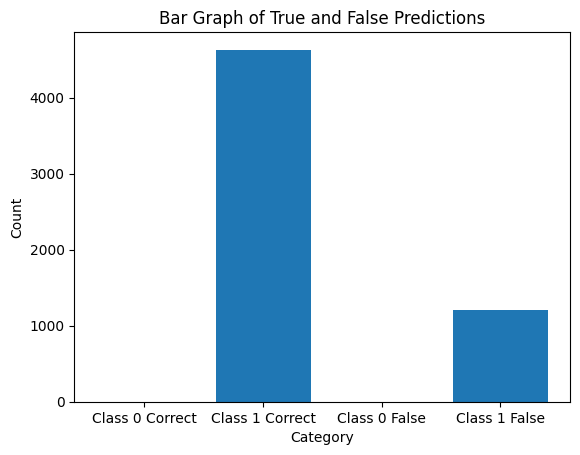

Accuracy : 0.7932511133949983
Precision : 0.39662555669749916
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.4423536154360493
AUC-ROC : 0.5
Confusion Matrix : [[   0 1207]
 [   0 4631]]
0.15 0.9000000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.795916265347936


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


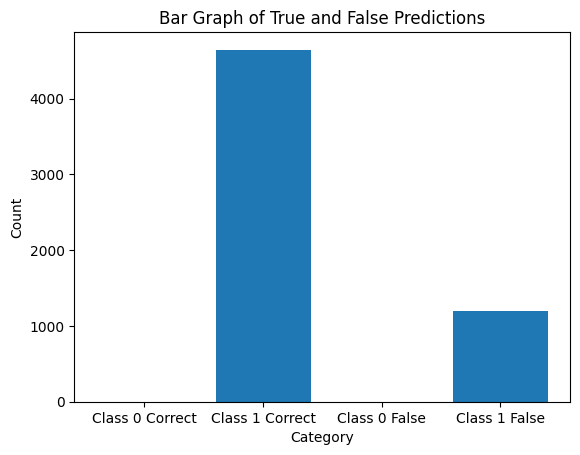

Accuracy : 0.7958204864679684
Precision : 0.3979102432339842
Recall : 0.5
True Negatives : 0.0000
F1 Score (Macro) : 0.44315146890499807
AUC-ROC : 0.5
Confusion Matrix : [[   0 1192]
 [   0 4646]]
0.15 0.9500000000000003
0.001 0.2


In [225]:
C1_params = {
    'C': [1.0, 2.0, 3.0, 4.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
dfmin, dfmax = findBest(C1_params, cutoff1, '1', 3.0, 'l2', 'liblinear')
print(dfmin, dfmax)

Best Hyperparameters: {'C': 3.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8686833230006709


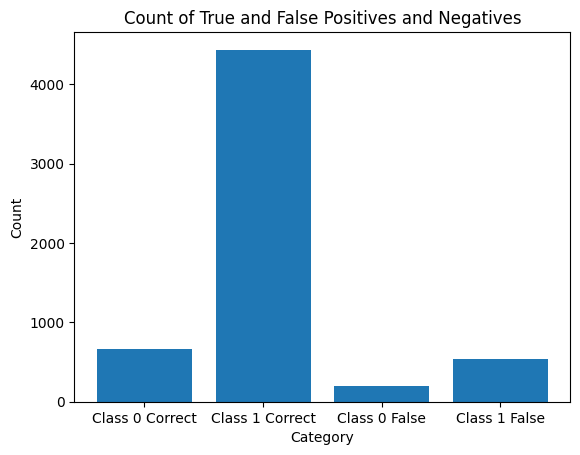

Accuracy : 0.8730729701952723
Precision : 0.8296149633499031
Recall : 0.7528968652928685
True Negatives : 659.0000
F1 Score (Macro) : 0.7815327530074511
AUC-ROC : 0.7528968652928683
Confusion Matrix : [[ 659  542]
 [ 199 4438]]


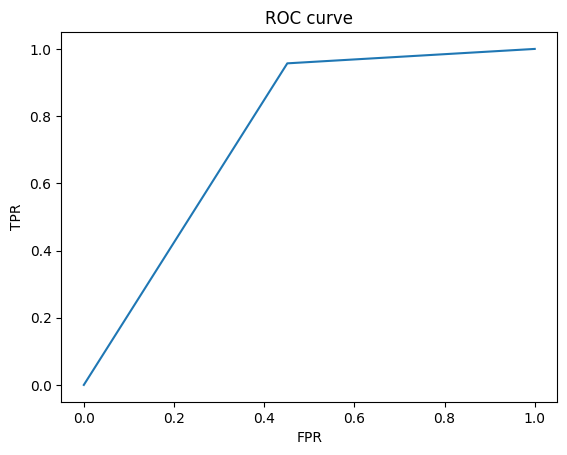

In [264]:
# Execution of the optimal parameters
x_training, x_testing = Vectorize((1,3), 0.0, 0.3, 10000)

linear_regression(C1_params, cutoff1, '1', 3.0, 'l2', 'liblinear')

Cutoff = 2

Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


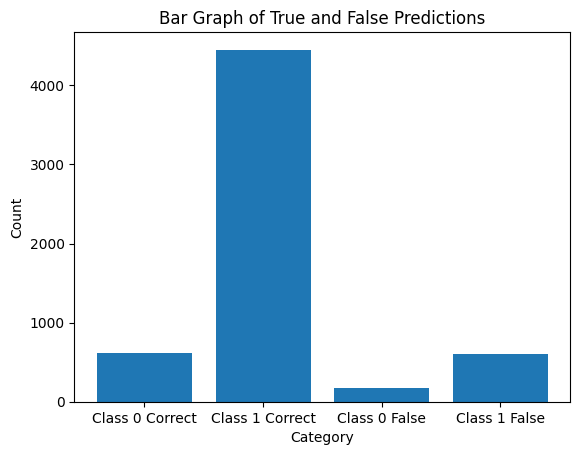

Accuracy : 0.868276807125728
Precision : 0.8325407731348673
Recall : 0.7358113979675864
True Negatives : 619.0000
F1 Score (Macro) : 0.7686542648357185
AUC-ROC : 0.7358113979675864
Confusion Matrix : [[ 619  598]
 [ 171 4450]]
0.001 0.2
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


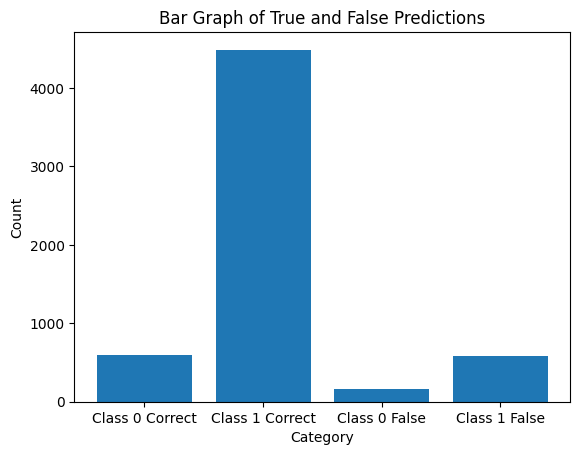

Accuracy : 0.8715313463514902
Precision : 0.833519769625487
Recall : 0.7354502459574023
True Negatives : 599.0000
F1 Score (Macro) : 0.7689463467929321
AUC-ROC : 0.7354502459574023
Confusion Matrix : [[ 599  583]
 [ 167 4489]]
0.001 0.25
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


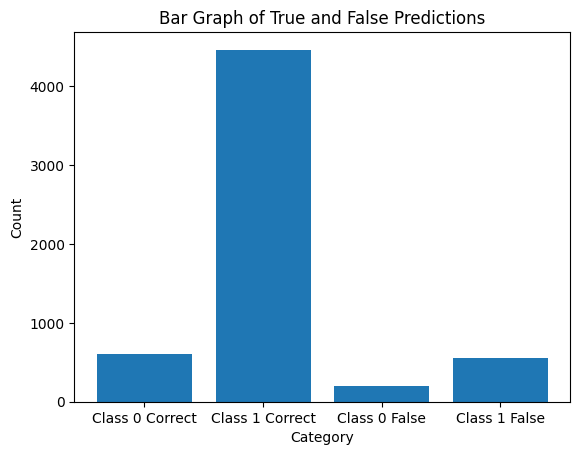

Accuracy : 0.869475847893114
Precision : 0.8187881756191457
Recall : 0.7394099896588864
True Negatives : 610.0000
F1 Score (Macro) : 0.7684672679242124
AUC-ROC : 0.7394099896588864
Confusion Matrix : [[ 610  557]
 [ 205 4466]]
0.001 0.3
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


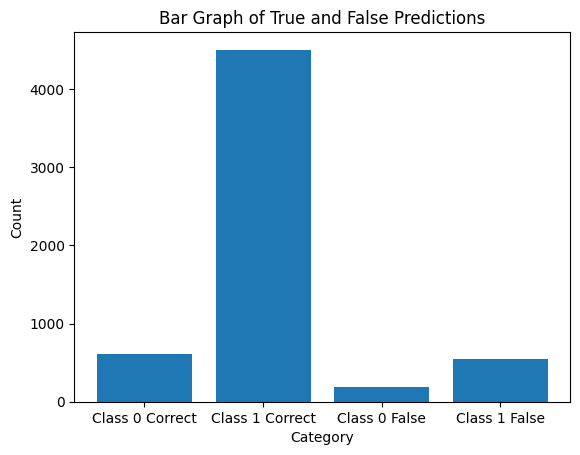

Accuracy : 0.8747858855772525
Precision : 0.8287099584196207
Recall : 0.7436085102788448
True Negatives : 607.0000
F1 Score (Macro) : 0.7745218881485216
AUC-ROC : 0.7436085102788448
Confusion Matrix : [[ 607  545]
 [ 186 4500]]
0.001 0.35
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


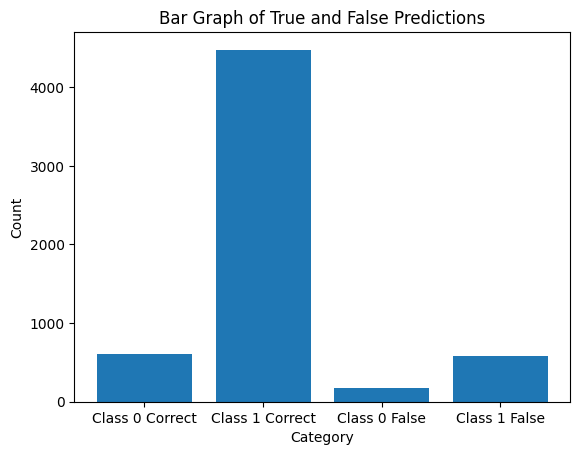

Accuracy : 0.8701610140459062
Precision : 0.8307474430464304
Recall : 0.7351857282502443
True Negatives : 603.0000
F1 Score (Macro) : 0.7680025886047706
AUC-ROC : 0.7351857282502444
Confusion Matrix : [[ 603  585]
 [ 173 4477]]
0.001 0.39999999999999997
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


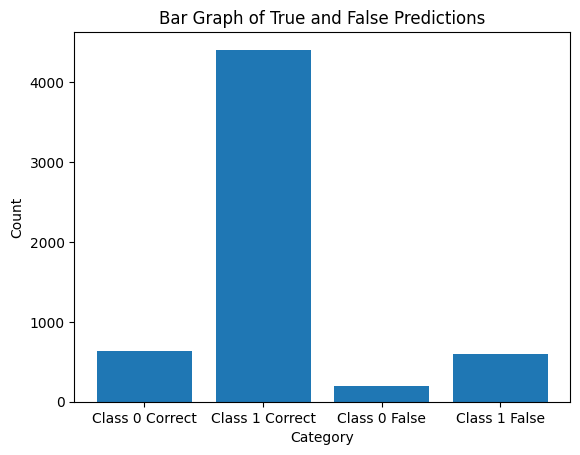

Accuracy : 0.8633093525179856
Precision : 0.8220502011842569
Recall : 0.7341987870458639
True Negatives : 630.0000
F1 Score (Macro) : 0.7646377328223867
AUC-ROC : 0.7341987870458638
Confusion Matrix : [[ 630  604]
 [ 194 4410]]
0.001 0.44999999999999996
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


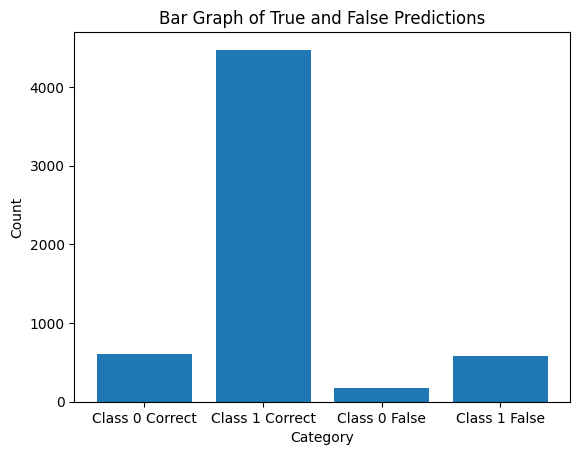

Accuracy : 0.8698184309695101
Precision : 0.8293075025296451
Recall : 0.7357996447321933
True Negatives : 606.0000
F1 Score (Macro) : 0.7681431215918155
AUC-ROC : 0.7357996447321933
Confusion Matrix : [[ 606  583]
 [ 177 4472]]
0.001 0.49999999999999994
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


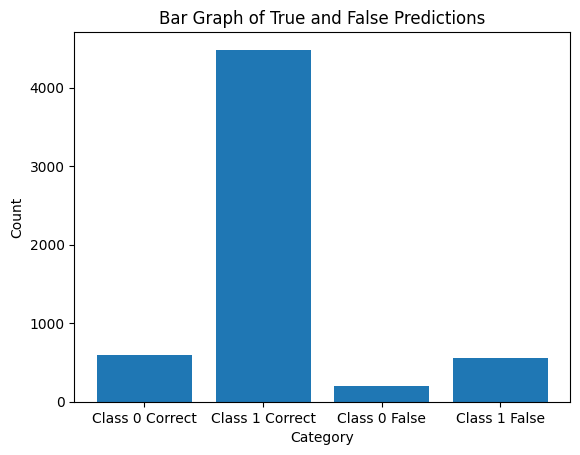

Accuracy : 0.8708461801986982
Precision : 0.8211645684807415
Recall : 0.7382487582435255
True Negatives : 600.0000
F1 Score (Macro) : 0.7682844068165628
AUC-ROC : 0.7382487582435254
Confusion Matrix : [[ 600  557]
 [ 197 4484]]
0.001 0.5499999999999999
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


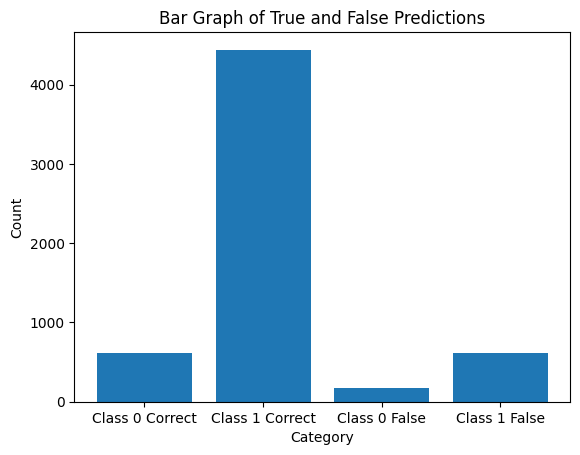

Accuracy : 0.8655361425145598
Precision : 0.8304855187121629
Recall : 0.730954573919388
True Negatives : 612.0000
F1 Score (Macro) : 0.7640271205354328
AUC-ROC : 0.730954573919388
Confusion Matrix : [[ 612  615]
 [ 170 4441]]
0.001 0.6
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


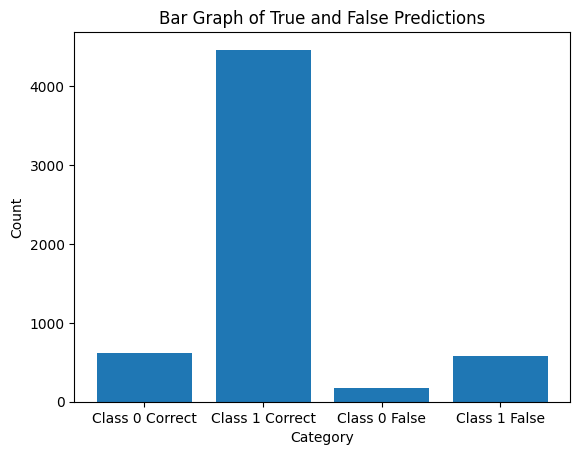

Accuracy : 0.8710174717368961
Precision : 0.834534489757035
Recall : 0.7391527494440528
True Negatives : 619.0000
F1 Score (Macro) : 0.7720244974351541
AUC-ROC : 0.7391527494440528
Confusion Matrix : [[ 619  583]
 [ 170 4466]]
0.001 0.65
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


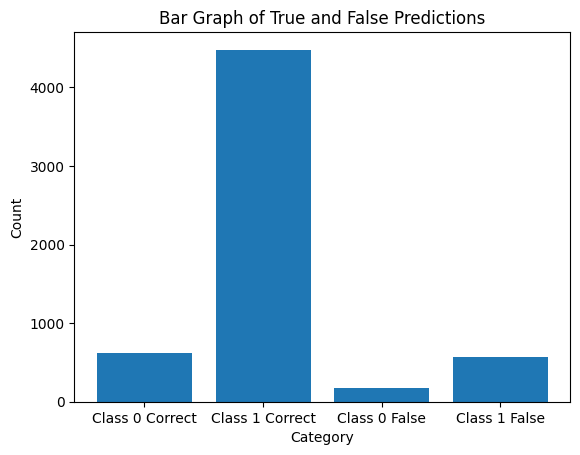

Accuracy : 0.8729016786570744
Precision : 0.8329338600764619
Recall : 0.7418732799877971
True Negatives : 617.0000
F1 Score (Macro) : 0.7739995408823407
AUC-ROC : 0.7418732799877971
Confusion Matrix : [[ 617  566]
 [ 176 4479]]
0.001 0.7000000000000001
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


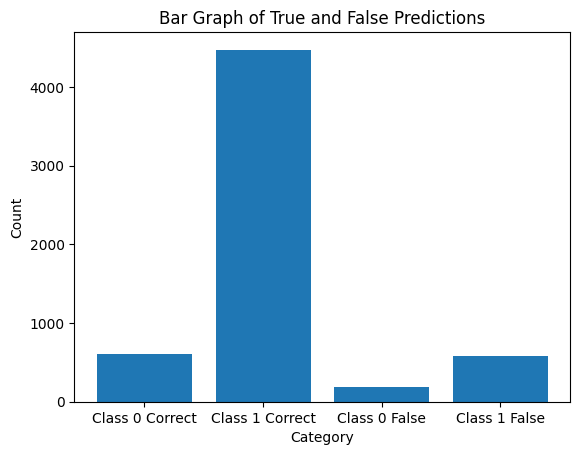

Accuracy : 0.868790681740322
Precision : 0.8228352600598621
Recall : 0.7349282181525072
True Negatives : 601.0000
F1 Score (Macro) : 0.7659341805099139
AUC-ROC : 0.7349282181525072
Confusion Matrix : [[ 601  576]
 [ 190 4471]]
0.001 0.7500000000000001
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


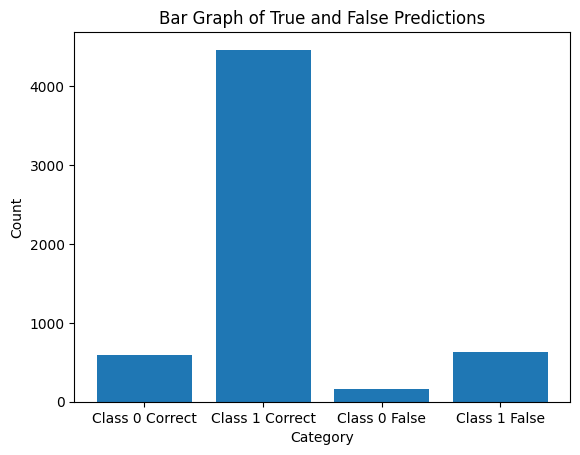

Accuracy : 0.8646796848235697
Precision : 0.8295847925615631
Recall : 0.7239282547180321
True Negatives : 586.0000
F1 Score (Macro) : 0.7580118609352875
AUC-ROC : 0.7239282547180321
Confusion Matrix : [[ 586  627]
 [ 163 4462]]
0.001 0.8000000000000002
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


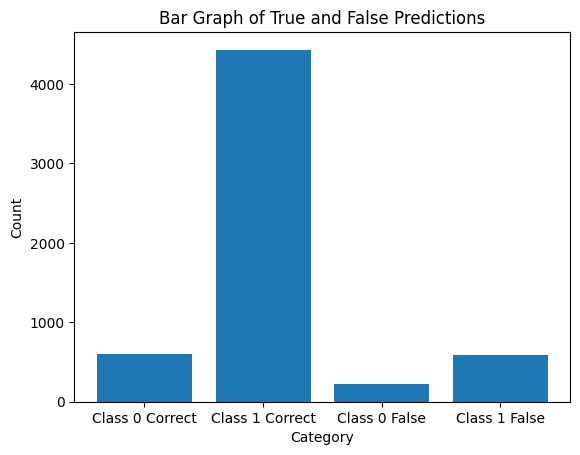

Accuracy : 0.8610825625214115
Precision : 0.8058417960971724
Recall : 0.7273067328278747
True Negatives : 595.0000
F1 Score (Macro) : 0.7554391796349886
AUC-ROC : 0.7273067328278747
Confusion Matrix : [[ 595  590]
 [ 221 4432]]
0.001 0.8500000000000002
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


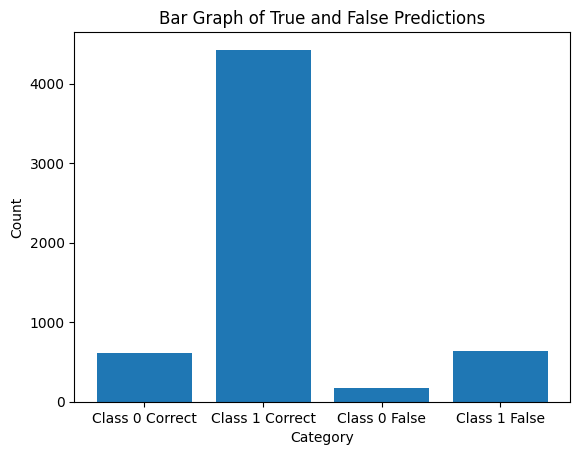

Accuracy : 0.8621103117505995
Precision : 0.8275832975764033
Recall : 0.726163372476802
True Negatives : 608.0000
F1 Score (Macro) : 0.7591529233058069
AUC-ROC : 0.726163372476802
Confusion Matrix : [[ 608  634]
 [ 171 4425]]
0.001 0.9000000000000002
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


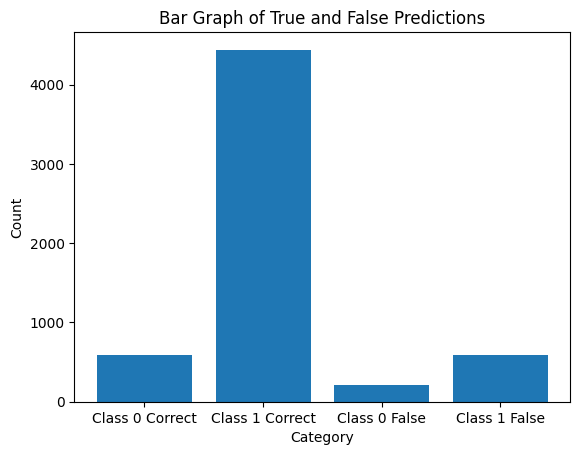

Accuracy : 0.8617677286742035
Precision : 0.8072240338545706
Recall : 0.7271197472395207
True Negatives : 592.0000
F1 Score (Macro) : 0.7556756566137708
AUC-ROC : 0.7271197472395206
Confusion Matrix : [[ 592  590]
 [ 217 4439]]
0.001 0.9500000000000003
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


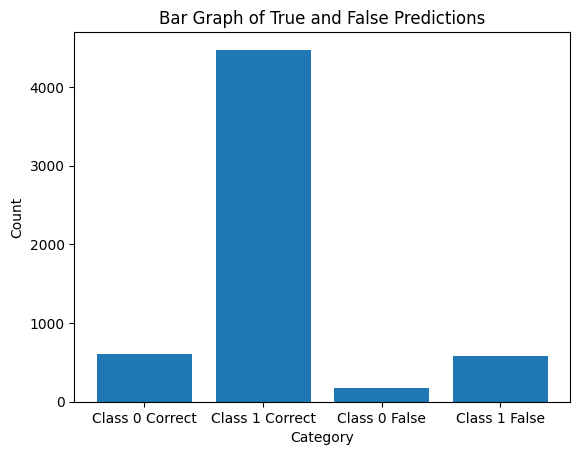

Accuracy : 0.8699897225077081
Precision : 0.8313253977154391
Recall : 0.7352646210783903
True Negatives : 605.0000
F1 Score (Macro) : 0.7681670717382434
AUC-ROC : 0.7352646210783903
Confusion Matrix : [[ 605  587]
 [ 172 4474]]
0.01 0.2
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


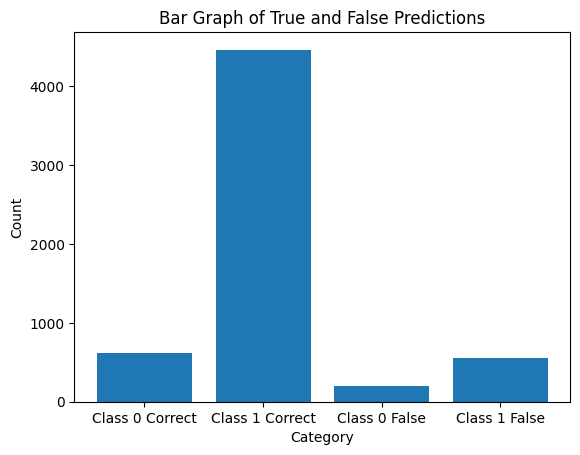

Accuracy : 0.8696471394313121
Precision : 0.8200571895424836
Recall : 0.739993654229041
True Negatives : 613.0000
F1 Score (Macro) : 0.769233945716826
AUC-ROC : 0.7399936542290408
Confusion Matrix : [[ 613  558]
 [ 203 4464]]
0.01 0.25
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


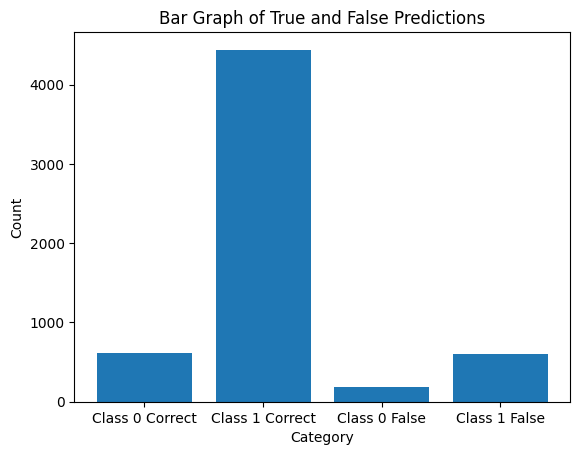

Accuracy : 0.8653648509763617
Precision : 0.8232722540911079
Recall : 0.7320758600837207
True Negatives : 610.0000
F1 Score (Macro) : 0.7634465785683281
AUC-ROC : 0.7320758600837207
Confusion Matrix : [[ 610  599]
 [ 187 4442]]
0.01 0.3
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


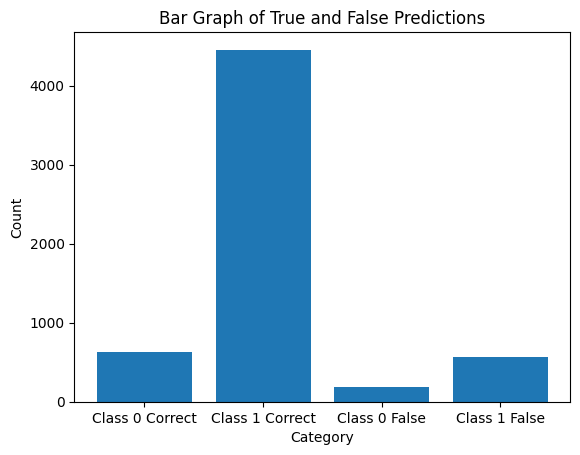

Accuracy : 0.8710174717368961
Precision : 0.8298339648740003
Recall : 0.7435055367868711
True Negatives : 632.0000
F1 Score (Macro) : 0.7743574481797567
AUC-ROC : 0.7435055367868713
Confusion Matrix : [[ 632  567]
 [ 186 4453]]
0.01 0.35
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


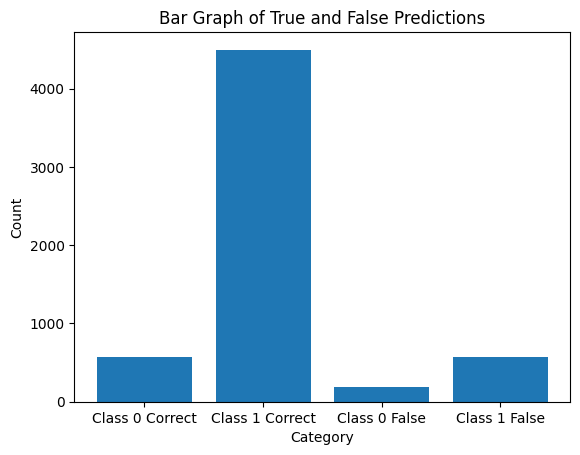

Accuracy : 0.869475847893114
Precision : 0.8213639445021919
Recall : 0.730366238692437
True Negatives : 577.0000
F1 Score (Macro) : 0.762111340223827
AUC-ROC : 0.730366238692437
Confusion Matrix : [[ 577  576]
 [ 186 4499]]
0.01 0.39999999999999997
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


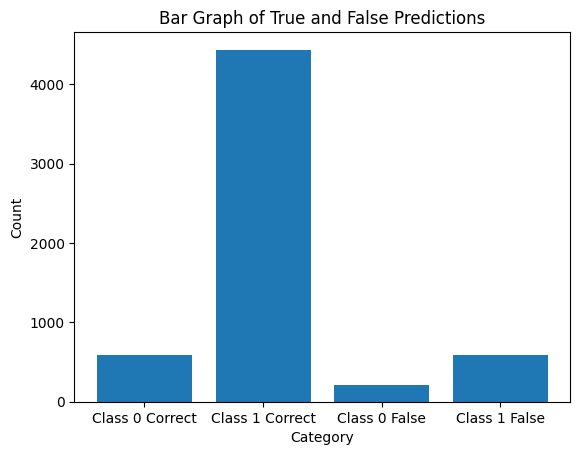

Accuracy : 0.8617677286742035
Precision : 0.8089957505104043
Recall : 0.7270967741935483
True Negatives : 594.0000
F1 Score (Macro) : 0.7560647823463214
AUC-ROC : 0.7270967741935483
Confusion Matrix : [[ 594  594]
 [ 213 4437]]
0.01 0.44999999999999996
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


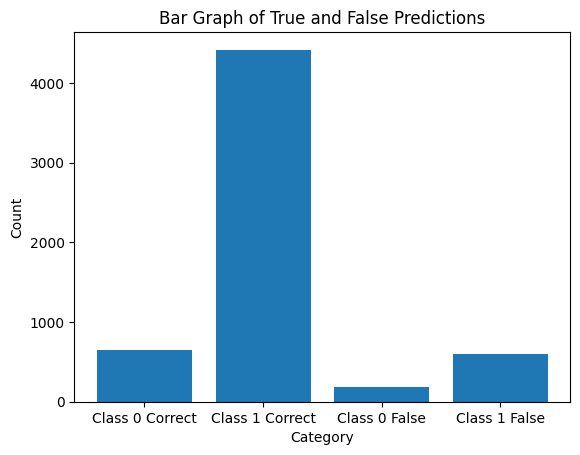

Accuracy : 0.8667351832819459
Precision : 0.8310228488289687
Recall : 0.7394872843007834
True Negatives : 643.0000
F1 Score (Macro) : 0.7710607622255126
AUC-ROC : 0.7394872843007834
Confusion Matrix : [[ 643  598]
 [ 180 4417]]
0.01 0.49999999999999994
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


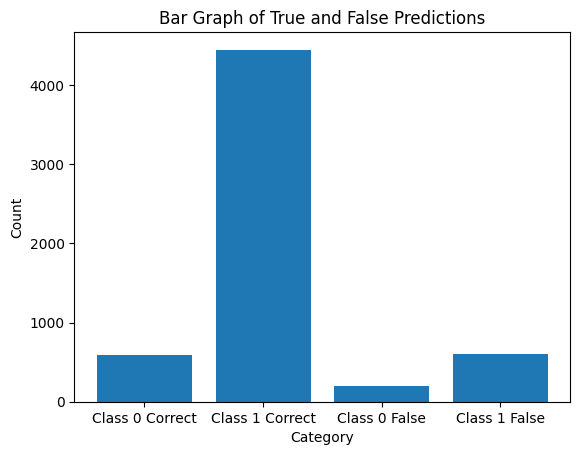

Accuracy : 0.8617677286742035
Precision : 0.8125481362525384
Recall : 0.7238620145206818
True Negatives : 585.0000
F1 Score (Macro) : 0.7543006561225827
AUC-ROC : 0.7238620145206818
Confusion Matrix : [[ 585  607]
 [ 200 4446]]
0.01 0.5499999999999999
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


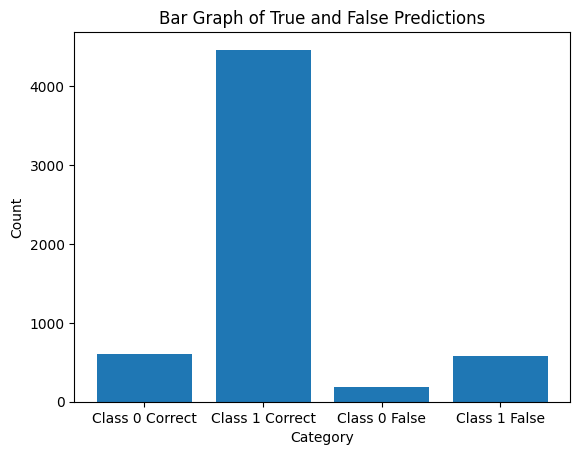

Accuracy : 0.8689619732785201
Precision : 0.824709458118301
Recall : 0.7370533137151797
True Negatives : 611.0000
F1 Score (Macro) : 0.7680209835392534
AUC-ROC : 0.7370533137151797
Confusion Matrix : [[ 611  576]
 [ 189 4462]]
0.01 0.6
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


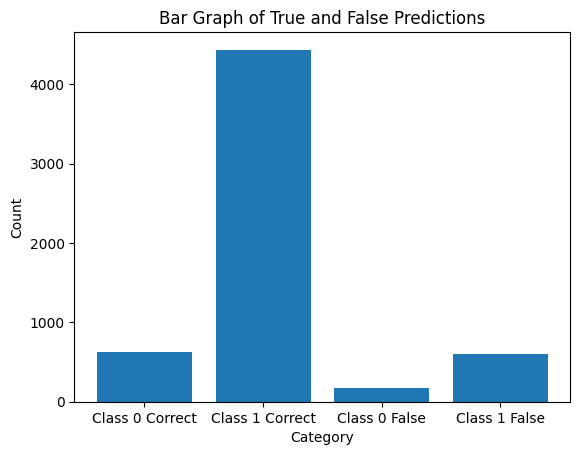

Accuracy : 0.8677629325111339
Precision : 0.8349360594372655
Recall : 0.7372166189802285
True Negatives : 631.0000
F1 Score (Macro) : 0.7701929672236572
AUC-ROC : 0.7372166189802286
Confusion Matrix : [[ 631  604]
 [ 168 4435]]
0.01 0.65
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


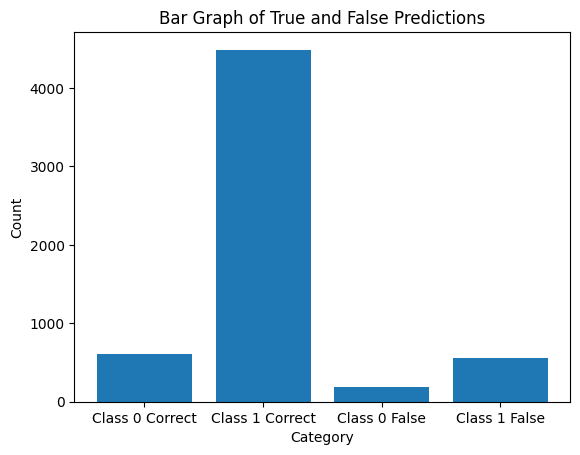

Accuracy : 0.8739294278862624
Precision : 0.8303442511680257
Recall : 0.7434787418293369
True Negatives : 614.0000
F1 Score (Macro) : 0.77473602270859
AUC-ROC : 0.7434787418293369
Confusion Matrix : [[ 614  553]
 [ 183 4488]]
0.01 0.7000000000000001
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


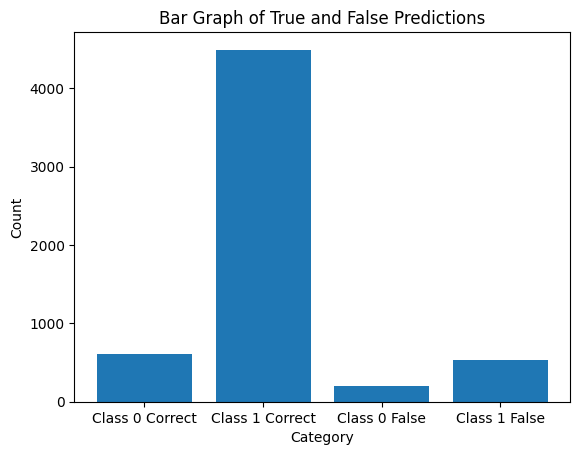

Accuracy : 0.8739294278862624
Precision : 0.8242773800053036
Recall : 0.7449692090814661
True Negatives : 612.0000
F1 Score (Macro) : 0.7743692289595954
AUC-ROC : 0.744969209081466
Confusion Matrix : [[ 612  538]
 [ 198 4490]]
0.01 0.7500000000000001
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


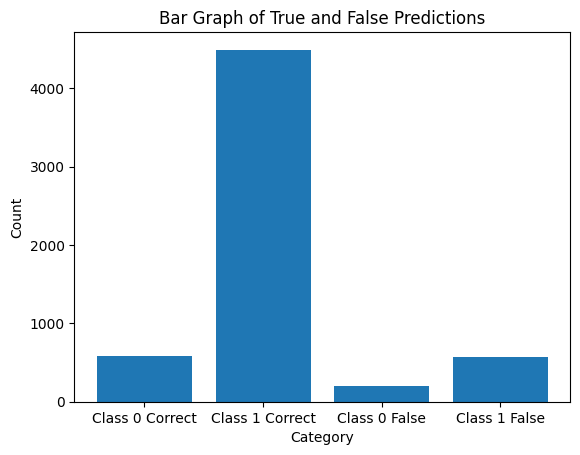

Accuracy : 0.8693045563549161
Precision : 0.8175273256660947
Recall : 0.7330207858289526
True Negatives : 584.0000
F1 Score (Macro) : 0.7632856908653842
AUC-ROC : 0.7330207858289526
Confusion Matrix : [[ 584  565]
 [ 198 4491]]
0.01 0.8000000000000002
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


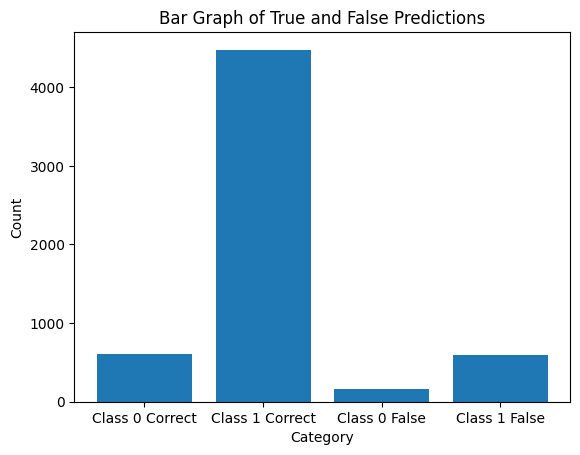

Accuracy : 0.8708461801986982
Precision : 0.8368257962099619
Recall : 0.735762035698452
True Negatives : 608.0000
F1 Score (Macro) : 0.7697874881934981
AUC-ROC : 0.735762035698452
Confusion Matrix : [[ 608  593]
 [ 161 4476]]
0.01 0.8500000000000002
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


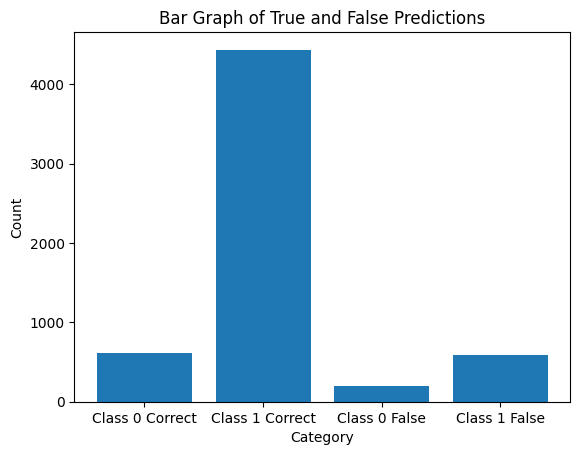

Accuracy : 0.8651935594381638
Precision : 0.8219075191064471
Recall : 0.7333889297627807
True Negatives : 615.0000
F1 Score (Macro) : 0.7641690726659609
AUC-ROC : 0.7333889297627806
Confusion Matrix : [[ 615  595]
 [ 192 4436]]
0.01 0.9000000000000002
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


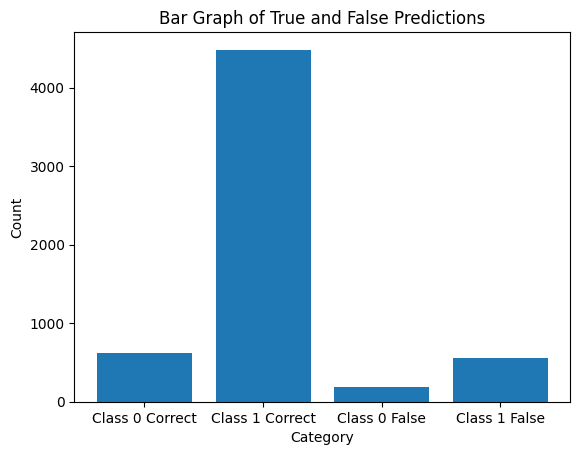

Accuracy : 0.8730729701952723
Precision : 0.8280233879654375
Recall : 0.7431420682878179
True Negatives : 615.0000
F1 Score (Macro) : 0.7738481552840766
AUC-ROC : 0.7431420682878179
Confusion Matrix : [[ 615  553]
 [ 188 4482]]
0.01 0.9500000000000003
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


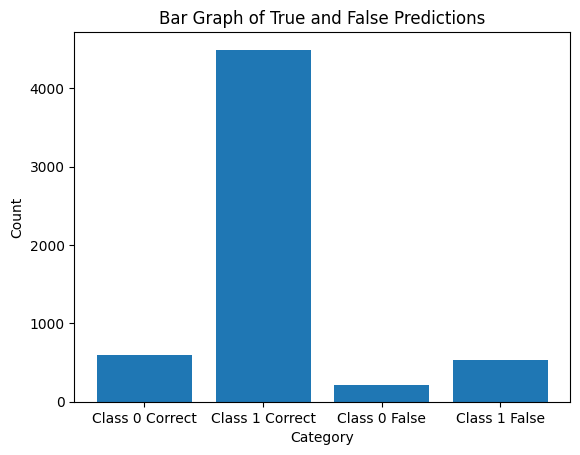

Accuracy : 0.8713600548132923
Precision : 0.8145612444479913
Recall : 0.7397368069331836
True Negatives : 594.0000
F1 Score (Macro) : 0.7677792365197473
AUC-ROC : 0.7397368069331836
Confusion Matrix : [[ 594  538]
 [ 213 4493]]
0.1 0.2
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


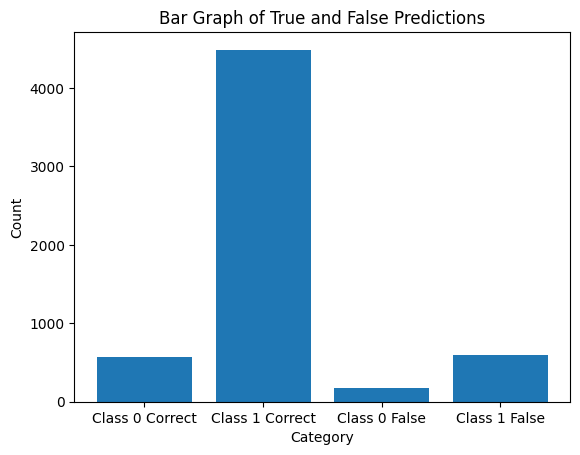

Accuracy : 0.8674203494347379
Precision : 0.8233476011494949
Recall : 0.7266596349454115
True Negatives : 576.0000
F1 Score (Macro) : 0.75937311286844
AUC-ROC : 0.7266596349454115
Confusion Matrix : [[ 576  596]
 [ 178 4488]]
0.1 0.25
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


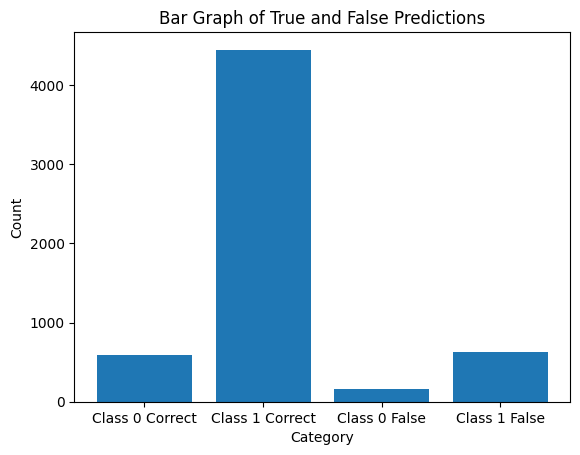

Accuracy : 0.8633093525179856
Precision : 0.8282965948517649
Recall : 0.7238413354071581
True Negatives : 592.0000
F1 Score (Macro) : 0.7575287136529154
AUC-ROC : 0.723841335407158
Confusion Matrix : [[ 592  632]
 [ 166 4448]]
0.1 0.3
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


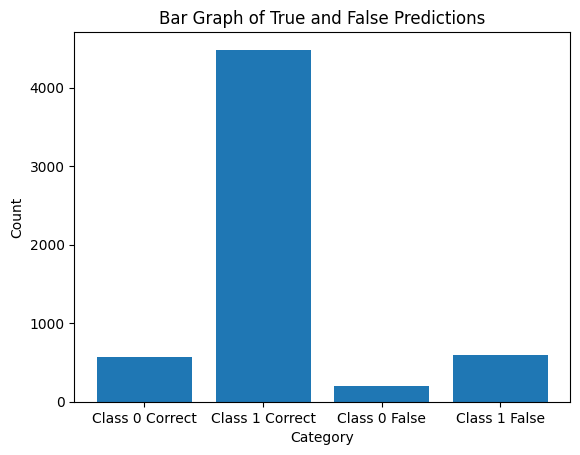

Accuracy : 0.8643371017471737
Precision : 0.8129275408884559
Recall : 0.7222641635833325
True Negatives : 565.0000
F1 Score (Macro) : 0.7533658914606286
AUC-ROC : 0.7222641635833325
Confusion Matrix : [[ 565  597]
 [ 195 4481]]
0.1 0.35
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


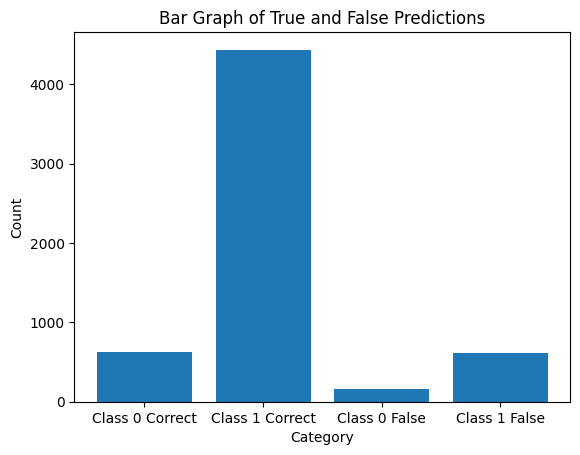

Accuracy : 0.8674203494347379
Precision : 0.8382928656227033
Recall : 0.7348240225695102
True Negatives : 626.0000
F1 Score (Macro) : 0.7688795912208645
AUC-ROC : 0.7348240225695102
Confusion Matrix : [[ 626  616]
 [ 158 4438]]
0.1 0.39999999999999997
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


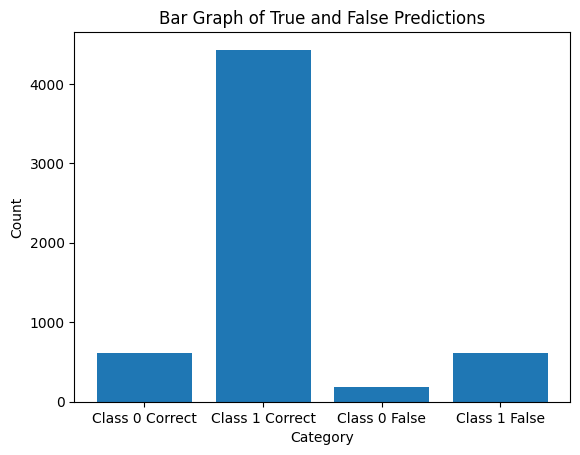

Accuracy : 0.8626241863651936
Precision : 0.8201007696736198
Recall : 0.7284073469766157
True Negatives : 607.0000
F1 Score (Macro) : 0.7595798826777087
AUC-ROC : 0.7284073469766157
Confusion Matrix : [[ 607  612]
 [ 190 4429]]
0.1 0.44999999999999996
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


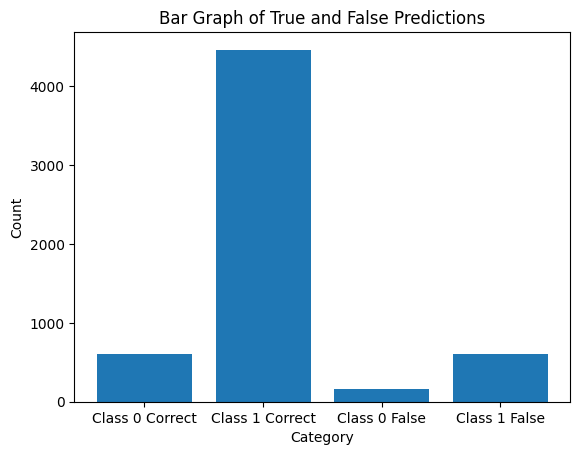

Accuracy : 0.868619390202124
Precision : 0.8355983039776131
Recall : 0.7322939005962853
True Negatives : 605.0000
F1 Score (Macro) : 0.7664790622627273
AUC-ROC : 0.7322939005962854
Confusion Matrix : [[ 605  607]
 [ 160 4466]]
0.1 0.49999999999999994
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


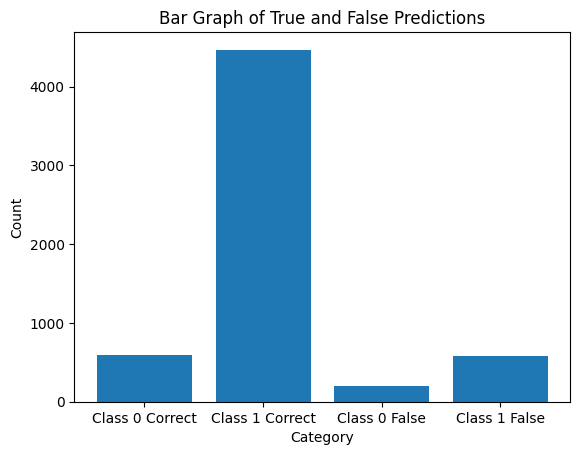

Accuracy : 0.8670777663583419
Precision : 0.8178203416405161
Recall : 0.7316697703244449
True Negatives : 592.0000
F1 Score (Macro) : 0.7621066870552256
AUC-ROC : 0.7316697703244449
Confusion Matrix : [[ 592  579]
 [ 197 4470]]
0.1 0.5499999999999999
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


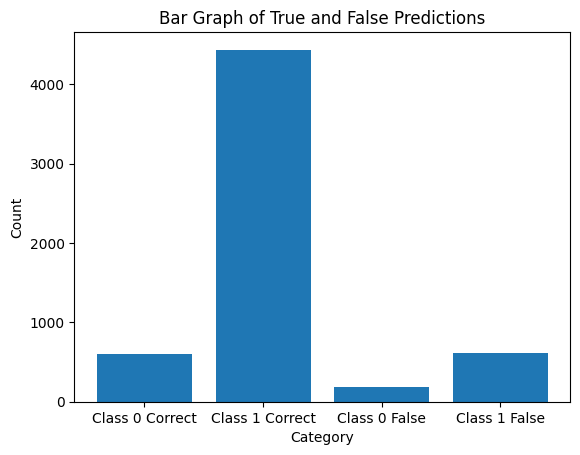

Accuracy : 0.8633093525179856
Precision : 0.8227208028866204
Recall : 0.7277317510076131
True Negatives : 603.0000
F1 Score (Macro) : 0.7596451018558417
AUC-ROC : 0.7277317510076131
Confusion Matrix : [[ 603  615]
 [ 183 4437]]
0.1 0.6
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


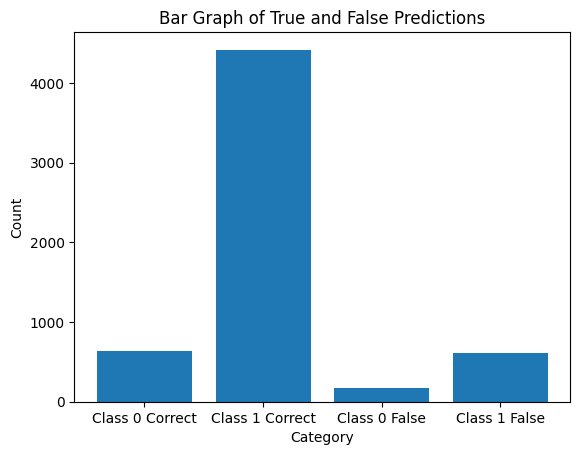

Accuracy : 0.8650222678999657
Precision : 0.8305290310745719
Recall : 0.7345707808451398
True Negatives : 631.0000
F1 Score (Macro) : 0.7668740656656514
AUC-ROC : 0.7345707808451398
Confusion Matrix : [[ 631  613]
 [ 175 4419]]
0.1 0.65
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


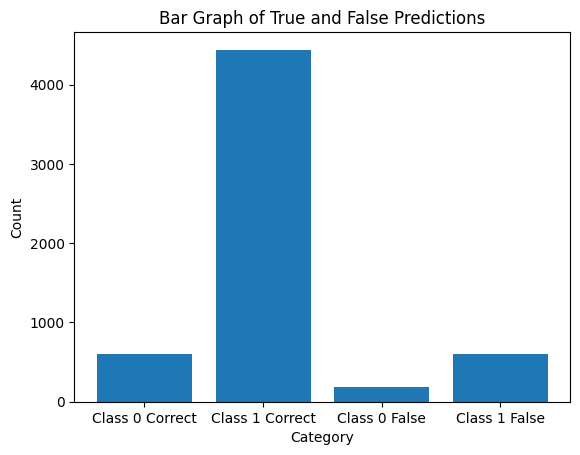

Accuracy : 0.8643371017471737
Precision : 0.8230507111624867
Recall : 0.7292873256197215
True Negatives : 604.0000
F1 Score (Macro) : 0.7610739975196362
AUC-ROC : 0.7292873256197215
Confusion Matrix : [[ 604  608]
 [ 184 4442]]
0.1 0.7000000000000001
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


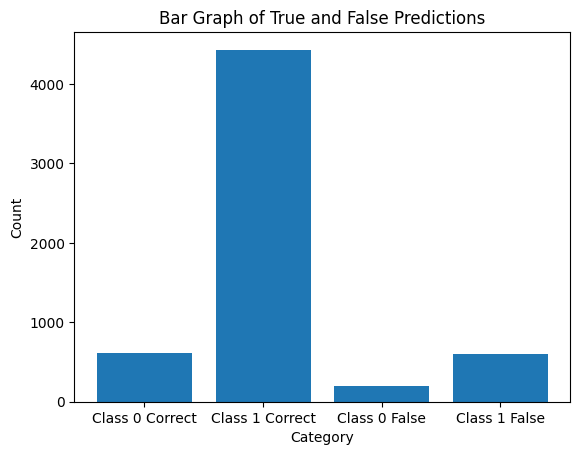

Accuracy : 0.8634806440561836
Precision : 0.818937938436542
Recall : 0.7303731178268794
True Negatives : 609.0000
F1 Score (Macro) : 0.7609849326408422
AUC-ROC : 0.7303731178268794
Confusion Matrix : [[ 609  602]
 [ 195 4432]]
0.1 0.7500000000000001
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


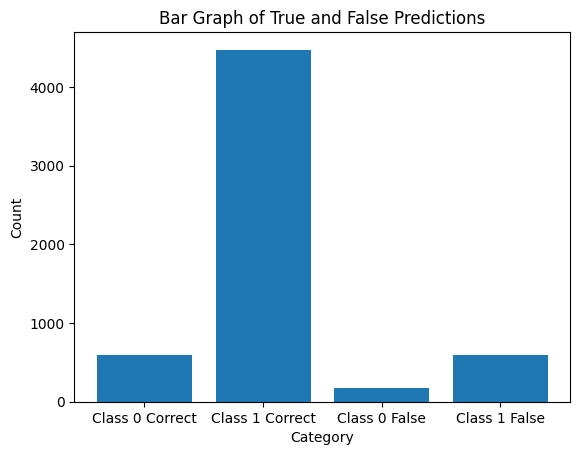

Accuracy : 0.868790681740322
Precision : 0.8280505651689383
Recall : 0.7327587705007059
True Negatives : 598.0000
F1 Score (Macro) : 0.7653633993372535
AUC-ROC : 0.7327587705007059
Confusion Matrix : [[ 598  590]
 [ 176 4474]]
0.1 0.8000000000000002
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


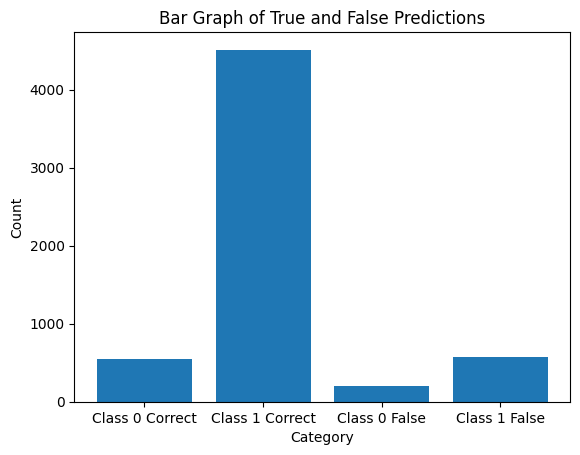

Accuracy : 0.8670777663583419
Precision : 0.8074525273720732
Recall : 0.7240448813056379
True Negatives : 551.0000
F1 Score (Macro) : 0.7537973127462279
AUC-ROC : 0.7240448813056379
Confusion Matrix : [[ 551  569]
 [ 207 4511]]
0.1 0.8500000000000002
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


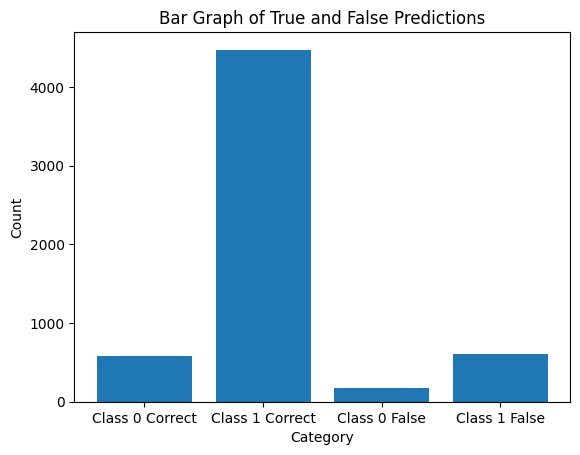

Accuracy : 0.8667351832819459
Precision : 0.8271841794569068
Recall : 0.7269829787910218
True Negatives : 585.0000
F1 Score (Macro) : 0.7603203437398682
AUC-ROC : 0.7269829787910218
Confusion Matrix : [[ 585  607]
 [ 171 4475]]
0.1 0.9000000000000002
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


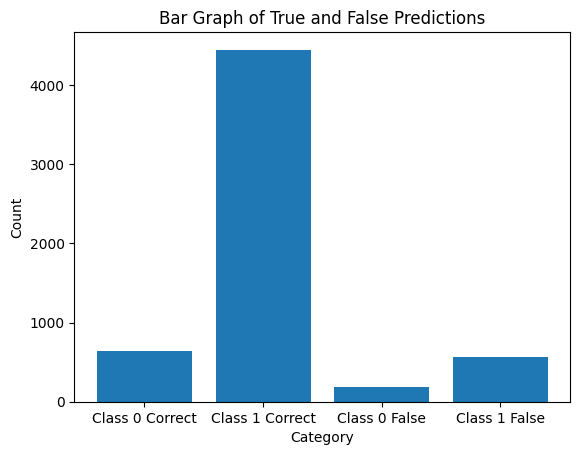

Accuracy : 0.8705035971223022
Precision : 0.8281463971523833
Recall : 0.7441841381193912
True Negatives : 636.0000
F1 Score (Macro) : 0.7744303629780094
AUC-ROC : 0.7441841381193912
Confusion Matrix : [[ 636  565]
 [ 191 4446]]
0.1 0.9500000000000003
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


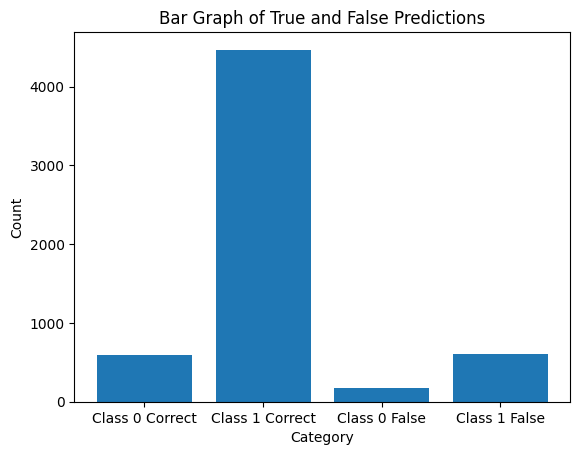

Accuracy : 0.8669064748201439
Precision : 0.8272512943786983
Recall : 0.7293743408294492
True Negatives : 594.0000
F1 Score (Macro) : 0.7622838977754823
AUC-ROC : 0.7293743408294492
Confusion Matrix : [[ 594  603]
 [ 174 4467]]
0.15 0.2
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


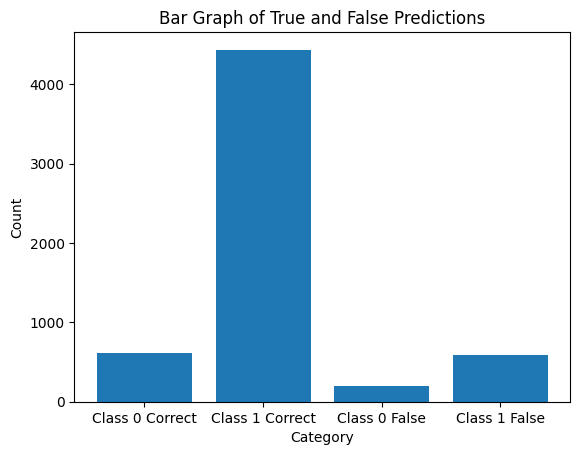

Accuracy : 0.8646796848235697
Precision : 0.8195285881807883
Recall : 0.7323743700478168
True Negatives : 611.0000
F1 Score (Macro) : 0.7628045880347056
AUC-ROC : 0.7323743700478168
Confusion Matrix : [[ 611  594]
 [ 196 4437]]
0.15 0.25
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


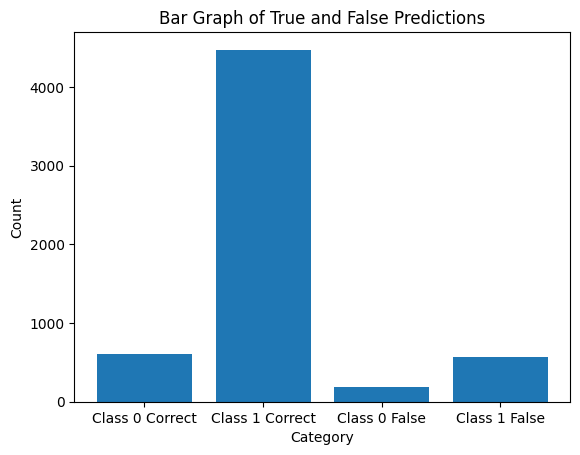

Accuracy : 0.8705035971223022
Precision : 0.8257196882676233
Recall : 0.738541235075411
True Negatives : 609.0000
F1 Score (Macro) : 0.7695495993368333
AUC-ROC : 0.7385412350754113
Confusion Matrix : [[ 609  568]
 [ 188 4473]]
0.15 0.3
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


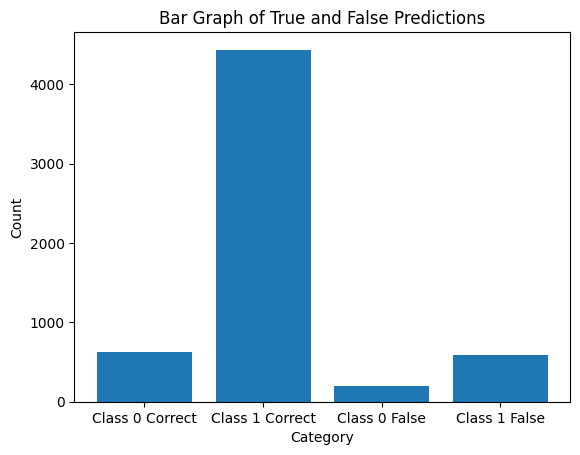

Accuracy : 0.8655361425145598
Precision : 0.8220177056761451
Recall : 0.7350228802792356
True Negatives : 620.0000
F1 Score (Macro) : 0.7655034788181612
AUC-ROC : 0.7350228802792357
Confusion Matrix : [[ 620  591]
 [ 194 4433]]
0.15 0.35
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


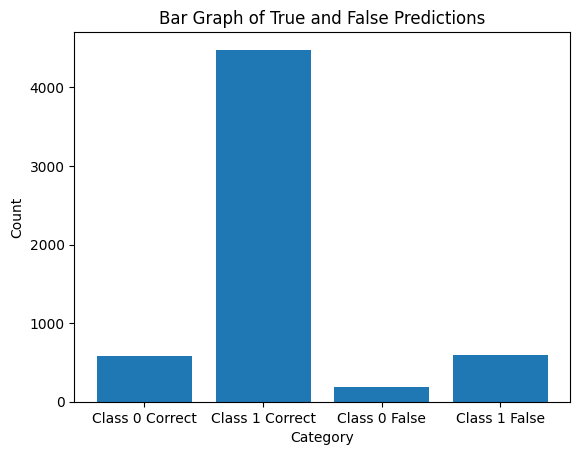

Accuracy : 0.8665638917437478
Precision : 0.8205397278170089
Recall : 0.7271859777745959
True Negatives : 580.0000
F1 Score (Macro) : 0.7591212053913226
AUC-ROC : 0.7271859777745959
Confusion Matrix : [[ 580  594]
 [ 185 4479]]
0.15 0.39999999999999997
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


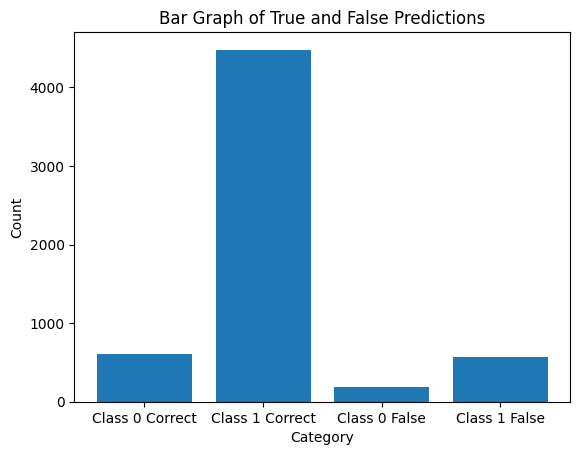

Accuracy : 0.8705035971223022
Precision : 0.8248920325927432
Recall : 0.7373308274735286
True Negatives : 603.0000
F1 Score (Macro) : 0.7684265403380726
AUC-ROC : 0.7373308274735287
Confusion Matrix : [[ 603  568]
 [ 188 4479]]
0.15 0.44999999999999996
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


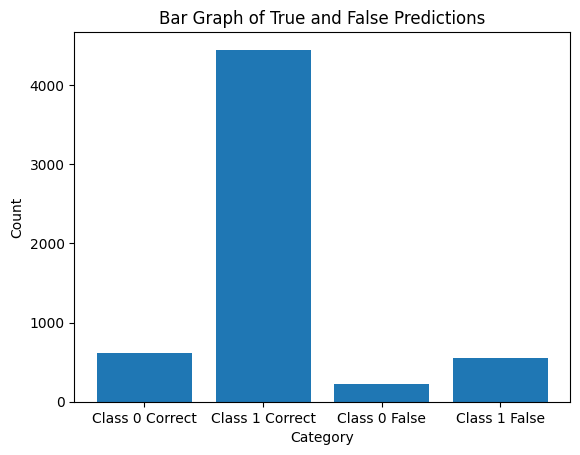

Accuracy : 0.8674203494347379
Precision : 0.8140394559879398
Recall : 0.7398322282969192
True Negatives : 618.0000
F1 Score (Macro) : 0.7674254426193057
AUC-ROC : 0.7398322282969194
Confusion Matrix : [[ 618  556]
 [ 218 4446]]
0.15 0.49999999999999994
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


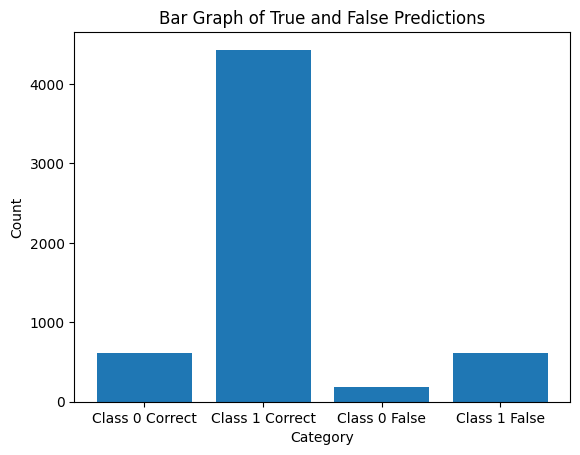

Accuracy : 0.8634806440561836
Precision : 0.8215335946804287
Recall : 0.730156284604678
True Negatives : 611.0000
F1 Score (Macro) : 0.7613596585774687
AUC-ROC : 0.730156284604678
Confusion Matrix : [[ 611  608]
 [ 189 4430]]
0.15 0.5499999999999999
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


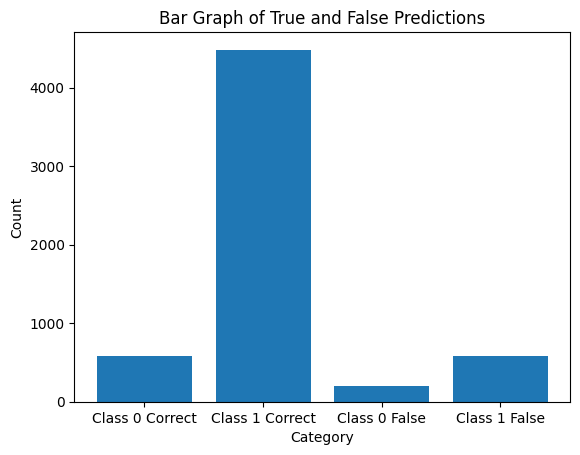

Accuracy : 0.8667351832819459
Precision : 0.8135733187334611
Recall : 0.7288705086973317
True Negatives : 578.0000
F1 Score (Macro) : 0.7589322620825149
AUC-ROC : 0.7288705086973316
Confusion Matrix : [[ 578  576]
 [ 202 4482]]
0.15 0.6
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


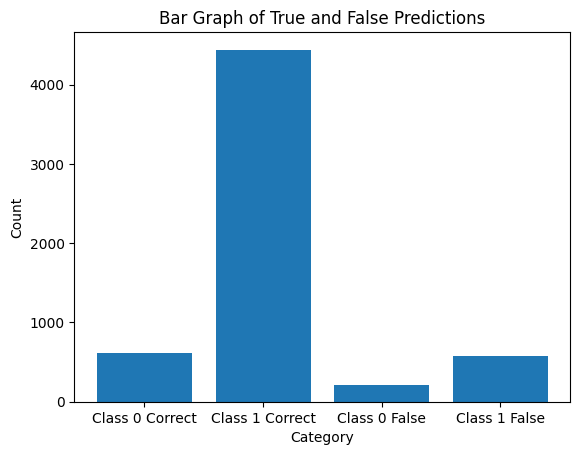

Accuracy : 0.8662213086673518
Precision : 0.817520100694272
Recall : 0.7366391165670405
True Negatives : 617.0000
F1 Score (Macro) : 0.7657832275941001
AUC-ROC : 0.7366391165670403
Confusion Matrix : [[ 617  575]
 [ 206 4440]]
0.15 0.65
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


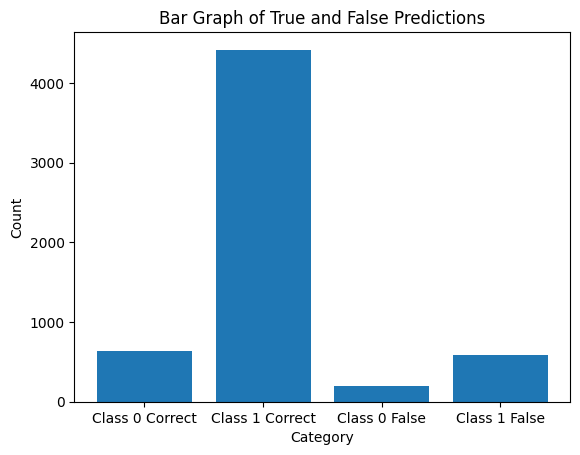

Accuracy : 0.8645083932853717
Precision : 0.8204106817552196
Recall : 0.7368203743047026
True Negatives : 632.0000
F1 Score (Macro) : 0.7664345861432982
AUC-ROC : 0.7368203743047026
Confusion Matrix : [[ 632  590]
 [ 201 4415]]
0.15 0.7000000000000001
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


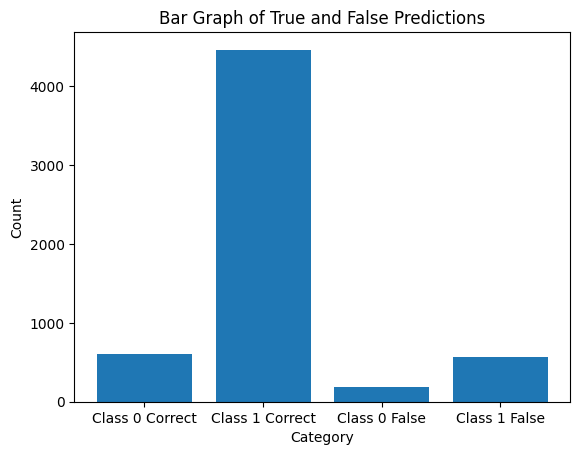

Accuracy : 0.869475847893114
Precision : 0.824230874362941
Recall : 0.7379490685017531
True Negatives : 611.0000
F1 Score (Macro) : 0.7686529379068869
AUC-ROC : 0.7379490685017531
Confusion Matrix : [[ 611  571]
 [ 191 4465]]
0.15 0.7500000000000001
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


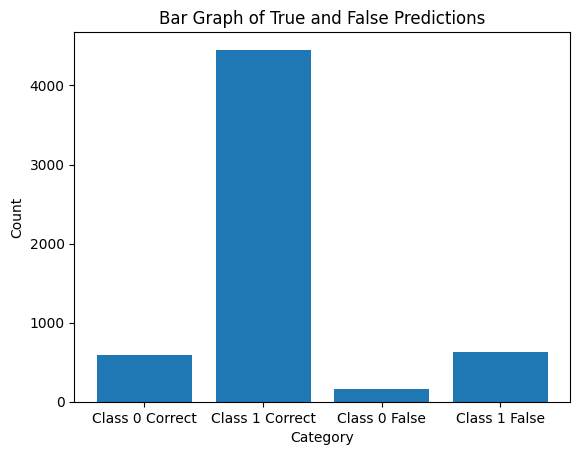

Accuracy : 0.8645083932853717
Precision : 0.8302383603880817
Recall : 0.7256890570618952
True Negatives : 595.0000
F1 Score (Macro) : 0.7595591330637446
AUC-ROC : 0.7256890570618953
Confusion Matrix : [[ 595  627]
 [ 164 4452]]
0.15 0.8000000000000002
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


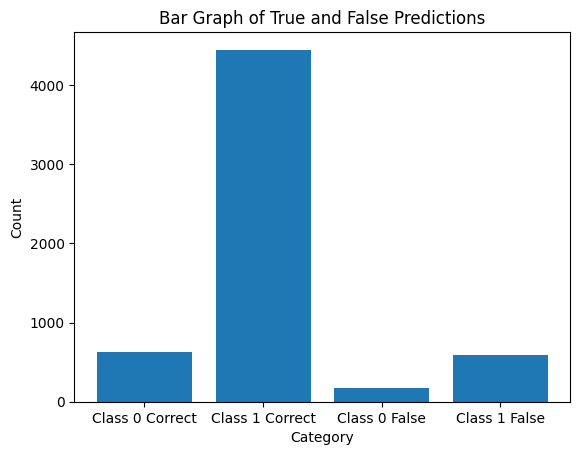

Accuracy : 0.8703323055841041
Precision : 0.8351722672168592
Recall : 0.7414304720257893
True Negatives : 634.0000
F1 Score (Macro) : 0.7738676859431186
AUC-ROC : 0.7414304720257893
Confusion Matrix : [[ 634  585]
 [ 172 4447]]
0.15 0.8500000000000002
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


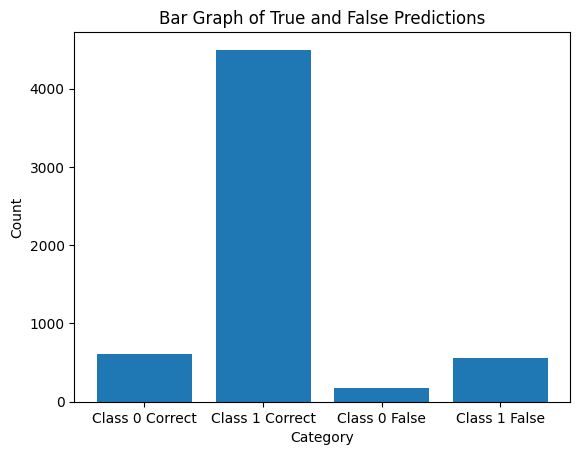

Accuracy : 0.8751284686536485
Precision : 0.8353300870643787
Recall : 0.7435425043394195
True Negatives : 613.0000
F1 Score (Macro) : 0.7760588448400924
AUC-ROC : 0.7435425043394196
Confusion Matrix : [[ 613  557]
 [ 172 4496]]
0.15 0.9000000000000002
Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8691971976152649


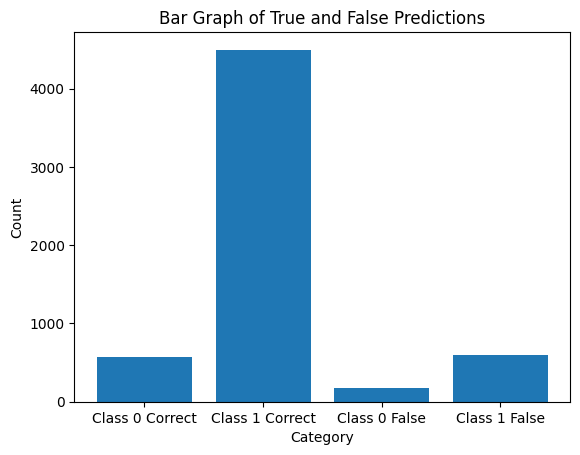

Accuracy : 0.8689619732785201
Precision : 0.8269195645556409
Recall : 0.7274108269044616
True Negatives : 574.0000
F1 Score (Macro) : 0.7608737427261325
AUC-ROC : 0.7274108269044616
Confusion Matrix : [[ 574  594]
 [ 171 4499]]
0.15 0.9500000000000003
0.01 0.7500000000000001


In [227]:
C2_params = {
    'C': [1.0, 2.0, 3.0, 4.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

dfmin, dfmax = findBest(C2_params, cutoff2, '1', 3.0, 'l2', 'liblinear')
print(dfmin, dfmax)

Best Hyperparameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8071534891326273


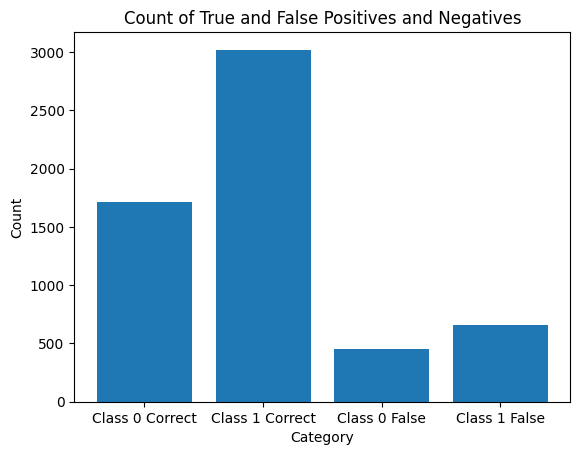

Accuracy : 0.8105515587529976
Precision : 0.8066070236823801
Recall : 0.7966325702833147
True Negatives : 1711.0000
F1 Score (Macro) : 0.8005067270293303
AUC-ROC : 0.7966325702833148
Confusion Matrix : [[1711  655]
 [ 451 3021]]


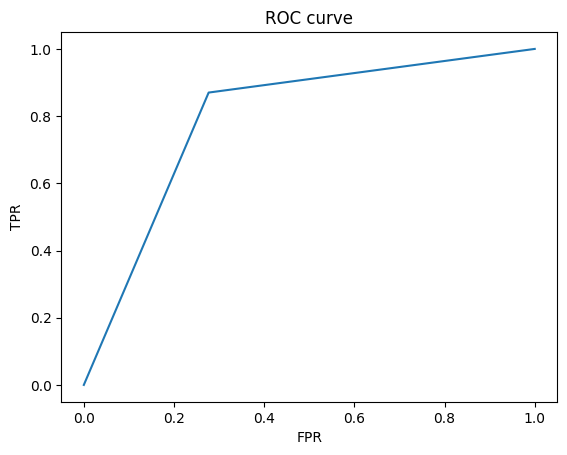

In [271]:
# Execution of the optimal parameters

x_training, x_testing = Vectorize((1,3), 0.001, 0.99, 10000)

linear_regression(C2_params, cutoff2, '2', 2.0, 'l2', 'liblinear')


Cutoff = 3

Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


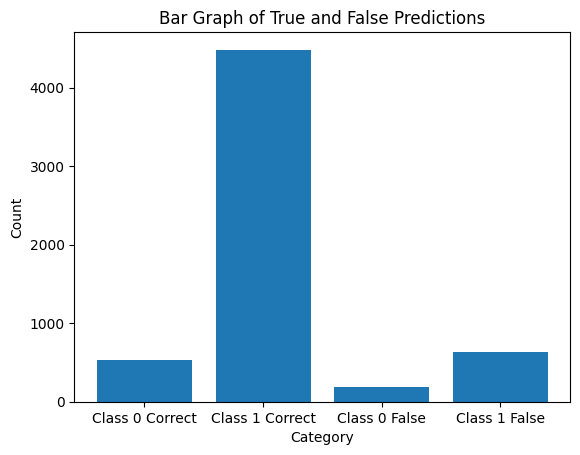

Accuracy : 0.8595409386776294
Precision : 0.8080390887097997
Recall : 0.708868130125238
True Negatives : 534.0000
F1 Score (Macro) : 0.7409509568963726
AUC-ROC : 0.708868130125238
Confusion Matrix : [[ 534  632]
 [ 188 4484]]
0.001 0.2
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858645239759146


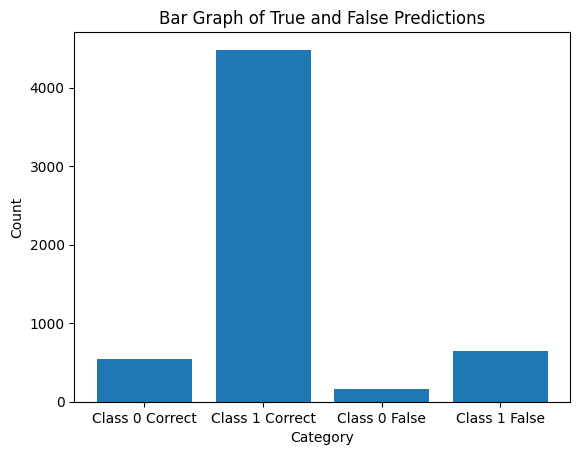

Accuracy : 0.8609112709832134
Precision : 0.819805398618958
Recall : 0.7102650157488868
True Negatives : 542.0000
F1 Score (Macro) : 0.7443516864694157
AUC-ROC : 0.7102650157488868
Confusion Matrix : [[ 542  646]
 [ 166 4484]]
0.001 0.25
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


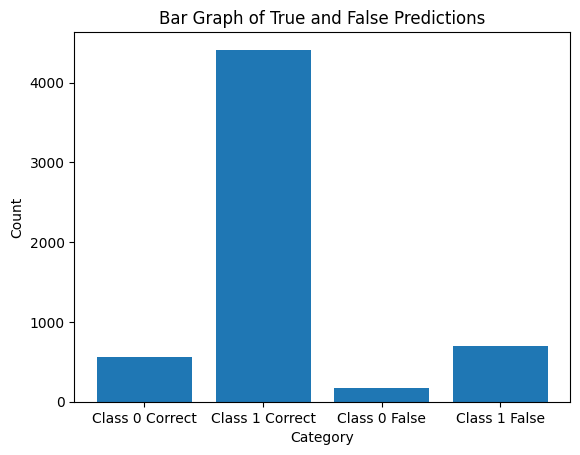

Accuracy : 0.8523466940733128
Precision : 0.8168456947085287
Recall : 0.7058979212155219
True Negatives : 564.0000
F1 Score (Macro) : 0.7389198729555271
AUC-ROC : 0.7058979212155219
Confusion Matrix : [[ 564  693]
 [ 169 4412]]
0.001 0.3
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858645239759146


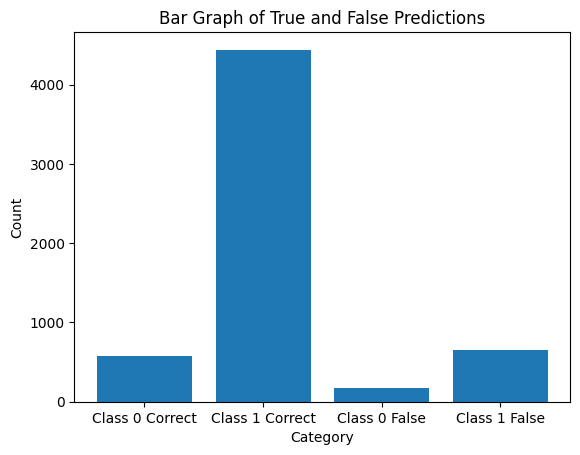

Accuracy : 0.8583418979102432
Precision : 0.8209824205444152
Recall : 0.7142673415881935
True Negatives : 572.0000
F1 Score (Macro) : 0.7476011125775053
AUC-ROC : 0.7142673415881935
Confusion Matrix : [[ 572  657]
 [ 170 4439]]
0.001 0.35
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


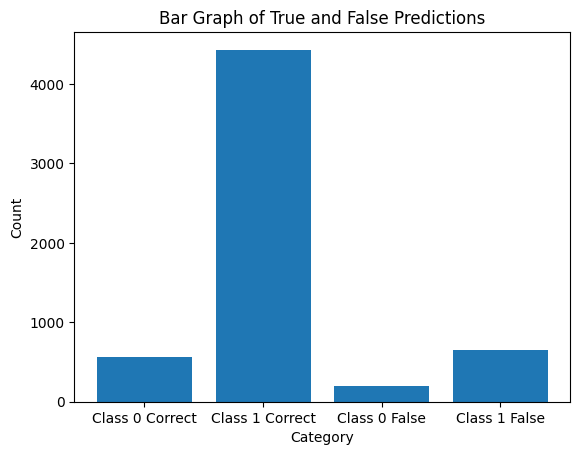

Accuracy : 0.8557725248372731
Precision : 0.8073575270032087
Recall : 0.7124030726909532
True Negatives : 566.0000
F1 Score (Macro) : 0.7433343421185366
AUC-ROC : 0.7124030726909532
Confusion Matrix : [[ 566  645]
 [ 197 4430]]
0.001 0.39999999999999997
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


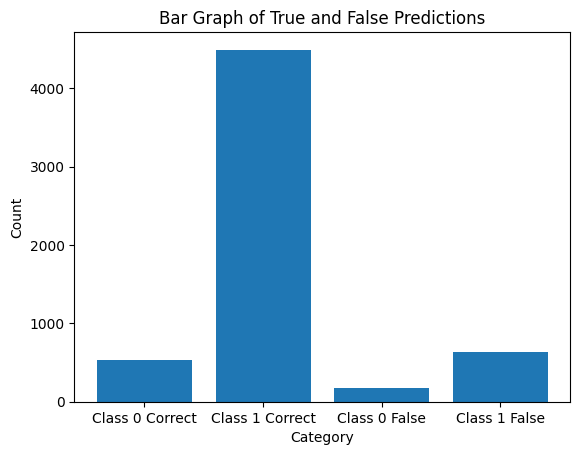

Accuracy : 0.8607399794450155
Precision : 0.811246750428527
Recall : 0.7089306192265071
True Negatives : 531.0000
F1 Score (Macro) : 0.7417246403428222
AUC-ROC : 0.7089306192265072
Confusion Matrix : [[ 531  632]
 [ 181 4494]]
0.001 0.44999999999999996
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


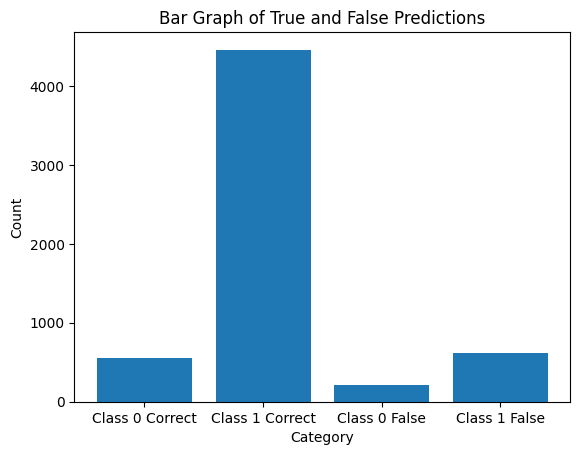

Accuracy : 0.8574854402192532
Precision : 0.8002571001184219
Recall : 0.7116944609232527
True Negatives : 548.0000
F1 Score (Macro) : 0.741556944546131
AUC-ROC : 0.7116944609232527
Confusion Matrix : [[ 548  622]
 [ 210 4458]]
0.001 0.49999999999999994
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858645239759146


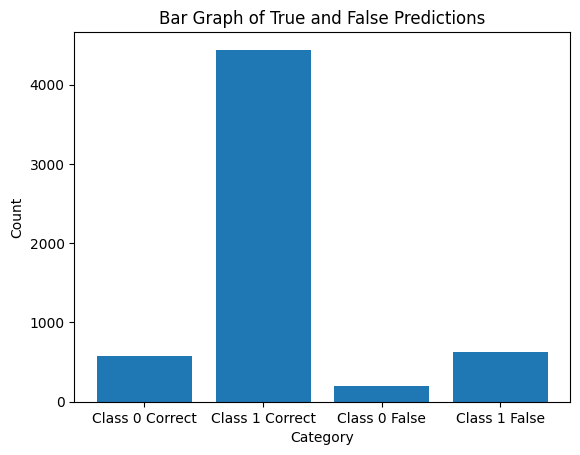

Accuracy : 0.8593696471394313
Precision : 0.8103401837829471
Recall : 0.7191685929263825
True Negatives : 577.0000
F1 Score (Macro) : 0.7498366734996653
AUC-ROC : 0.7191685929263825
Confusion Matrix : [[ 577  622]
 [ 199 4440]]
0.001 0.5499999999999999
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


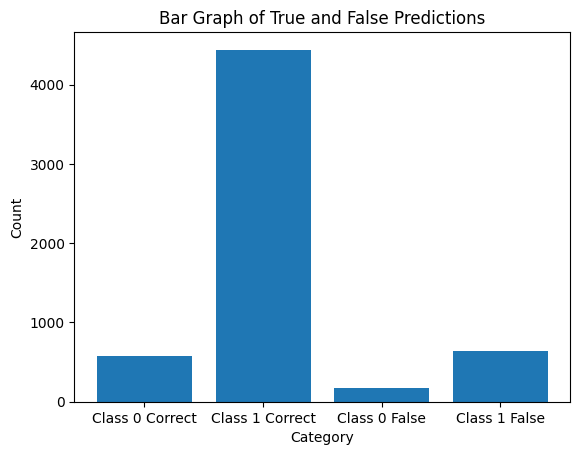

Accuracy : 0.8593696471394313
Precision : 0.8198506289308176
Recall : 0.7165110352244856
True Negatives : 575.0000
F1 Score (Macro) : 0.7494323016035451
AUC-ROC : 0.7165110352244854
Confusion Matrix : [[ 575  646]
 [ 175 4442]]
0.001 0.6
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


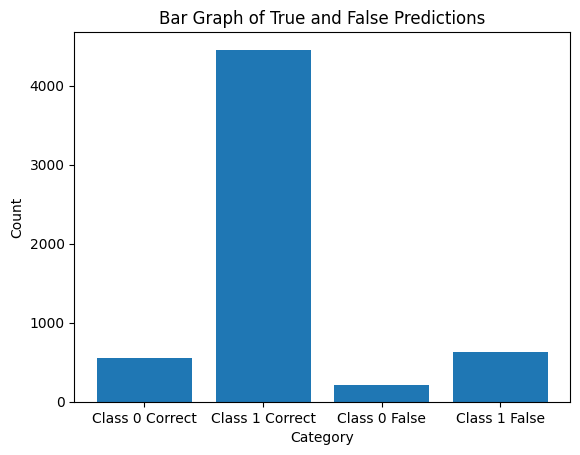

Accuracy : 0.8566289825282631
Precision : 0.801168580349203
Recall : 0.7100701705808201
True Negatives : 547.0000
F1 Score (Macro) : 0.74032781553647
AUC-ROC : 0.7100701705808201
Confusion Matrix : [[ 547  631]
 [ 206 4454]]
0.001 0.65
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


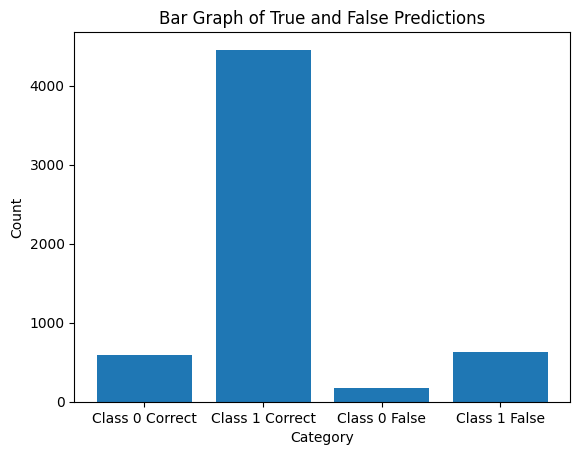

Accuracy : 0.8633093525179856
Precision : 0.8249293623917063
Recall : 0.7231585999066833
True Negatives : 586.0000
F1 Score (Macro) : 0.7563533363108904
AUC-ROC : 0.7231585999066833
Confusion Matrix : [[ 586  626]
 [ 172 4454]]
0.001 0.7000000000000001
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858645239759146


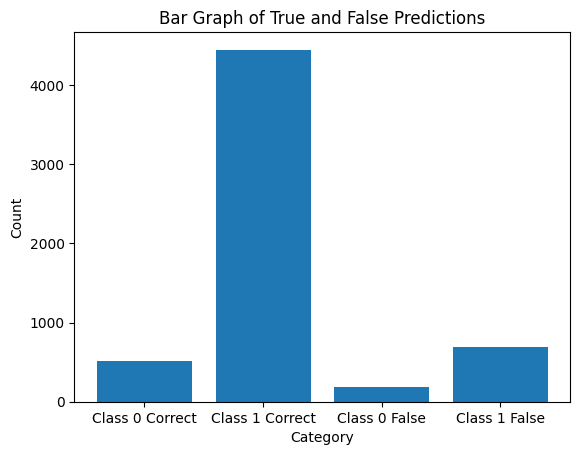

Accuracy : 0.8499486125385406
Precision : 0.8002611388139323
Recall : 0.6943915835378345
True Negatives : 518.0000
F1 Score (Macro) : 0.7260618376102804
AUC-ROC : 0.6943915835378346
Confusion Matrix : [[ 518  689]
 [ 187 4444]]
0.001 0.7500000000000001
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858645239759146


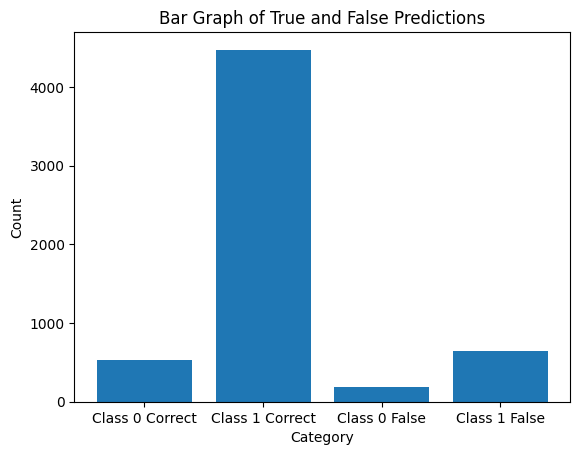

Accuracy : 0.8564576909900651
Precision : 0.8053517599972634
Recall : 0.7033893748027933
True Negatives : 526.0000
F1 Score (Macro) : 0.7354906101687217
AUC-ROC : 0.7033893748027933
Confusion Matrix : [[ 526  651]
 [ 187 4474]]
0.001 0.8000000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


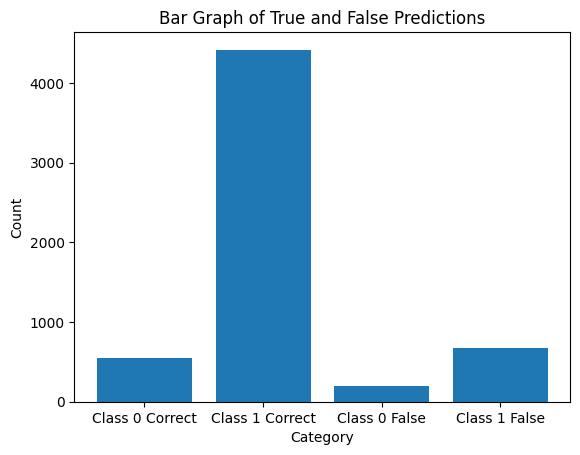

Accuracy : 0.8513189448441247
Precision : 0.8028097461541313
Recall : 0.704030637058403
True Negatives : 551.0000
F1 Score (Macro) : 0.7349808219521965
AUC-ROC : 0.7040306370584031
Confusion Matrix : [[ 551  672]
 [ 196 4419]]
0.001 0.8500000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


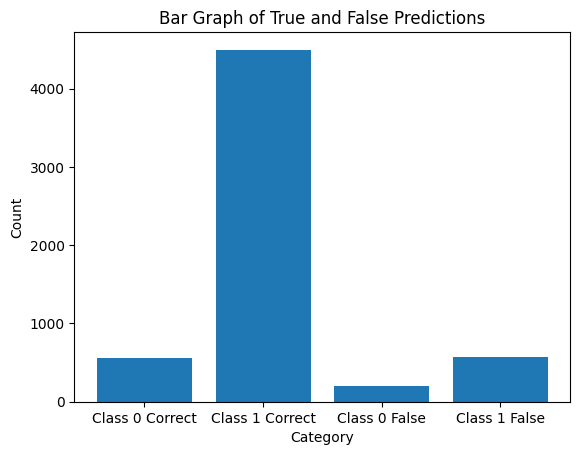

Accuracy : 0.8660500171291539
Precision : 0.8085883357876957
Recall : 0.7243545922979147
True Negatives : 559.0000
F1 Score (Macro) : 0.7542146179688172
AUC-ROC : 0.7243545922979147
Confusion Matrix : [[ 559  576]
 [ 206 4497]]
0.001 0.9000000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


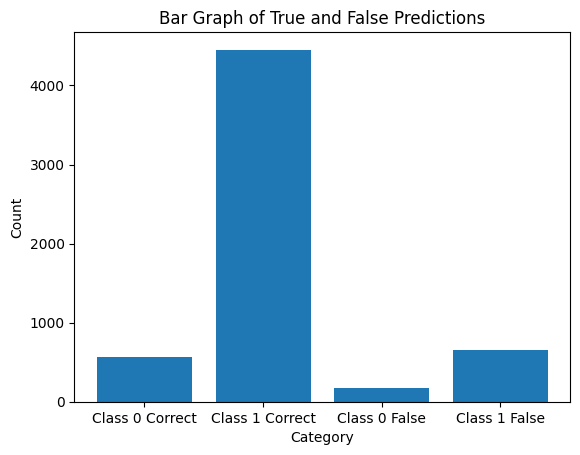

Accuracy : 0.8588557725248372
Precision : 0.8207185076324004
Recall : 0.7125242573518435
True Negatives : 562.0000
F1 Score (Macro) : 0.7461490530098347
AUC-ROC : 0.7125242573518435
Confusion Matrix : [[ 562  656]
 [ 168 4452]]
0.001 0.9500000000000003
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


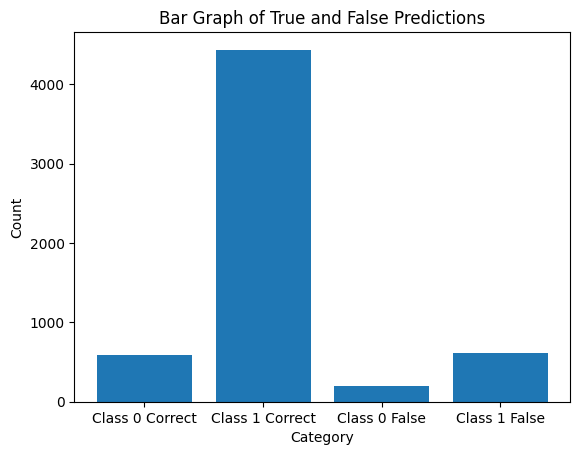

Accuracy : 0.8609112709832134
Precision : 0.8117319304298982
Recall : 0.7236417736457313
True Negatives : 588.0000
F1 Score (Macro) : 0.7538671334364568
AUC-ROC : 0.7236417736457313
Confusion Matrix : [[ 588  610]
 [ 202 4438]]
0.01 0.2
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


Accuracy : 0.8544021925316889
Precision : 0.8158828142854175
Recall : 0.7120925893635571
True Negatives : 579.0000
F1 Score (Macro) : 0.7443871596773848
AUC-ROC : 0.712092589363557
Confusion Matrix : [[ 579  671]
 [ 179 4409]]
0.01 0.25
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


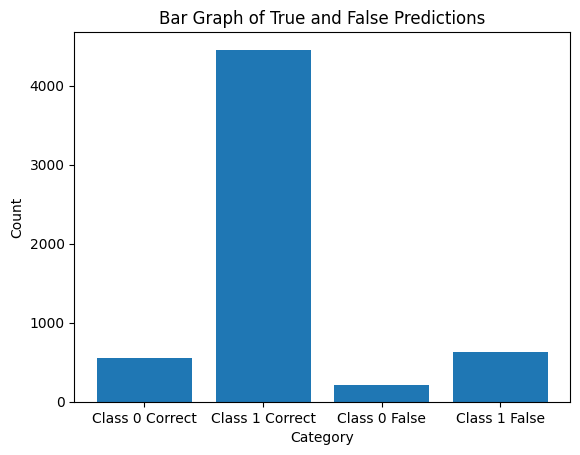

Accuracy : 0.8566289825282631
Precision : 0.8003787459301424
Recall : 0.710260004902862
True Negatives : 547.0000
F1 Score (Macro) : 0.74032781553647
AUC-ROC : 0.710260004902862
Confusion Matrix : [[ 547  629]
 [ 208 4454]]
0.01 0.3
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


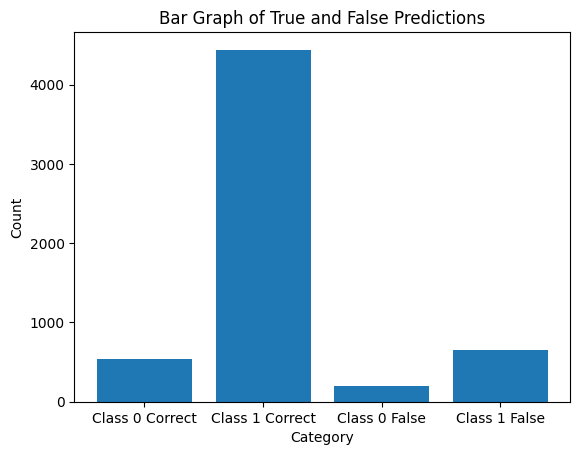

Accuracy : 0.8530318602261048
Precision : 0.7995171943959006
Recall : 0.7039946453711136
True Negatives : 540.0000
F1 Score (Macro) : 0.7345835503186584
AUC-ROC : 0.7039946453711134
Confusion Matrix : [[ 540  656]
 [ 202 4440]]
0.01 0.35
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


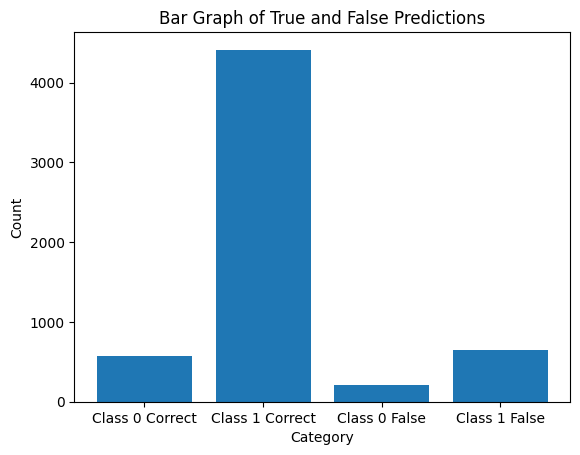

Accuracy : 0.8535457348406988
Precision : 0.8012426582794807
Recall : 0.7119453763189547
True Negatives : 570.0000
F1 Score (Macro) : 0.7415556244189649
AUC-ROC : 0.7119453763189547
Confusion Matrix : [[ 570  644]
 [ 211 4413]]
0.01 0.39999999999999997
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858645239759146


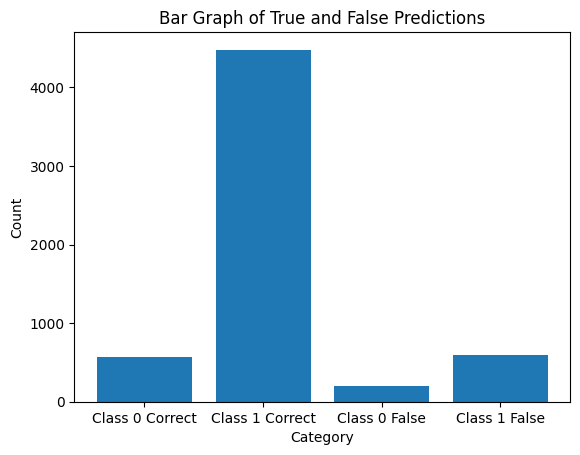

Accuracy : 0.8653648509763617
Precision : 0.8145189065078569
Recall : 0.7255965221073806
True Negatives : 574.0000
F1 Score (Macro) : 0.7564534164484018
AUC-ROC : 0.7255965221073806
Confusion Matrix : [[ 574  590]
 [ 196 4478]]
0.01 0.44999999999999996
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858645239759146


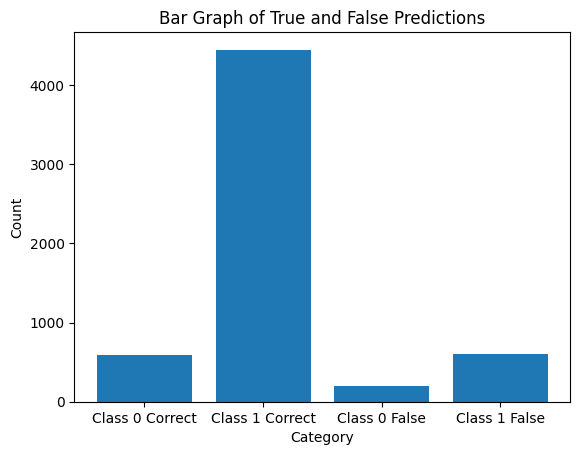

Accuracy : 0.8619390202124015
Precision : 0.8127107201139856
Recall : 0.7248013844664382
True Negatives : 588.0000
F1 Score (Macro) : 0.7550979238148494
AUC-ROC : 0.7248013844664382
Confusion Matrix : [[ 588  605]
 [ 201 4444]]
0.01 0.49999999999999994
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


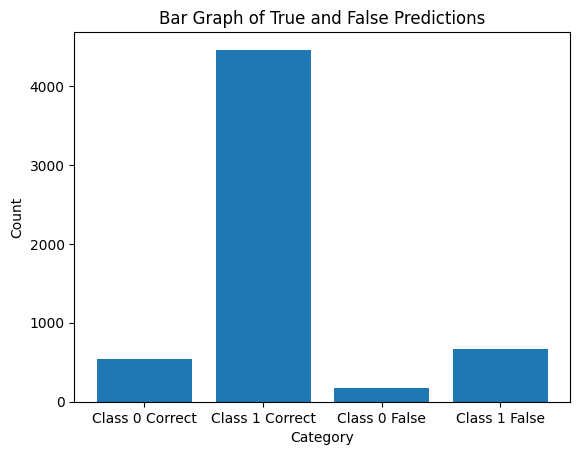

Accuracy : 0.8561151079136691
Precision : 0.8116758358619516
Recall : 0.7051199180543213
True Negatives : 539.0000
F1 Score (Macro) : 0.7379802909235619
AUC-ROC : 0.7051199180543213
Confusion Matrix : [[ 539  663]
 [ 177 4459]]
0.01 0.5499999999999999
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


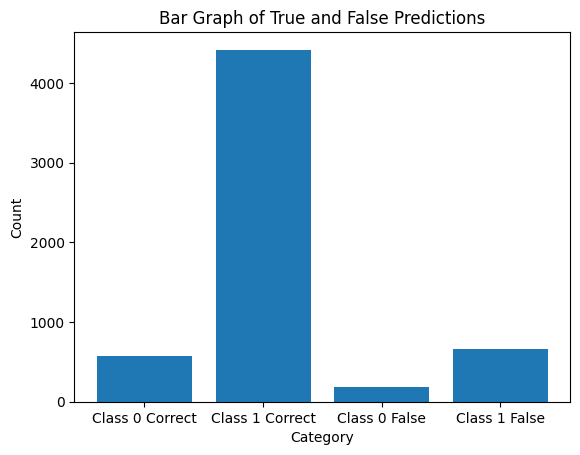

Accuracy : 0.854230900993491
Precision : 0.8109941405395951
Recall : 0.7104340199349591
True Negatives : 569.0000
F1 Score (Macro) : 0.742148555986386
AUC-ROC : 0.710434019934959
Confusion Matrix : [[ 569  664]
 [ 187 4418]]
0.01 0.6
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


Accuracy : 0.8590270640630353
Precision : 0.8050410192219657
Recall : 0.7086017294155236
True Negatives : 533.0000
F1 Score (Macro) : 0.7401143022936997
AUC-ROC : 0.7086017294155235
Confusion Matrix : [[ 533  629]
 [ 194 4482]]
0.01 0.65
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


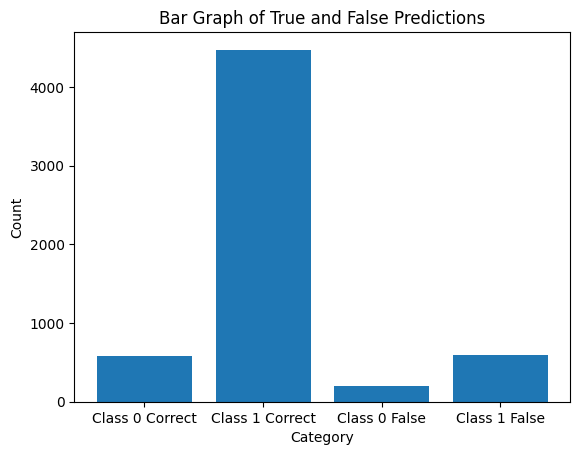

Accuracy : 0.8651935594381638
Precision : 0.813937415040964
Recall : 0.7260247665109307
True Negatives : 576.0000
F1 Score (Macro) : 0.7566474822117725
AUC-ROC : 0.7260247665109307
Confusion Matrix : [[ 576  589]
 [ 198 4475]]
0.01 0.7000000000000001
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


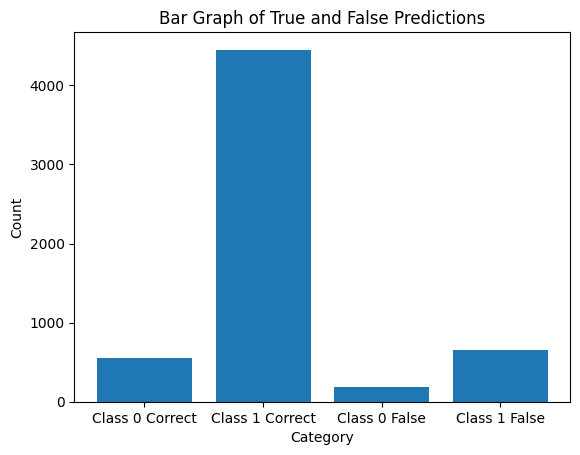

Accuracy : 0.8569715656046591
Precision : 0.811626214271717
Recall : 0.7094905200188697
True Negatives : 552.0000
F1 Score (Macro) : 0.7418051431344728
AUC-ROC : 0.7094905200188697
Confusion Matrix : [[ 552  652]
 [ 183 4451]]
0.01 0.7500000000000001
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


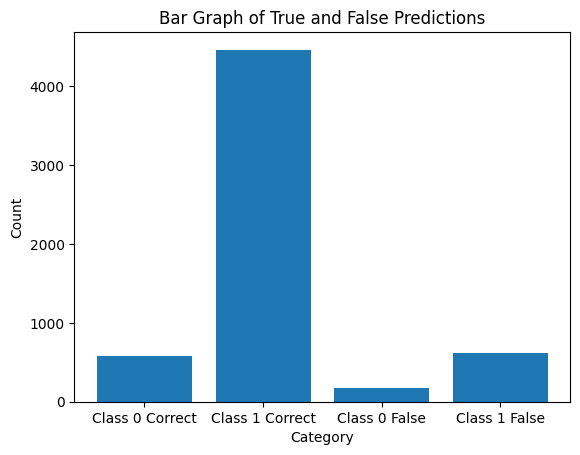

Accuracy : 0.8638232271325796
Precision : 0.8214534279387173
Recall : 0.72392565194865
True Negatives : 583.0000
F1 Score (Macro) : 0.756381188187673
AUC-ROC : 0.7239256519486501
Confusion Matrix : [[ 583  615]
 [ 180 4460]]
0.01 0.8000000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


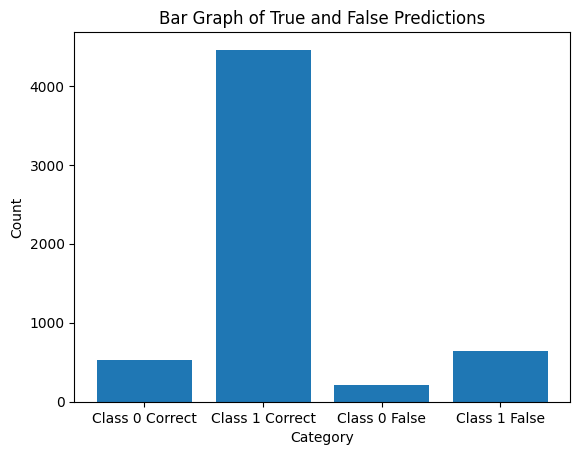

Accuracy : 0.854573484069887
Precision : 0.7950023430474815
Recall : 0.7048419759324785
True Negatives : 532.0000
F1 Score (Macro) : 0.7346167419274334
AUC-ROC : 0.7048419759324787
Confusion Matrix : [[ 532  637]
 [ 212 4457]]
0.01 0.8500000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


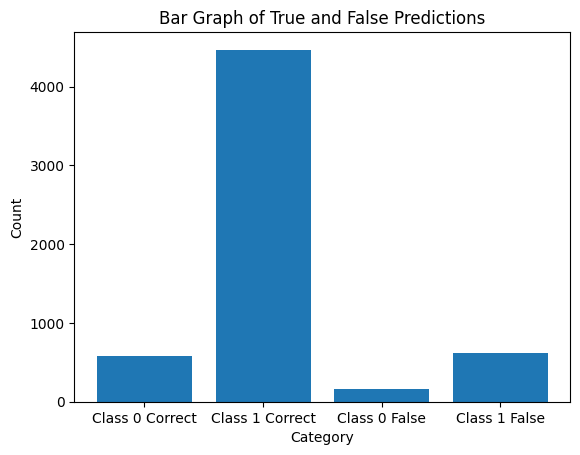

Accuracy : 0.8653648509763617
Precision : 0.8288391858562448
Recall : 0.7245166149748378
True Negatives : 584.0000
F1 Score (Macro) : 0.7584503232862313
AUC-ROC : 0.7245166149748378
Confusion Matrix : [[ 584  621]
 [ 165 4468]]
0.01 0.9000000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


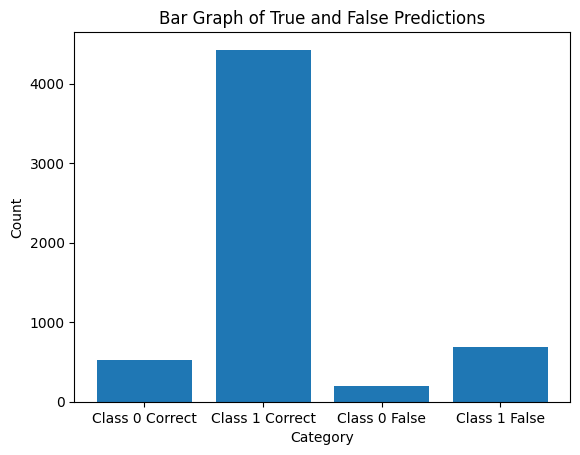

Accuracy : 0.8487495717711545
Precision : 0.7972280422664546
Recall : 0.6963889623273861
True Negatives : 529.0000
F1 Score (Macro) : 0.7271881045543058
AUC-ROC : 0.6963889623273861
Confusion Matrix : [[ 529  686]
 [ 197 4426]]
0.01 0.9500000000000003
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


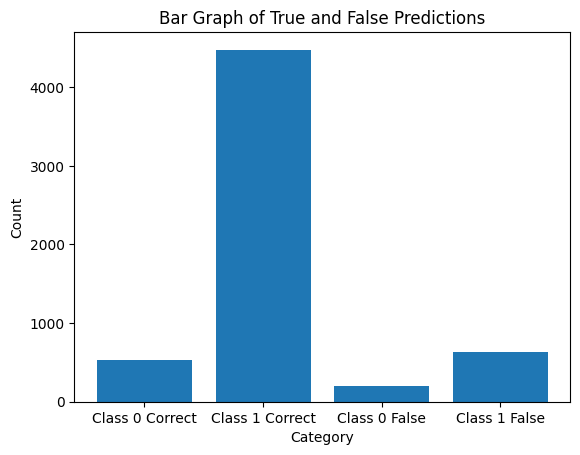

Accuracy : 0.8568002740664611
Precision : 0.7992285112148125
Recall : 0.705133714673232
True Negatives : 526.0000
F1 Score (Macro) : 0.7358963414211799
AUC-ROC : 0.7051337146732319
Confusion Matrix : [[ 526  634]
 [ 202 4476]]
0.1 0.2
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


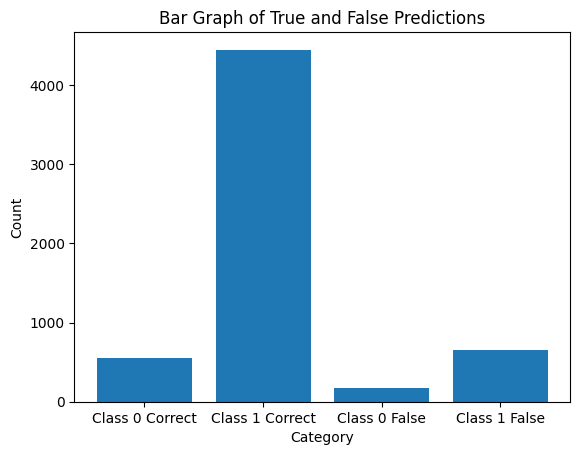

Accuracy : 0.8569715656046591
Precision : 0.8155517817942651
Recall : 0.7102087625763347
True Negatives : 558.0000
F1 Score (Macro) : 0.7430765845476383
AUC-ROC : 0.7102087625763347
Confusion Matrix : [[ 558  659]
 [ 176 4445]]
0.1 0.25
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858645239759146


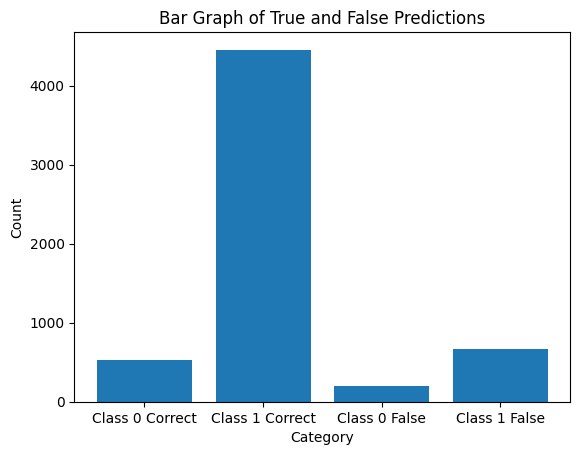

Accuracy : 0.8532031517643028
Precision : 0.8009293963610439
Recall : 0.7002467854611725
True Negatives : 526.0000
F1 Score (Macro) : 0.7316647075389847
AUC-ROC : 0.7002467854611725
Confusion Matrix : [[ 526  664]
 [ 193 4455]]
0.1 0.3
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


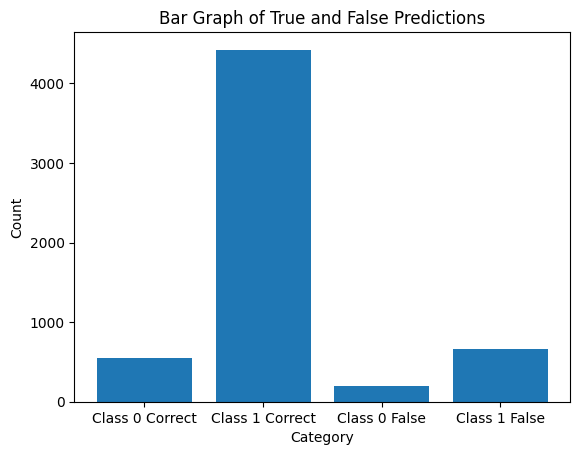

Accuracy : 0.8521754025351148
Precision : 0.803056069256946
Recall : 0.7052806389013286
True Negatives : 552.0000
F1 Score (Macro) : 0.7361871015959438
AUC-ROC : 0.7052806389013286
Confusion Matrix : [[ 552  666]
 [ 197 4423]]
0.1 0.35
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


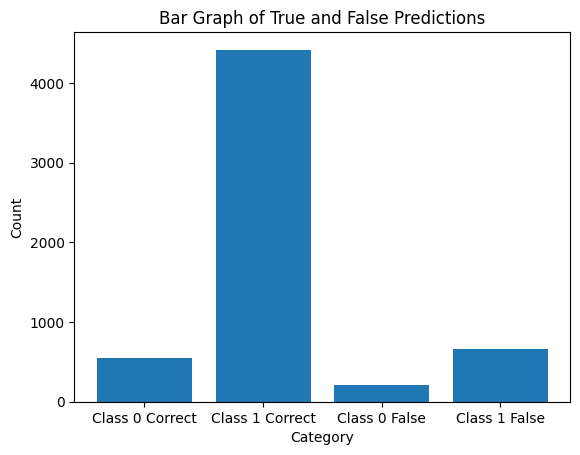

Accuracy : 0.8508050702295307
Precision : 0.7971485314637424
Recall : 0.7043079794360759
True Negatives : 550.0000
F1 Score (Macro) : 0.7341723930532129
AUC-ROC : 0.704307979436076
Confusion Matrix : [[ 550  662]
 [ 209 4417]]
0.1 0.39999999999999997
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858645239759146


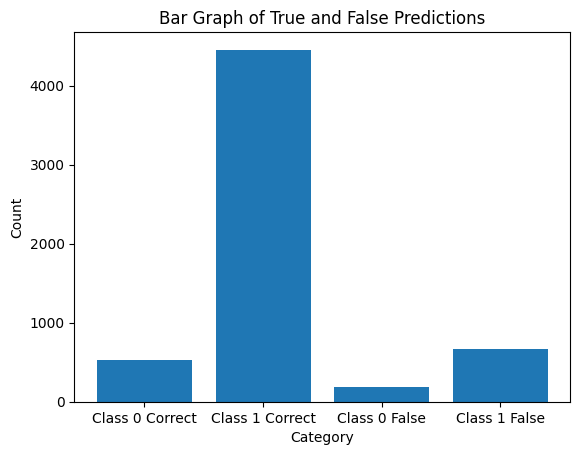

Accuracy : 0.8540596094552929
Precision : 0.803552217906806
Recall : 0.7020960987894039
True Negatives : 531.0000
F1 Score (Macro) : 0.7337908684368213
AUC-ROC : 0.7020960987894039
Confusion Matrix : [[ 531  662]
 [ 190 4455]]
0.1 0.44999999999999996
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


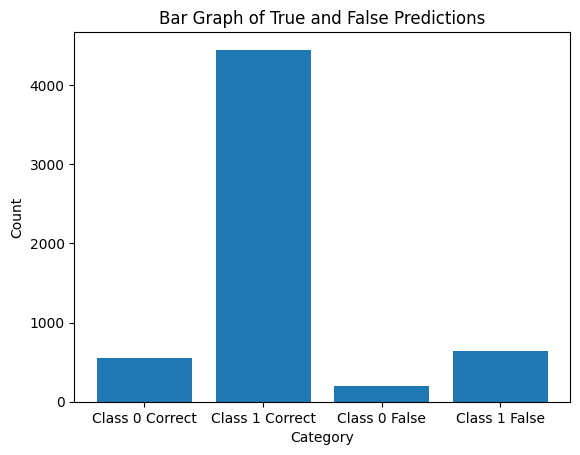

Accuracy : 0.8564576909900651
Precision : 0.8033329807613205
Recall : 0.7103819653064437
True Negatives : 551.0000
F1 Score (Macro) : 0.740984464078476
AUC-ROC : 0.7103819653064437
Confusion Matrix : [[ 551  636]
 [ 202 4449]]
0.1 0.49999999999999994
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


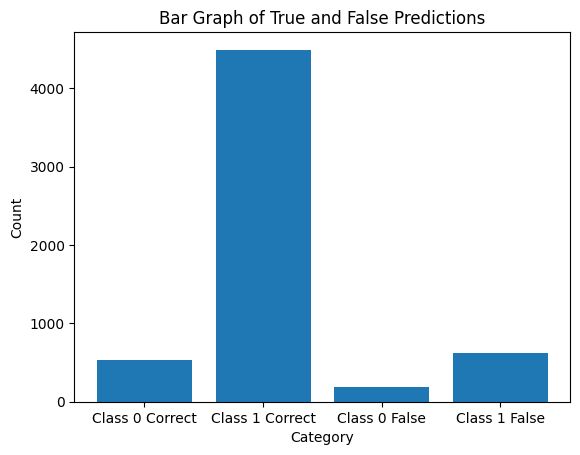

Accuracy : 0.8610825625214115
Precision : 0.808574676568084
Recall : 0.711566139674948
True Negatives : 537.0000
F1 Score (Macro) : 0.7434650508627666
AUC-ROC : 0.711566139674948
Confusion Matrix : [[ 537  621]
 [ 190 4490]]
0.1 0.5499999999999999
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


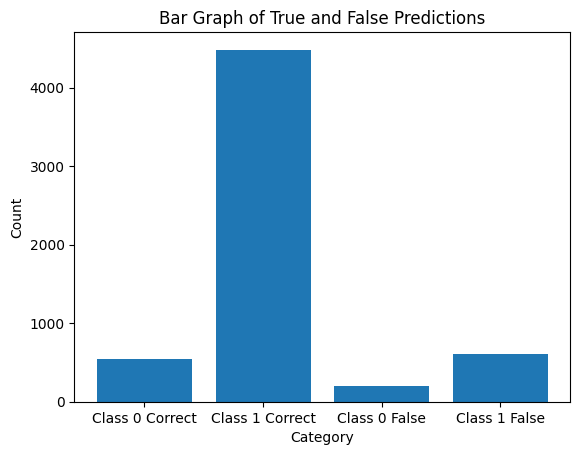

Accuracy : 0.8600548132922233
Precision : 0.8023884807914458
Recall : 0.7119474962356831
True Negatives : 538.0000
F1 Score (Macro) : 0.7424488581294924
AUC-ROC : 0.7119474962356831
Confusion Matrix : [[ 538  613]
 [ 204 4483]]
0.1 0.6
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858645239759146


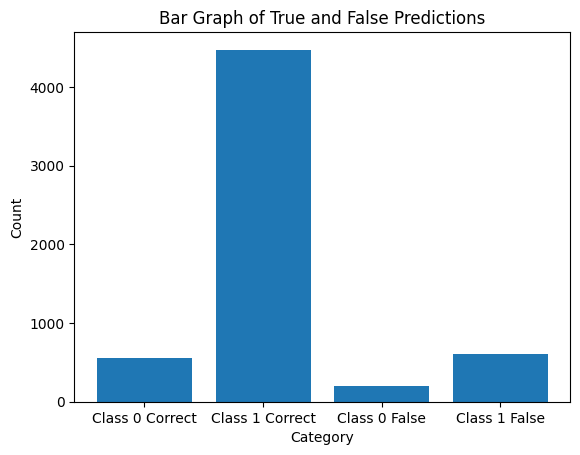

Accuracy : 0.8626241863651936
Precision : 0.8094677438369848
Recall : 0.7200139839162906
True Negatives : 562.0000
F1 Score (Macro) : 0.7506682642383576
AUC-ROC : 0.7200139839162906
Confusion Matrix : [[ 562  602]
 [ 200 4474]]
0.1 0.65
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


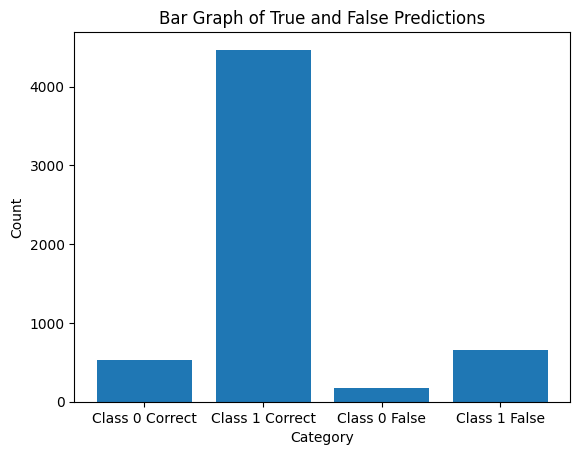

Accuracy : 0.8574854402192532
Precision : 0.812416979750731
Recall : 0.7058911902278644
True Negatives : 536.0000
F1 Score (Macro) : 0.7389419951361633
AUC-ROC : 0.7058911902278644
Confusion Matrix : [[ 536  656]
 [ 176 4470]]
0.1 0.7000000000000001
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


Accuracy : 0.854916067146283
Precision : 0.80779636337143
Recall : 0.7127037317010214
True Negatives : 572.0000
F1 Score (Macro) : 0.7435654041534867
AUC-ROC : 0.7127037317010214
Confusion Matrix : [[ 572  650]
 [ 197 4419]]
0.1 0.7500000000000001
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858645239759146


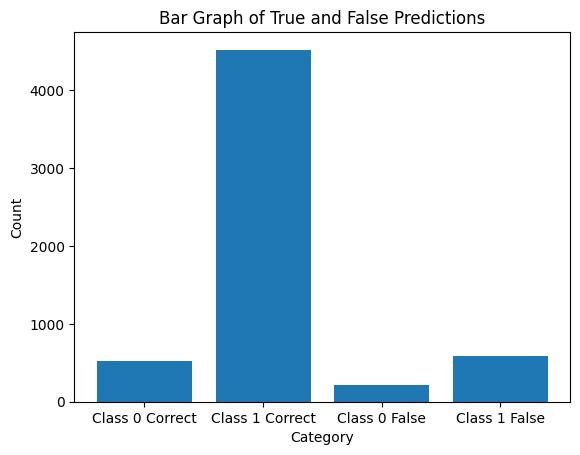

Accuracy : 0.8636519355943817
Precision : 0.7993904270496991
Recall : 0.7130152799932835
True Negatives : 521.0000
F1 Score (Macro) : 0.7430049058070447
AUC-ROC : 0.7130152799932835
Confusion Matrix : [[ 521  587]
 [ 209 4521]]
0.1 0.8000000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


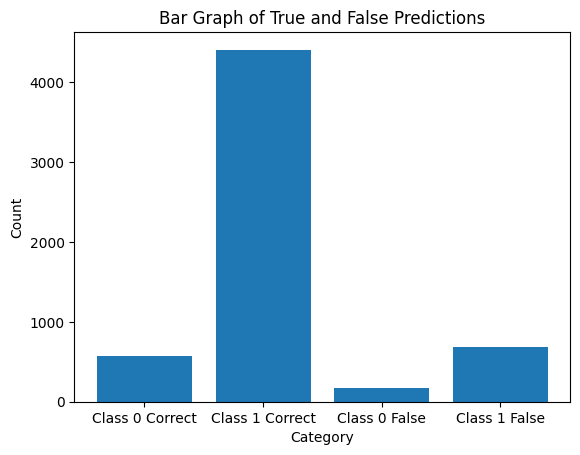

Accuracy : 0.8530318602261048
Precision : 0.8155027427675231
Recall : 0.709085456124444
True Negatives : 573.0000
F1 Score (Macro) : 0.7415733050028974
AUC-ROC : 0.709085456124444
Confusion Matrix : [[ 573  682]
 [ 176 4407]]
0.1 0.8500000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.8587137622435886


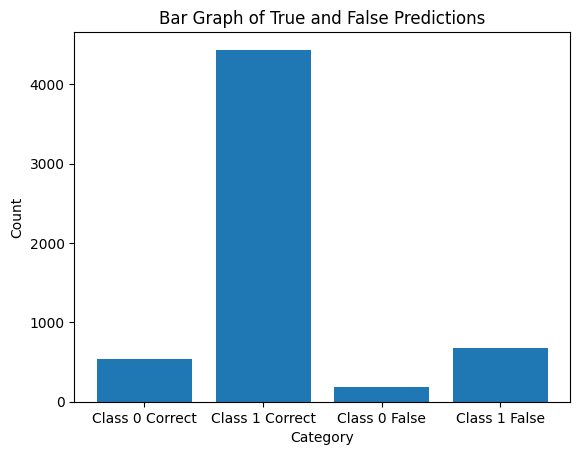

Accuracy : 0.8530318602261048
Precision : 0.8076772542525967
Recall : 0.7034034930586655
True Negatives : 544.0000
F1 Score (Macro) : 0.7354573484069886
AUC-ROC : 0.7034034930586655
Confusion Matrix : [[ 544  674]
 [ 184 4436]]
0.1 0.9000000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


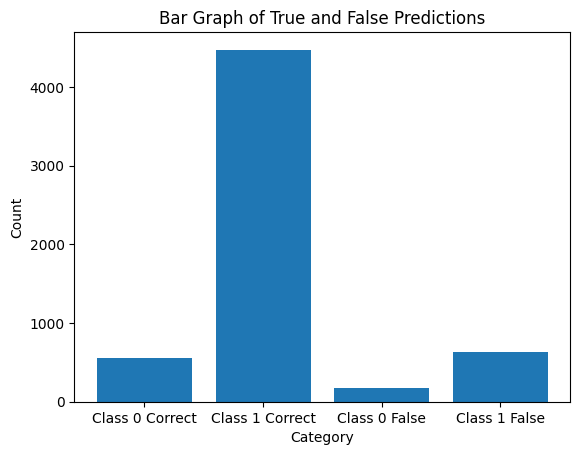

Accuracy : 0.8602261048304214
Precision : 0.814888114011665
Recall : 0.7124333218553972
True Negatives : 550.0000
F1 Score (Macro) : 0.7452530887436257
AUC-ROC : 0.7124333218553971
Confusion Matrix : [[ 550  637]
 [ 179 4472]]
0.1 0.9500000000000003
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858645239759146


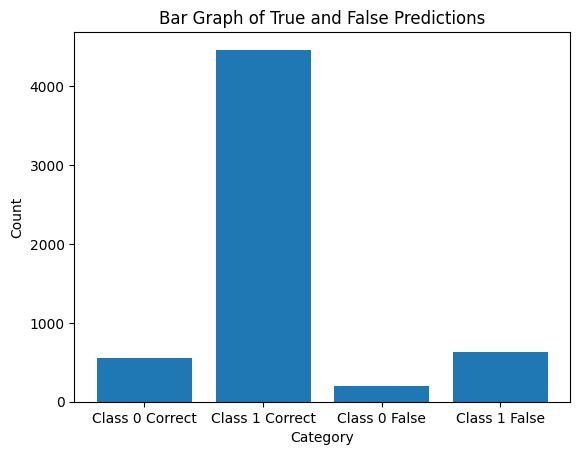

Accuracy : 0.8585131894484412
Precision : 0.8054797901623982
Recall : 0.7128361884914418
True Negatives : 552.0000
F1 Score (Macro) : 0.7436340031621849
AUC-ROC : 0.7128361884914418
Confusion Matrix : [[ 552  626]
 [ 200 4460]]
0.15 0.2
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858645239759146


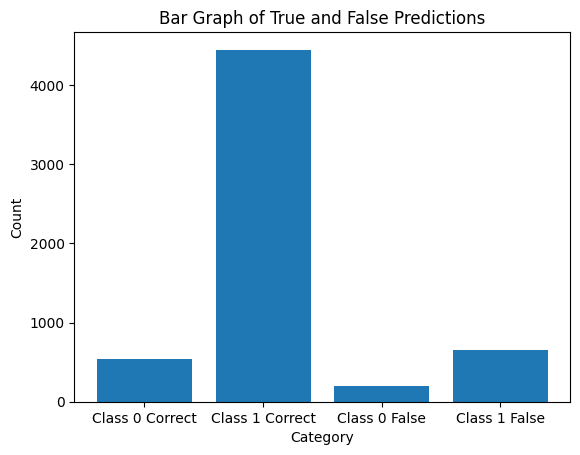

Accuracy : 0.854230900993491
Precision : 0.8023196531224108
Recall : 0.7043840234161061
True Negatives : 538.0000
F1 Score (Macro) : 0.7355449493762032
AUC-ROC : 0.7043840234161061
Confusion Matrix : [[ 538  655]
 [ 196 4449]]
0.15 0.25
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858645239759146


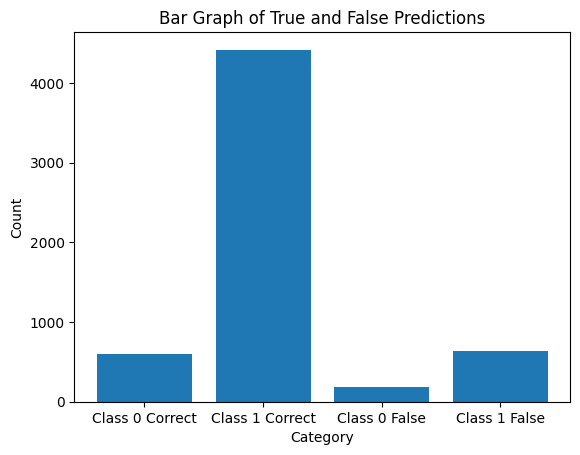

Accuracy : 0.8591983556012333
Precision : 0.8189959155407316
Recall : 0.7222139593169706
True Negatives : 599.0000
F1 Score (Macro) : 0.7539704446832421
AUC-ROC : 0.7222139593169707
Confusion Matrix : [[ 599  637]
 [ 185 4417]]
0.15 0.3
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


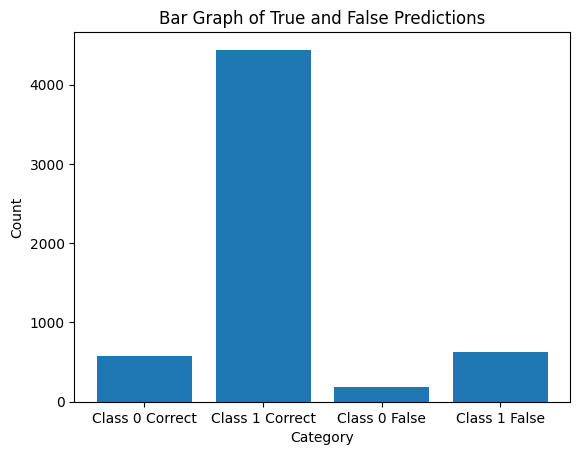

Accuracy : 0.8598835217540254
Precision : 0.8151789170668227
Recall : 0.7189360347860912
True Negatives : 578.0000
F1 Score (Macro) : 0.7506502278538753
AUC-ROC : 0.7189360347860912
Confusion Matrix : [[ 578  630]
 [ 188 4442]]
0.15 0.35
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858645239759146


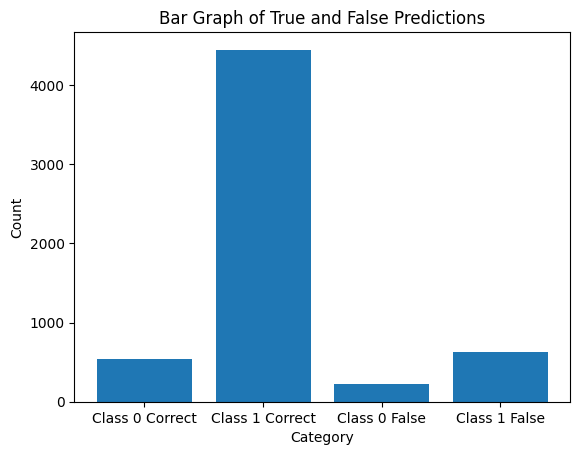

Accuracy : 0.855258650222679
Precision : 0.7947840908154945
Recall : 0.70956432842329
True Negatives : 546.0000
F1 Score (Macro) : 0.7384969171896568
AUC-ROC : 0.70956432842329
Confusion Matrix : [[ 546  625]
 [ 220 4447]]
0.15 0.39999999999999997
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


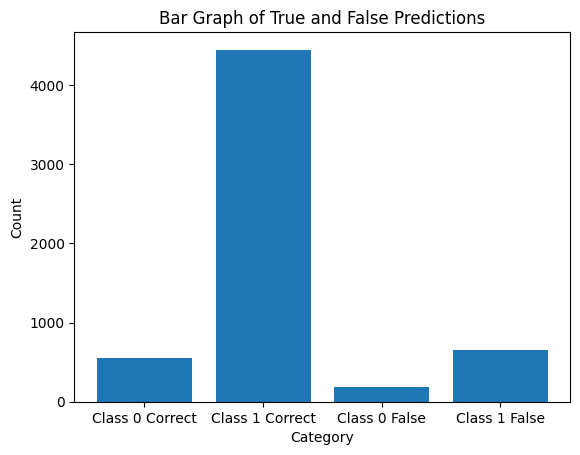

Accuracy : 0.855943816375471
Precision : 0.8076789980940859
Recall : 0.7090176496176204
True Negatives : 552.0000
F1 Score (Macro) : 0.7405922133145099
AUC-ROC : 0.7090176496176204
Confusion Matrix : [[ 552  650]
 [ 191 4445]]
0.15 0.44999999999999996
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858645239759146


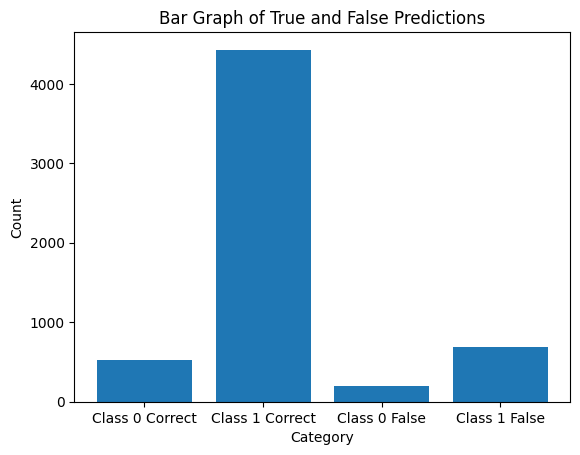

Accuracy : 0.8484069886947585
Precision : 0.7969990172693782
Recall : 0.6947298458582968
True Negatives : 524.0000
F1 Score (Macro) : 0.725663998278786
AUC-ROC : 0.6947298458582968
Confusion Matrix : [[ 524  690]
 [ 195 4429]]
0.15 0.49999999999999994
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


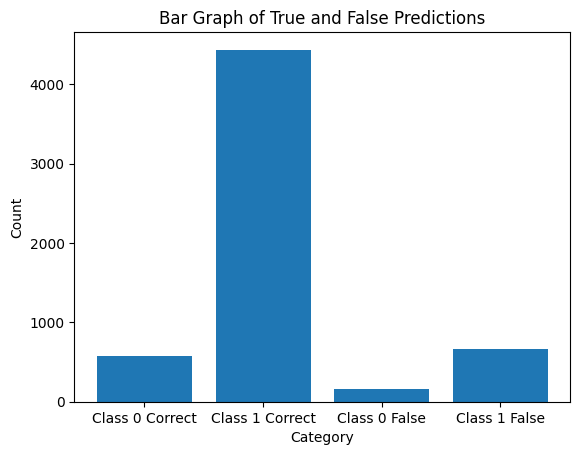

Accuracy : 0.8581706063720452
Precision : 0.8239284361788151
Recall : 0.7142120062946624
True Negatives : 575.0000
F1 Score (Macro) : 0.7480084601476209
AUC-ROC : 0.7142120062946624
Confusion Matrix : [[ 575  664]
 [ 164 4435]]
0.15 0.5499999999999999
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


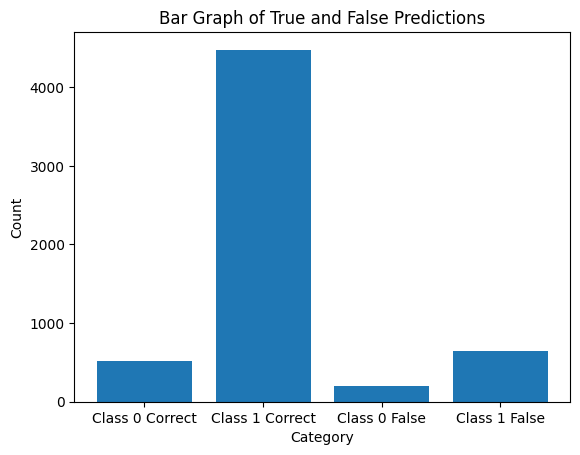

Accuracy : 0.855429941760877
Precision : 0.7997570767227661
Recall : 0.7008291063582321
True Negatives : 517.0000
F1 Score (Macro) : 0.7322228504611035
AUC-ROC : 0.7008291063582321
Confusion Matrix : [[ 517  649]
 [ 195 4477]]
0.15 0.6
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


Accuracy : 0.8588557725248372
Precision : 0.7977328237990038
Recall : 0.7224787423373542
True Negatives : 579.0000
F1 Score (Macro) : 0.7496286466792009
AUC-ROC : 0.7224787423373542
Confusion Matrix : [[ 579  591]
 [ 233 4435]]
0.15 0.65
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


Accuracy : 0.8573141486810552
Precision : 0.808355946913933
Recall : 0.7043864866326195
True Negatives : 528.0000
F1 Score (Macro) : 0.7369565173883984
AUC-ROC : 0.7043864866326195
Confusion Matrix : [[ 528  651]
 [ 182 4477]]
0.15 0.7000000000000001
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


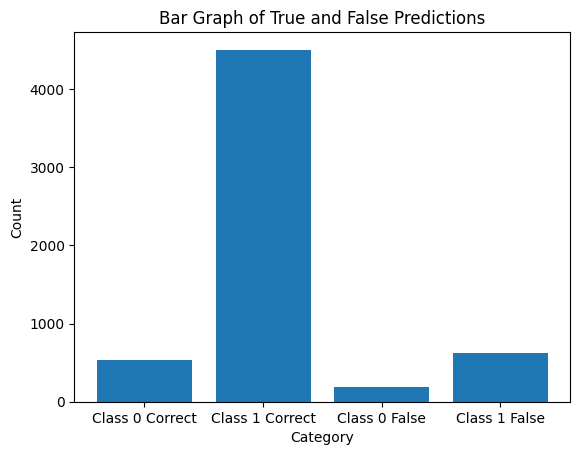

Accuracy : 0.8615964371360055
Precision : 0.8083631351421132
Recall : 0.7101532557449327
True Negatives : 529.0000
F1 Score (Macro) : 0.7423116381669731
AUC-ROC : 0.7101532557449327
Confusion Matrix : [[ 529  620]
 [ 188 4501]]
0.15 0.7500000000000001
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


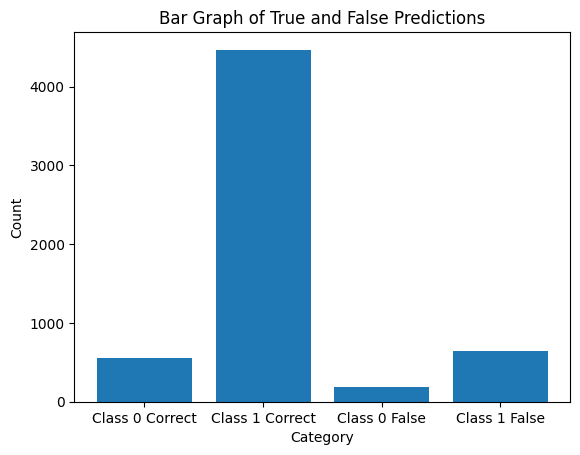

Accuracy : 0.8593696471394313
Precision : 0.813109617101064
Recall : 0.7117126936691667
True Negatives : 550.0000
F1 Score (Macro) : 0.7442282298403546
AUC-ROC : 0.7117126936691667
Confusion Matrix : [[ 550  639]
 [ 182 4467]]
0.15 0.8000000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


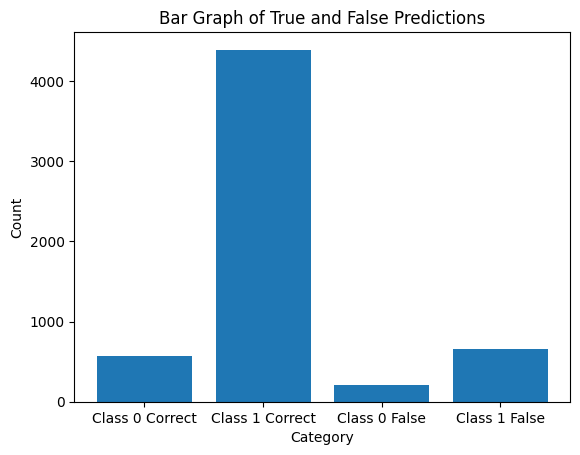

Accuracy : 0.8497773210003425
Precision : 0.7982501072812218
Recall : 0.7083332380484124
True Negatives : 572.0000
F1 Score (Macro) : 0.7376113214151461
AUC-ROC : 0.7083332380484124
Confusion Matrix : [[ 572  663]
 [ 214 4389]]
0.15 0.8500000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


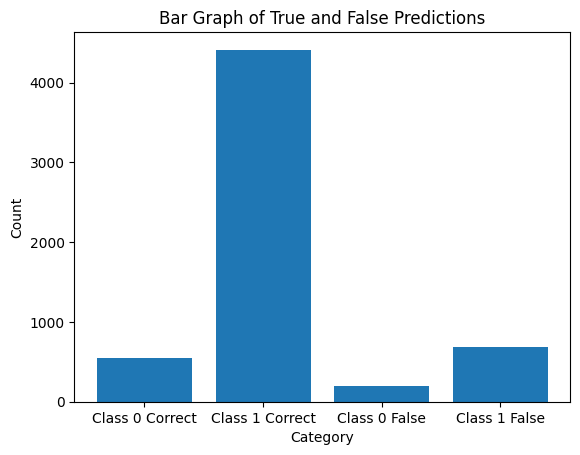

Accuracy : 0.8496060294621446
Precision : 0.8010093006723734
Recall : 0.7010545690928233
True Negatives : 546.0000
F1 Score (Macro) : 0.7319276056152404
AUC-ROC : 0.7010545690928233
Confusion Matrix : [[ 546  682]
 [ 196 4414]]
0.15 0.9000000000000002
Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.858679503935949


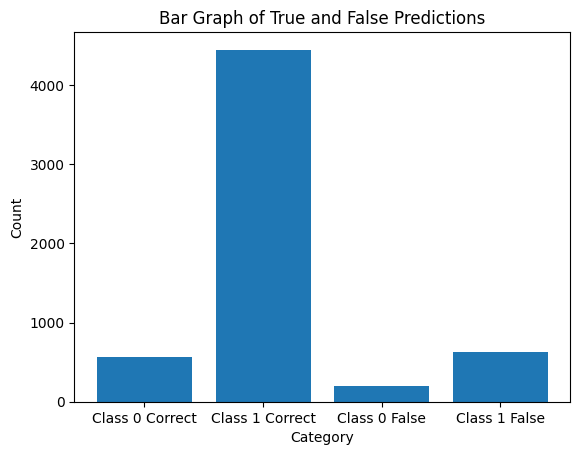

Accuracy : 0.8585131894484412
Precision : 0.8105436086123828
Recall : 0.7152281280602989
True Negatives : 566.0000
F1 Score (Macro) : 0.7465720236091908
AUC-ROC : 0.7152281280602988
Confusion Matrix : [[ 566  633]
 [ 193 4446]]
0.15 0.9500000000000003
0.01 0.7000000000000001


In [229]:
C3_params = {
    'C': [1.0, 2.0, 3.0, 4.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

dfmin, dfmax = findBest(C3_params, cutoff3, '1', 3.0, 'l2', 'liblinear')
print(dfmin, dfmax)

Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8188012902534382


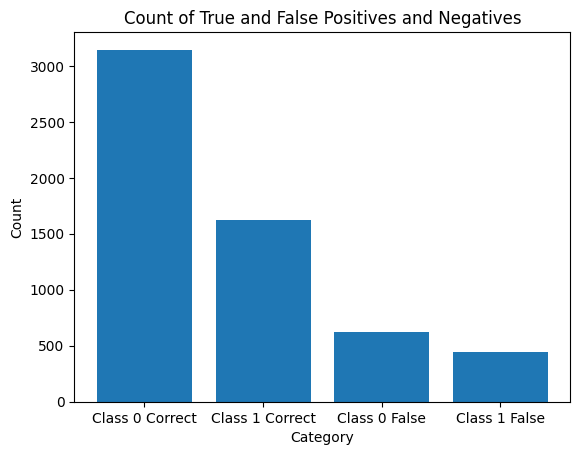

Accuracy : 0.817060637204522
Precision : 0.8098721815681353
Recall : 0.7994990126567505
True Negatives : 3144.0000
F1 Score (Macro) : 0.8037950879100961
AUC-ROC : 0.7994990126567506
Confusion Matrix : [[3144  445]
 [ 623 1626]]


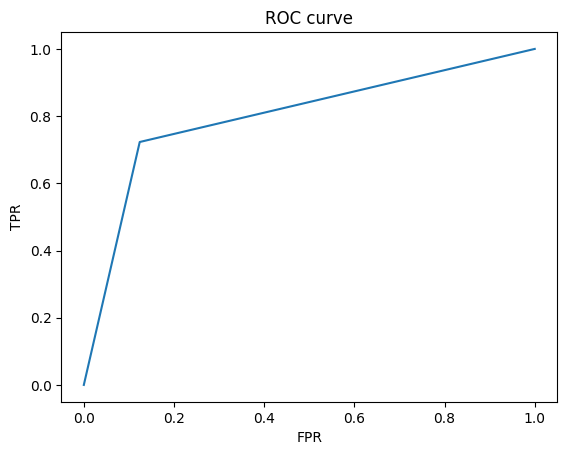

In [273]:
# Execution of the optimal parameters

x_training, x_testing = Vectorize((1,3), 0.0001, 0.999, 10000)

linear_regression(C3_params, cutoff3, '3', 2.0, 'l2', 'liblinear')

Cutoff = 4

Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8541574308041758


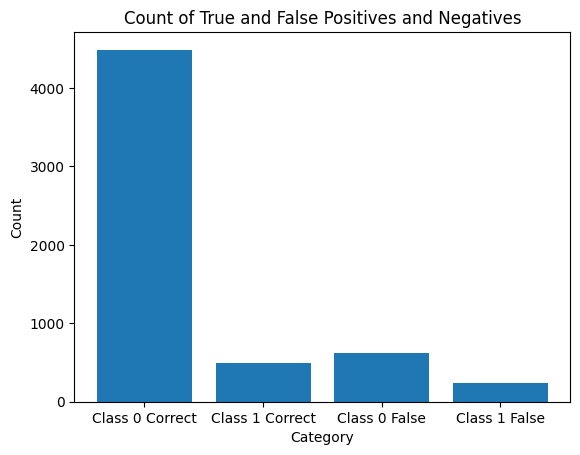

Accuracy : 0.8532031517643028
Precision : 0.7762315951018731
Recall : 0.6965918825857622
True Negatives : 4488.0000
F1 Score (Macro) : 0.7239208951177556
AUC-ROC : 0.6965918825857623
Confusion Matrix : [[4488  239]
 [ 618  493]]


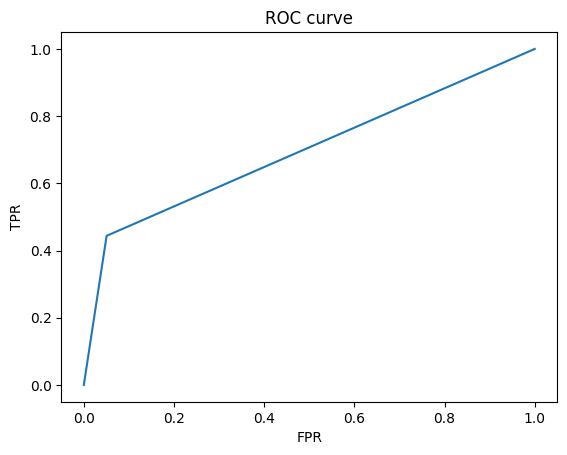

In [275]:
C4_params = {
    'C': [1.0, 2.0, 3.0, 4.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Execution of the optimal parameters

x_training, x_testing = Vectorize((1,3), 0.001, 0.999, 10000)

linear_regression(C4_params, cutoff4, '4', 2.0, 'l2', 'liblinear')

## Naive Bayes 

In [276]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()

In [301]:
# Function to run the Naive Bayes classifier for binary classification
def naiveBayes(NB_params, cutoff_value, cutoffID):
    NB_grid_search = GridSearchCV(NB_classifier, NB_params, cv = kf) #Use GridSeachCV to find the best hyperparameters
    NB_grid_search.fit(x_training, cutoff_value)

    print("Best Hyperparameters:", NB_grid_search.best_params_) #Print best hyperparameters
    print("Best Score:", NB_grid_search.best_score_)

    NB_param = NB_grid_search.best_params_

    x_train, x_test, y_train, y_test = train_test_split(x_training, cutoff_value, test_size = 0.2)

    NB = MultinomialNB(alpha = NB_param['alpha'], fit_prior = NB_param['fit_prior'])
    NB.fit(x_train, y_train)

    predictions = NB.predict(x_test)

    res=binary_results(predictions, y_test)
    for i in res:
        print(i,':', res[i]) #print the best scores for the Naive Bayes classifier run

    fpr_NB, tpr_NB, thresholds_NB = roc_curve(y_test, predictions)

    #plot ROC curve
    plt.plot(fpr_NB, tpr_NB)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    
    # return csv file for kaggle
    NB_kaggle = MultinomialNB()
    NB_kaggle.fit(x_training, cutoff_value)
    csvID = 'NB_cutoff'+cutoffID+' predictions.csv'
    c_kaggle = NB_kaggle.predict(x_test)
    bsplit = 'binary_split_'+cutoffID
    c_predictions_df = pd.DataFrame(c_kaggle, columns=[bsplit])
    c_predictions_df.index.name = 'id'
    c_predictions_df.to_csv(csvID)

Cutoff = 1

Best Hyperparameters: {'alpha': 9.7, 'fit_prior': False}
Best Score: 0.8556304793410432


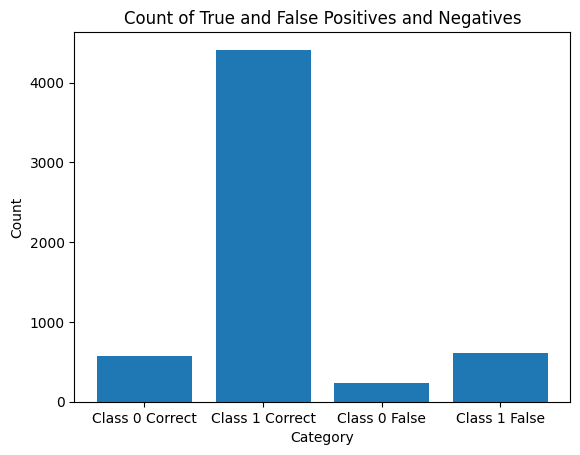

Accuracy : 0.855258650222679
Precision : 0.7963493326261822
Recall : 0.7178001023191437
True Negatives : 579.0000
F1 Score (Macro) : 0.7453881206516495
AUC-ROC : 0.7178001023191437
Confusion Matrix : [[ 579  614]
 [ 231 4414]]


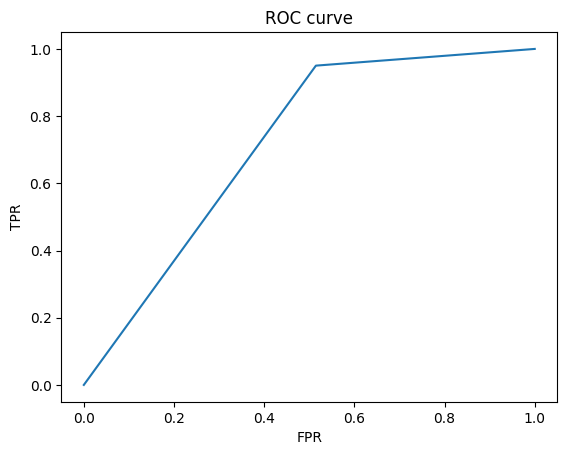

In [302]:
NB_param1 = {
    'alpha': [9.6, 9.7, 9.8],
    'fit_prior': [True, False]
}


naiveBayes(NB_param1, cutoff1, '1')


Cutoff = 2

Best Hyperparameters: {'alpha': 7.0, 'fit_prior': False}
Best Score: 0.8034192220858033


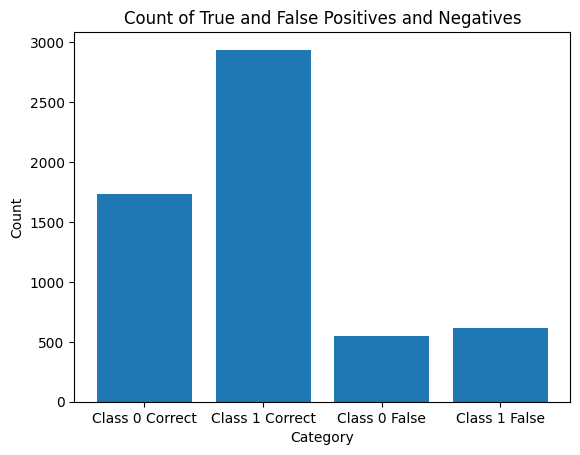

Accuracy : 0.8004453579993148
Precision : 0.7930536343430044
Recall : 0.7903436342718422
True Negatives : 1735.0000
F1 Score (Macro) : 0.7915960562015637
AUC-ROC : 0.7903436342718422
Confusion Matrix : [[1735  614]
 [ 551 2938]]


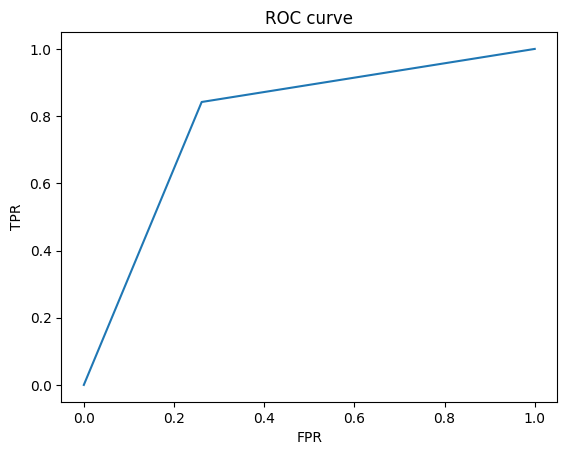

In [303]:
NB_param2 = {
    'alpha': [6.5, 7.0, 7.5],
    'fit_prior': [True, False]
}

naiveBayes(NB_param2, cutoff2, '2')

Cutoff = 3

Best Hyperparameters: {'alpha': 6.5, 'fit_prior': False}
Best Score: 0.8072559529898781


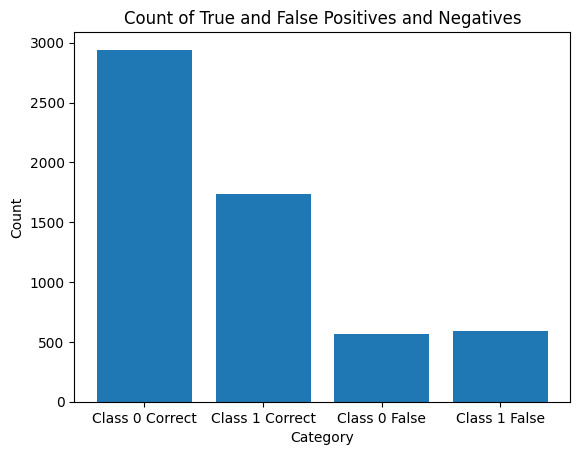

Accuracy : 0.8016443987667009
Precision : 0.7924014565502362
Recall : 0.7933506645026643
True Negatives : 2941.0000
F1 Score (Macro) : 0.7928635334143854
AUC-ROC : 0.7933506645026644
Confusion Matrix : [[2941  590]
 [ 568 1739]]


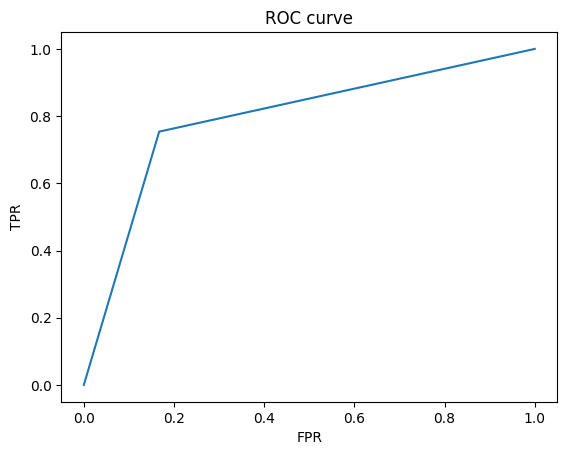

In [304]:
NB_param3 = {
    'alpha': [6, 6.5, 7.0, 7.5],
    'fit_prior': [True, False]
}

naiveBayes(NB_param3, cutoff3, '3')

Cutoff = 4

Best Hyperparameters: {'alpha': 9, 'fit_prior': False}
Best Score: 0.832710902669724


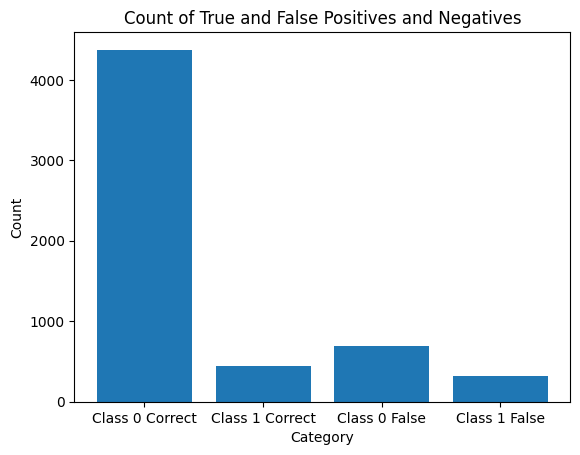

Accuracy : 0.8256252141144228
Precision : 0.7214330406835604
Recall : 0.6610589450778528
True Negatives : 4374.0000
F1 Score (Macro) : 0.681388254795728
AUC-ROC : 0.6610589450778529
Confusion Matrix : [[4374  323]
 [ 695  446]]


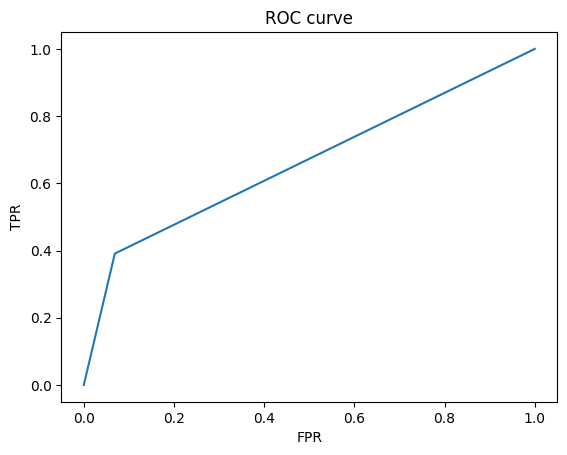

In [306]:
NB_param4 = {
    'alpha': [8.8, 9, 10],
    'fit_prior': [True, False]
}

naiveBayes(NB_param4, cutoff4, '4')

## Ridge Classifier

In [329]:
from sklearn.linear_model import RidgeClassifier
def ridgeClassifier(cutoff_params, cutoff_value, cutoffID, kaggle_alpha, kaggle_solver):
    classifier = RidgeClassifier()
    ridge_grid_search = GridSearchCV(classifier, param_grid=cutoff_params, cv=kf)
    ridge_grid_search.fit(x_training, cutoff_value)

    print("Best Hyperparameters:", ridge_grid_search.best_params_)
    print("Best Score:", ridge_grid_search.best_score_)

    ridge_params = ridge_grid_search.best_params_

    x_train, x_test, y_train, y_test = train_test_split(x_training, cutoff_value, test_size = 0.2)

    ridge = RidgeClassifier(alpha = ridge_params['alpha'], solver = ridge_params['solver'])
    ridge.fit(x_train, y_train)
    predictions = ridge.predict(x_test)
    res=binary_results(predictions, y_test)
    for i in res:
        print(i,':', res[i])
    
    # Plotting ROC Curve
    fpr_ridge, tpr_ridge, thresholds_ridge = roc_curve(y_test, predictions)
    plt.plot(fpr_ridge, tpr_ridge)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    
    # return csv file for kaggle
    ridge_kaggle = RidgeClassifier(alpha = kaggle_alpha, solver = kaggle_solver)
    ridge_kaggle.fit(x_training, cutoff_value)
    csvID = 'Ridge_cutoff'+cutoffID+' predictions.csv'
    c_kaggle = ridge_kaggle.predict(x_test)
    bsplit = 'binary_split_'+cutoffID
    c_predictions_df = pd.DataFrame(c_kaggle, columns=[bsplit])
    c_predictions_df.index.name = 'id'
    c_predictions_df.to_csv(csvID)

Best Hyperparameters: {'alpha': 1, 'solver': 'auto'}
Best Score: 0.863921236294696


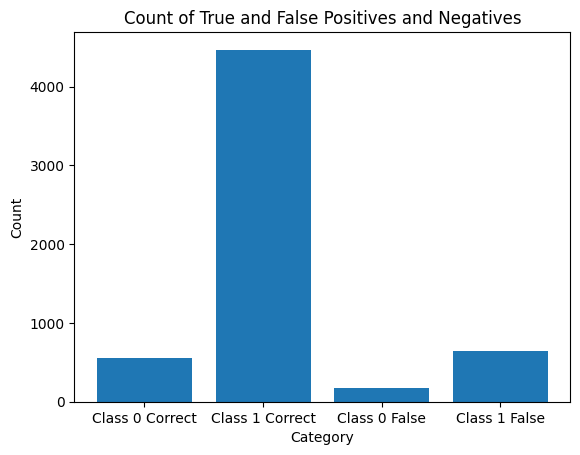

Accuracy : 0.8609112709832134
Precision : 0.8213084752777454
Recall : 0.7139940765965266
True Negatives : 558.0000
F1 Score (Macro) : 0.7477695179945413
AUC-ROC : 0.7139940765965267
Confusion Matrix : [[ 558  644]
 [ 168 4468]]


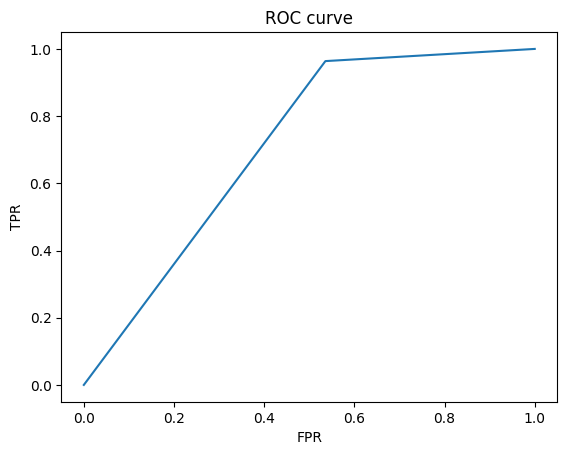

In [332]:
Ridge_param1 = {
    'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20],
    'solver': ['auto', 'lsqr', 'sparse_cg', 'sag']
}

ridgeClassifier(Ridge_param1, cutoff1, '1', 1, 'auto')

Cutoff = 2

Best Hyperparameters: {'alpha': 5, 'solver': 'lsqr'}
Best Score: 0.8074961250314953


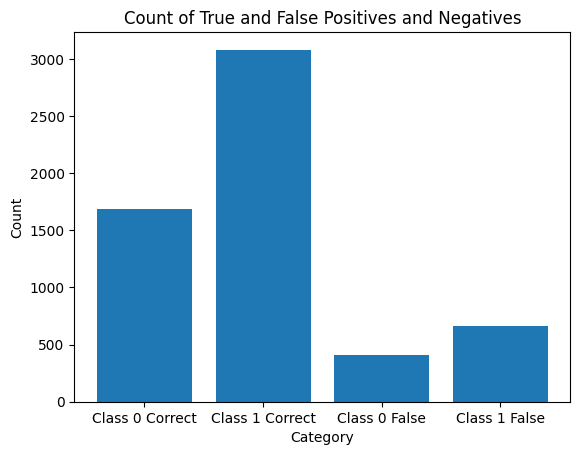

Accuracy : 0.816032887975334
Precision : 0.8133439859416176
Recall : 0.7998902040025743
True Negatives : 1684.0000
F1 Score (Macro) : 0.8048757200756795
AUC-ROC : 0.7998902040025744
Confusion Matrix : [[1684  663]
 [ 411 3080]]


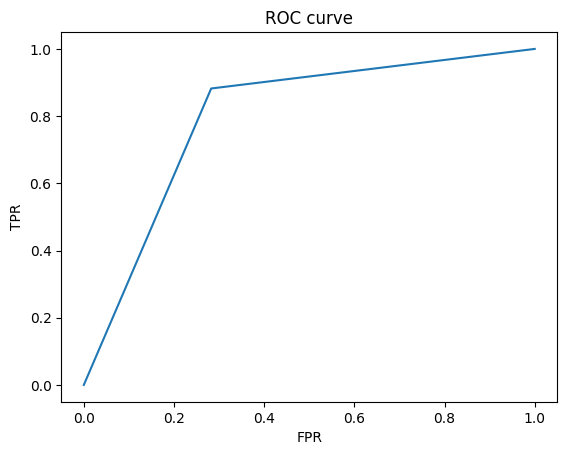

In [333]:
Ridge_param2 = {
    'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20],
    'solver': ['auto', 'lsqr', 'sparse_cg', 'sag']
}

ridgeClassifier(Ridge_param2, cutoff2, '2', 1, 'auto')

Cutoff = 3

Best Hyperparameters: {'alpha': 5, 'solver': 'lsqr'}
Best Score: 0.8147586514845493


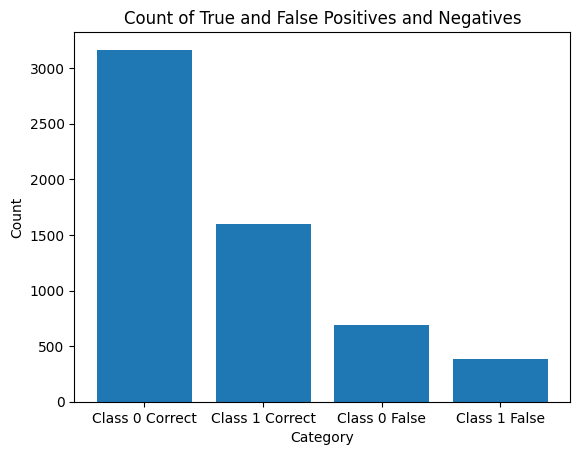

Accuracy : 0.81551901336074
Precision : 0.8129970655895251
Recall : 0.7945270565841431
True Negatives : 3166.0000
F1 Score (Macro) : 0.8011170485620024
AUC-ROC : 0.7945270565841431
Confusion Matrix : [[3166  386]
 [ 691 1595]]


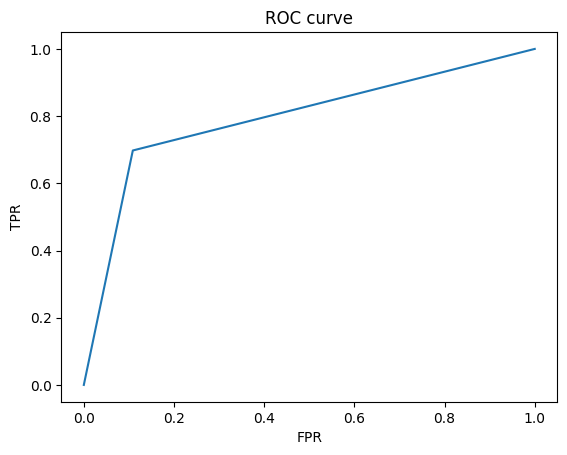

In [334]:
Ridge_param3 = {
    'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20],
    'solver': ['auto', 'lsqr', 'sparse_cg', 'sag']
}

ridgeClassifier(Ridge_param3, cutoff3, '3', 1, 'auto')

Cutoff = 4

Best Hyperparameters: {'alpha': 1, 'solver': 'lsqr'}
Best Score: 0.8491556122438499


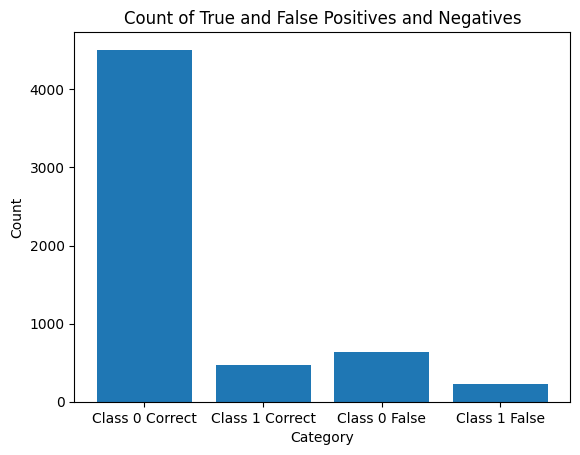

Accuracy : 0.8528605686879068
Precision : 0.7779220779220779
Recall : 0.6890778959098159
True Negatives : 4508.0000
F1 Score (Macro) : 0.7180277061266948
AUC-ROC : 0.689077895909816
Confusion Matrix : [[4508  222]
 [ 637  471]]


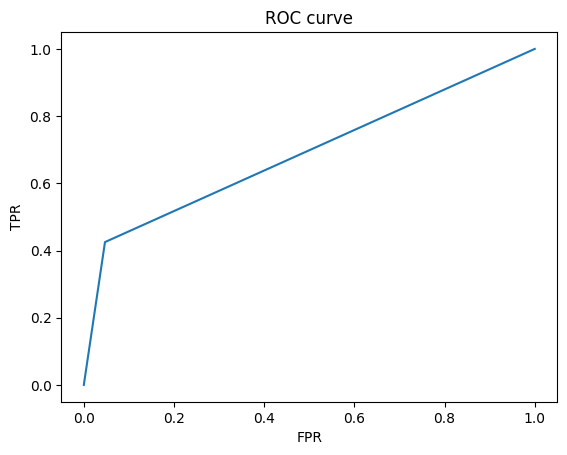

In [335]:
Ridge_param4 = {
    'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20],
    'solver': ['auto', 'lsqr', 'sparse_cg', 'sag']
}

ridgeClassifier(Ridge_param4, cutoff4, '4', 1, 'auto')

# Multiclass Classifier

### Logistic Regression

In [344]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
def multiclass_results(y_pred, y_actual):
    
    # Calculating accuracy
    accuracy = np.mean(y_pred == y_actual)
    # Calculating F1 score (macro average)
    f1_macro = f1_score(y_actual, y_pred, average='macro')
    # Calculating precision (macro average), recall (macro average), and AUC-ROC
    precision = precision_score(y_actual, y_pred, average='macro')
    recall = recall_score(y_actual, y_pred, average='macro')
    
    # Generate histogram of correct and incorrect predictions for each star rating
    labels = np.unique(y_actual)
    correct_counts = np.zeros(len(labels))
    incorrect_counts = np.zeros(len(labels))
    
    for label in labels:
        correct_counts[label-1] = np.sum((y_pred == y_actual) & (y_actual == label))
        incorrect_counts[label-1] = np.sum((y_pred != y_actual) & (y_actual == label))

    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, correct_counts, width, label='Correct')
    rects2 = ax.bar(x + width/2, incorrect_counts, width, label='Incorrect')

    ax.set_ylabel('Count')
    ax.set_xlabel('Star Rating')
    ax.set_title('Correct and Incorrect Predictions by Star Rating')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()
    
    # Calculating and displaying the confusion matrix
    cm = confusion_matrix(y_actual, y_pred)

    # Returning the metrics and information as a dictionary
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score (Macro)': f1_macro,
        'Confusion Matrix': cm
    }

In [353]:
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, auc

def roc_score(model, x, y):
    scoring = ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro', 'roc_auc_ovr']
    scores = cross_validate(model, x, y, cv=5, scoring=scoring)
    
    y_bin = label_binarize(y, classes=[0, 1, 2, 3, 4])
    
    pred_prob = cross_val_predict(model, x, y, cv=5, method='predict_proba')
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), pred_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure()
    
    for i in range(5):
        plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
    
    plt.plot(fpr["micro"], tpr["micro"], label='Average ROC (Micro-average) (AUC = {:.2f})'.format(roc_auc["micro"]))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    return scores


In [359]:
#output kaggle csv file for multiclass kaggle competition
def kaggleCSV(pred, classifier):
    predictions_df = pd.DataFrame(pred, columns=['label'])
    predictions_df.index.name = 'id'
    predictions_df.to_csv(classifier+'_multiclass_predictions.csv')

## Logistic Regression

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/

Best Hyperparameters: {'C': 1.0, 'multi_class': 'ovr', 'penalty': 'l2'}
Best Score: 0.4933022338095162


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


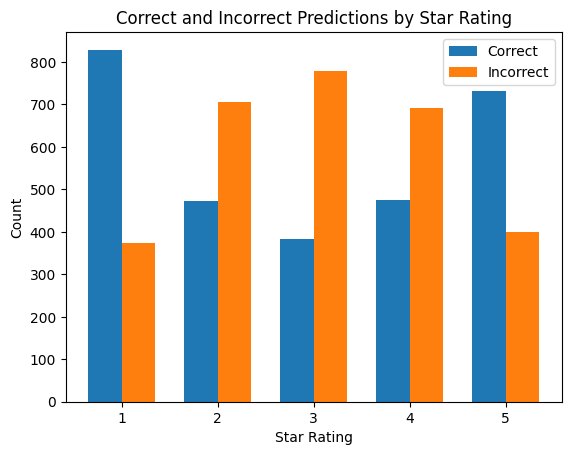

{'Accuracy': 0.4950325453922576, 'Precision': 0.48575881170716706, 'Recall': 0.4948490091375651, 'F1 Score (Macro)': 0.48832687334296915, 'Confusion Matrix': array([[829, 247,  64,  35,  27],
       [309, 473, 231, 105,  61],
       [122, 283, 383, 259, 115],
       [ 69, 110, 175, 474, 337],
       [ 39,  58,  73, 229, 731]])}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

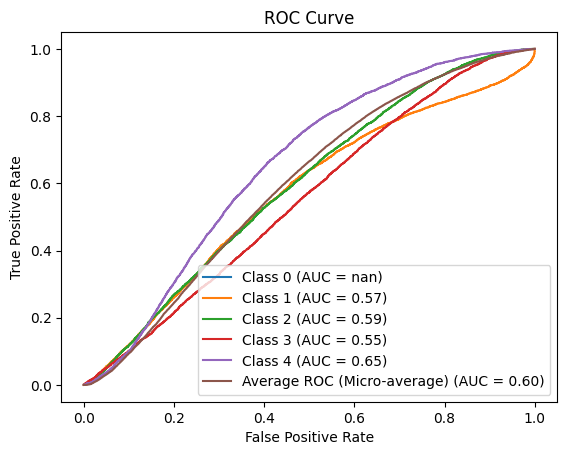

{'fit_time': array([1.87732387, 1.72800708, 1.91928506, 1.84042406, 1.83134985]),
 'score_time': array([0.02954888, 0.02482891, 0.02539086, 0.02401996, 0.02216721]),
 'test_accuracy': array([0.47207948, 0.45854745, 0.50650908, 0.49537513, 0.49563132]),
 'test_f1_macro': array([0.46255165, 0.45285428, 0.50014639, 0.49205322, 0.48379923]),
 'test_recall_macro': array([0.47192421, 0.45959645, 0.50700626, 0.49538974, 0.49627959]),
 'test_precision_macro': array([0.46073661, 0.4493891 , 0.49812876, 0.48976733, 0.48187737]),
 'test_roc_auc_ovr': array([0.7920571 , 0.77719137, 0.81238482, 0.80701711, 0.80867718])}

In [355]:
logReg = LogisticRegression(max_iter = 20000)

y = y.astype(int)
y = np.ravel(y)

parameters_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 2.0, 3.0],
    'multi_class': ['auto', 'ovr', 'multinomial'],
}

logReg_logr = GridSearchCV(logReg, parameters_grid, cv=kf)

logReg_logr.fit(x_training, y)

print("Best Hyperparameters:", logReg_logr.best_params_)
print("Best Score:", logReg_logr.best_score_)

logr_paramsMC = logReg_logr.best_params_

x_train, x_test, y_train, y_test = train_test_split(x_training, y, test_size = 0.2)

logRegMC = LogisticRegression(C = logr_paramsMC['C'], penalty = logr_paramsMC['penalty'], multi_class = logr_paramsMC['multi_class'])
logRegMC.fit(x_train, y_train)

y_pred = logRegMC.predict(x_test)

print(multiclass_results(y_pred, y_test))

roc_score(logRegMC, x_training, y)

In [360]:
# Kaggle CSV

kaggleCSV(logRegMC.predict(x_test), 'logReg')

## Naive Bayes

Best Hyperparameters: {'alpha': 10.0, 'fit_prior': False}
Best Score: 0.4929595450881763


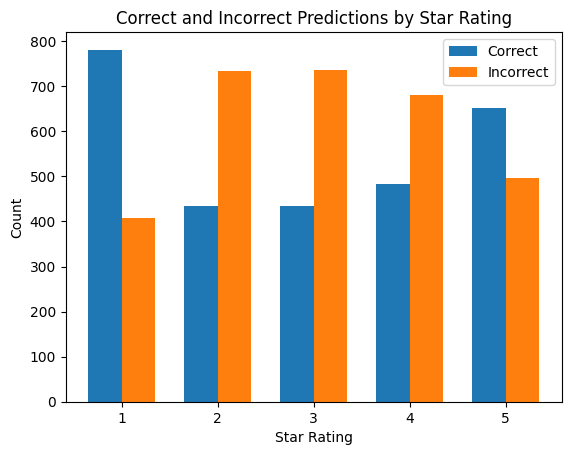

{'Accuracy': 0.47670435080507023, 'Precision': 0.47407011261843907, 'Recall': 0.47634883691060637, 'F1 Score (Macro)': 0.4745282745863488, 'Confusion Matrix': array([[781, 266,  68,  41,  33],
       [305, 434, 244, 119,  65],
       [ 87, 282, 435, 255, 112],
       [ 59, 131, 192, 482, 299],
       [ 42,  64,  65, 326, 651]])}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


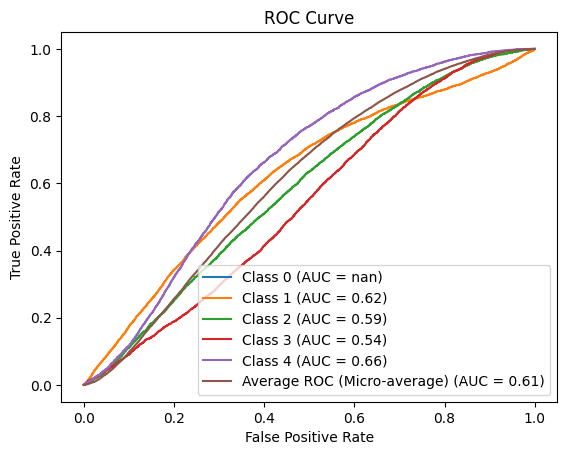

{'fit_time': array([0.01952696, 0.01277709, 0.01543331, 0.01567626, 0.01986003]),
 'score_time': array([0.039644  , 0.02953601, 0.02421784, 0.03057098, 0.0321691 ]),
 'test_accuracy': array([0.47550531, 0.45700582, 0.5080507 , 0.49691675, 0.50505397]),
 'test_f1_macro': array([0.46641153, 0.45493305, 0.50228132, 0.49513601, 0.49288253]),
 'test_recall_macro': array([0.47530013, 0.45814955, 0.50814352, 0.4966959 , 0.50561107]),
 'test_precision_macro': array([0.46477137, 0.45606656, 0.50243506, 0.49489709, 0.49043344]),
 'test_roc_auc_ovr': array([0.79161599, 0.77785463, 0.80594318, 0.80404124, 0.81051717])}

In [362]:
y = y.astype(int)
y = np.ravel(y)
NB_classifier = MultinomialNB()
# Naive Bayes Multiclass Paramter
NB_params = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_prior': [True, False]
}

# Perform grid search with cross-validation
NB_grid_search = GridSearchCV(NB_classifier, NB_params, cv=kf)
NB_grid_search.fit(x_training, y)

# Print the best hyperparameters and score
print("Best Hyperparameters:", NB_grid_search.best_params_)
print("Best Score:", NB_grid_search.best_score_)

# Get the best parameters
NB_best_params = NB_grid_search.best_params_

x_train, x_test, y_train, y_test = train_test_split(x_training, y, test_size = 0.2)

NB_classifier = MultinomialNB(alpha = NB_best_params['alpha'], fit_prior = NB_best_params['fit_prior'])
NB_classifier.fit(x_train, y_train)

predictions = NB_classifier.predict(x_test)

print(multiclass_results(predictions, y_test))

roc_score(NB_classifier, x_training, y)

In [ ]:
#Kaggle

kaggleCSV(NB_classifier.predict(x_test), 'NB')

## Random Forest Classifier

Best Hyperparameters: {'max_depth': None, 'n_estimators': 100}
Best Score: 0.459933603326595


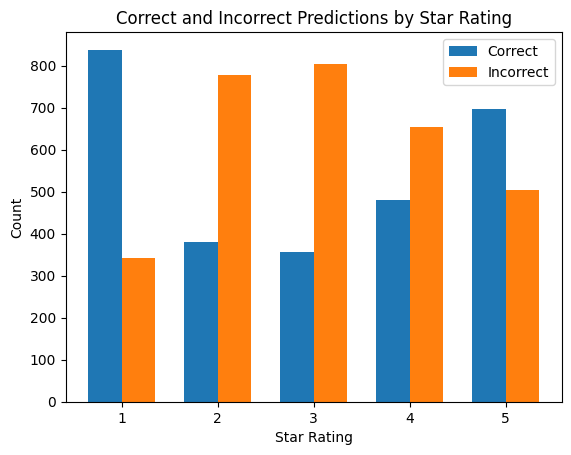

{'Accuracy': 0.47173689619732784, 'Precision': 0.46003684182321986, 'Recall': 0.46982237552964295, 'F1 Score (Macro)': 0.4619079958711111, 'Confusion Matrix': array([[838, 176,  79,  48,  40],
       [351, 381, 220, 135,  71],
       [145, 235, 356, 279, 145],
       [ 54, 100, 195, 481, 306],
       [ 61,  69,  79, 296, 698]])}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


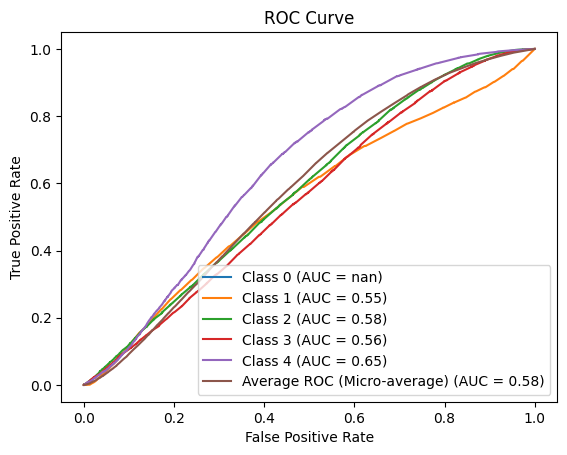

{'fit_time': array([63.88108492, 61.55098915, 72.62881112, 82.92368627, 75.63247085]),
 'score_time': array([0.9511199 , 1.38416696, 1.11479902, 0.96590376, 1.32639122]),
 'test_accuracy': array([0.44587187, 0.42463172, 0.47242206, 0.46060295, 0.46256639]),
 'test_f1_macro': array([0.43394979, 0.41799814, 0.4640719 , 0.45167259, 0.44914464]),
 'test_recall_macro': array([0.44587317, 0.42534008, 0.47300914, 0.46100327, 0.46292459]),
 'test_precision_macro': array([0.43231532, 0.41496043, 0.46164666, 0.45041352, 0.44527164]),
 'test_roc_auc_ovr': array([0.76841915, 0.74443996, 0.77852589, 0.77942477, 0.77745422])}

In [387]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
y=np.ravel(y)
y = y.astype(int)
#Random Forest Classification Multiclass Parameter
rf_params = {
    'n_estimators': [10, 100],
    'max_depth': [None, 5, 10]
}

rf_grid_search = GridSearchCV(rf, rf_params, cv=kf)
rf_grid_search.fit(x_training, y)

print("Best Hyperparameters:", rf_grid_search.best_params_)
print("Best Score:", rf_grid_search.best_score_)

rf_best_params = rf_grid_search.best_params_

x_train, x_test, y_train, y_test = train_test_split(x_training, y, test_size = 0.2)

rf_classifier = RandomForestClassifier(n_estimators = rf_best_params['n_estimators'], max_depth = rf_best_params['max_depth'])
rf_classifier.fit(x_train, y_train)
predictions = rf_classifier.predict(x_test)

print(multiclass_results(predictions, y_test))

roc_score(rf_classifier, x_training, y)
    

In [388]:
#Kaggle 

kaggleCSV(rf_classifier.predict(x_test), 'rf')

# Clustering

## K Means Clustering

In [379]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# Set the number of clusters to 6 since there are 6 categories
k = 6

# Instantiate a KMeans object with the specified number of clusters and the 'elkan' algorithm
kmeans = KMeans(n_clusters=k, algorithm='elkan')

yk = df_test['category'] # assign category label to yk
xk = df_test['style'].astype("U") #change style varable to unicode

# Instantiate a LabelEncoder object for encoding categorical labels
encoder = preprocessing.LabelEncoder()

# Encode the categorical labels in yk using the LabelEncoder
encoded_labels = encoder.fit_transform(yk)

# Determine the number of clusters based on the number of unique classes in the encoded labels
num_clusters = len(encoder.classes_)

# Tokenize and vectorize the feature variable 'style' using a vectorizer (presumably defined earlier)
token = vectorizer.fit_transform(xk)
kmeans.fit(token)

# Predict the cluster labels for the tokenized data
predictions = kmeans.predict(token)
silhouette_avg = silhouette_score(token, predictions)

print("Silhouette score: ", silhouette_avg) # Print the computed average silhouette score

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score:  0.6741702591579974


In [380]:
from sklearn.metrics import adjusted_rand_score

rand_index = adjusted_rand_score(encoded_labels, predictions)
print("Rand Index: ", rand_index)

Rand Index:  0.18287114907563293
